# Human Resources Analysis: Predict Attrition (Predictive Models)

### Group 15
    Francisco Costa, 20181393
    João Gouveia, 20181399
    Nuno Rocha, 20181407
    Pedro Rivera, 20181411

<a class="anchor" id="Table_Contents"></a>
# TABLE OF CONTENTS
<br></br>
* [From previous steps](#previous_steps)


* [# 4. Modelling](#modelling)

    * [# 4.1 Feature Importance (Decision Tree Classifier)](#feature-importance)
    
    * [# 4.2 Inclusive Model](#model1)
        * [# 4.2.1 Sampling: Stratified k-Fold Cross-Validation](#model1_sampling-kfold)
            * [# 4.2.1.1 K-Nearest Neighbours](#model1_sampling-kfold-KNN)
            * [# 4.2.1.2 Neural Networks](#model1_sampling-kfold-NN)
            * [# 4.2.1.3 Deep Learning (KERAS)](#model1_sampling-kfold-DL)
            * [# 4.2.1.4 Logistic Regression](#model1_sampling-kfold-LogReg)
            * [# 4.2.1.5 Naive Bayes](#model1_sampling-kfold-NBayes)
                        
        * [# 4.2.2 Stratified k-Fold Cross-Validation + Oversampling: SMOTENC (R=0.3)](#model1_sampling-SMOTENC_1)
            * [# 4.2.2.1 K-Nearest Neighbours](#model1_sampling-SMOTENC_1-KNN)
            * [# 4.2.2.2 Neural Networks](#model1_sampling-SMOTENC_1-NN)
            * [# 4.2.2.3 Logistic Regression](#model1_sampling-SMOTENC_1-LogReg)
            * [# 4.2.1.4 Naive Bayes](#model1_sampling-SMOTENC_1-NBayes)
       
    * [# 4.3 Full Model](#model2)
        * [# 4.3.1 Sampling: Stratified k-Fold Cross-Validation](#model2_sampling-kfold)
            * [# 4.3.1.1 K-Nearest Neighbours](#model2_sampling-kfold-KNN)
            * [# 4.3.1.2 Neural Networks](#model2_sampling-kfold-NN)
            * [# 4.3.1.3 Deep Learning (KERAS)](#model2_sampling-kfold-DL)
            * [# 4.3.1.4 Logistic Regression](#model2_sampling-kfold-LogReg)
            * [# 4.3.1.5 Naive Bayes](#model2_sampling-kfold-NBayes)
                        
        * [# 4.3.2 Stratified k-Fold Cross-Validation + Oversampling: SMOTENC (R=0.3)](#model2_sampling-SMOTENC_1)
            * [# 4.3.2.1 K-Nearest Neighbours](#model2_sampling-SMOTENC_1-KNN)
            * [# 4.3.2.2 Neural Networks](#model2_sampling-SMOTENC_1-NN)
            * [# 4.3.2.3 Logistic Regression](#model2_sampling-SMOTENC_1-LogReg)
            * [# 4.3.1.4 Naive Bayes](#model2_sampling-SMOTENC_1-NBayes)            
 
    * [# 4.4 Model Comparison](#model_comp)
         

In [1]:
import fPlots

In [2]:
# Import the required libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import scipy as sp
from scipy import interp
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
import seaborn as sns
import datetime as dt
import time
from statistics import mean
import math


from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTENC

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


# Set the style for the Seaborn's plots
sns.set_style('whitegrid',{
    'xtick.bottom': True,
    'xtick.color': '.1',
    'xtick.direction': 'out',
    'xtick.top': False,
    'xtick.major.size': 1,
    'xtick.minor.size': 0.5,
    'ytick.left': True,
    'ytick.color': '.1',
    'ytick.direction': 'out',
    'ytick.right': False,
    'ytick.major.size': 1,
    'ytick.minor.size': 0.5,    
    'ytick.color': '.1',
    'grid.linestyle': '--',
    'axes.edgecolor': '.1',
    'grid.color': '0.8'
 })

Using TensorFlow backend.


In [3]:
#---------------------------------------------------------------------------------------------------------------------
# Perform classification based on a threshold (Predictive Models)
#---------------------------------------------------------------------------------------------------------------------
def f_model_pred_cost(model_in, X_in, threshold_in, DLtype_in = 0):
    if(DLtype_in > 0):
        model_proba = model_in.predict(X_in, batch_size = 1)
        model_pred_cost = [1 if value > threshold_in else 0 for value in model_proba]
    else:
        model_proba = model_in.predict_proba(X = X_in)
        model_pred_cost = [1 if value > threshold_in else 0 for value in model_proba[:, 1]]
    
    return model_pred_cost
#---------------------------------------------------------------------------------------------------------------------
# Fig: Threshold maximizing a Metric (Predictive Models)
#---------------------------------------------------------------------------------------------------------------------
def f_threshold(model_in, nvars_in, threshold_ref_in, metric_in = 'acc', theorerical_in = True, beta_in = 1):
    if('DL' in model_in):
        DLtype = 1
    else:
        DLtype = 0
    figthresholds = plt.figure(figsize = (16, 3), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                             constrained_layout = False)
    width_ratios = [1 for i in range(n_cv)]
    gsthresholds = gridspec.GridSpec(nrows = 1, ncols = n_cv, hspace = .05, wspace = .1,\
                    height_ratios = [1], width_ratios = width_ratios, figure = figthresholds)

    min_metric = 1
    max_metric = 0
    best_threshold_train = []
    best_threshold_test = []
    max_threshold = 0.9
    Nmax_threshold = 25
    threshold_list = np.linspace(0.01, max_threshold, Nmax_threshold)
    for cv in range(n_cv):
        exec('metric_train_list_' + str(cv) + '= []')
        exec('metric_test_list_' + str(cv) + '= []')
        for idx, threshold in enumerate(threshold_list):    
            # correct according to the theshold_in
            exec('pred_train_' + model_in + '_' + str(cv) + ' = f_model_pred_cost(model' + model_in +\
                 '_' + str(cv) + '_' + str(nvars_in) + ', X_train_' + str(cv) + ', ' + '{:.4f}'.format(threshold) + \
                 ', ' + str(DLtype) + ')')         
            exec('pred_test_' + model_in + '_' + str(cv) + ' = f_model_pred_cost(model' + model_in +\
                 '_' + str(cv) + '_' + str(nvars_in) + ', X_test_' + str(cv) + ', ' + '{:.4f}'.format(threshold) + \
                 ', ' + str(DLtype) + ')')  

            if(metric_in == 'f1_0'):
                exec('metric_train = f1_score(y_train_' + str(cv) + ', pred_train_' + model_in + '_' + str(cv) +\
                     ', average = None, warn_for = (), sample_weight = None)[2][0]')

                exec('metric_test = f1_score(y_test_' + str(cv) + ', pred_test_' + model_in + '_' + str(cv) +\
                     ', average = None, warn_for = (), sample_weight = None)[2][0]')

            elif(metric_in == 'f1_1'):
                exec('metric_train = precision_recall_fscore_support(y_train_' + str(cv) + ', pred_train_' + model_in + '_' + str(cv) +\
                     ', average = None, warn_for = (), sample_weight = None)[2][1]')

                exec('metric_test = precision_recall_fscore_support(y_test_' + str(cv) + ', pred_test_' + model_in + '_' + str(cv) +\
                     ', average = None, warn_for = (), sample_weight = None)[2][1]')
            elif(metric_in == 'fbeta_0'):
                exec('metric_train = fbeta_score(y_train_' + str(cv) + ', pred_train_' + model_in + '_' + str(cv) +\
                     ', average = None, warn_for = (), sample_weight = None, beta = ' + '{:.4f}'.format(beta_in) +\
                     ')[2][0]')

                exec('metric_test = fbeta_score(y_test_' + str(cv) + ', pred_test_' + model_in + '_' + str(cv) +\
                     ', average = None, warn_for = (), sample_weight = None, beta = ' + '{:.4f}'.format(beta_in) +\
                     ')[2][0]')

            elif(metric_in == 'fbeta_1'):
                exec('metric_train = precision_recall_fscore_support(y_train_' + str(cv) + ', pred_train_' + model_in + '_' + str(cv) +\
                     ', average = None, warn_for = (), sample_weight = None, beta = ' + '{:.4f}'.format(beta_in) +\
                     ')[2][1]')

                exec('metric_test = precision_recall_fscore_support(y_test_' + str(cv) + ', pred_test_' + model_in + '_' + str(cv) +\
                     ', average = None, warn_for = (), sample_weight = None, beta = ' + '{:.4f}'.format(beta_in) +\
                     ')[2][1]')
            else:
                exec('metric_train = accuracy_score(y_train_' + str(cv) + ', pred_train_' + model_in + '_' + str(cv) +\
                     ', normalize=True, sample_weight=None)')

                exec('metric_test = accuracy_score(y_test_' + str(cv) + ', pred_test_' + model_in + '_' + str(cv) +\
                     ', normalize=True, sample_weight=None)')

            exec('metric_train_list_' + str(cv) + '.append(metric_train)')   
            exec('metric_test_list_' + str(cv) + '.append(metric_test)')


            if(eval('metric_train') < min_metric):
                min_metric = eval('metric_train')
            if(eval('metric_train') > max_metric):
                max_metric = eval('metric_train')
            if(eval('metric_test') < min_metric):
                min_metric = eval('metric_test')
            if(eval('metric_test') > max_metric):
                max_metric = eval('metric_test')

            if((cv == 0)):
                if(min(eval('metric_test'), eval('metric_train')) < 0.05):
                    Nmax_threshold = idx

            if(idx >= Nmax_threshold):
                break

        exec('best_threshold_train.append(threshold_list[metric_train_list_' + str(cv) + \
             '.index(max(metric_train_list_' + str(cv) + '))])')
        exec('best_threshold_test.append(threshold_list[metric_test_list_' + str(cv) + \
             '.index(max(metric_test_list_' + str(cv) + '))])')

    for cv in range(n_cv): 
        ax_threshold_0i = plt.Subplot(figthresholds, gsthresholds[0, cv])
        figthresholds.add_subplot(ax_threshold_0i)

        sns.lineplot(threshold_list[0:Nmax_threshold+1], eval('metric_train_list_' + str(cv)), label = 'train',\
                     color = '#40654f', ax = ax_threshold_0i)
        sns.lineplot(threshold_list[0:Nmax_threshold+1], eval('metric_test_list_' + str(cv)), label = 'test',\
                     color = '#ffb200', ax = ax_threshold_0i)

        ax_threshold_0i.set_xlabel('threshold')
        if(theorerical_in):
            ax_threshold_0i.plot([threshold_ref_in, threshold_ref_in], [min_metric, max_metric],\
                             linestyle = '-', lw = .5, color = 'red', label = 'theoretical', alpha = .8)
        ax_threshold_0i.set_title('fold = ' + str(cv), size = 14)
        ax_threshold_0i.legend(loc = 'best')
        if(cv > 0):
            ax_threshold_0i.set_yticklabels([])
        else:
            if(metric_in=='f1_0'):
                ax_threshold_0i.set_ylabel('f1_score[0]')
            elif(metric_in=='f1_1'):
                ax_threshold_0i.set_ylabel('f1_score[1]')
            elif(metric_in=='fbeta_0'):
                ax_threshold_0i.set_ylabel('fbeta_score[0]')
            elif(metric_in=='fbeta_1'):
                ax_threshold_0i.set_ylabel('fbeta_score[1]')                
            else:     
                ax_threshold_0i.set_ylabel('Overall Accuracy')
        ax_threshold_0i.set_ylim((min_metric, max_metric * 1.1))

        ax_threshold_0i.text(0, min_metric -.22 * (max_metric - min_metric), 'train: ' + '{:.2f}'.format(
            best_threshold_train[cv]), color = 'red', ha = 'left', fontsize = 10)        
        ax_threshold_0i.text(0, min_metric -.3 * (max_metric - min_metric), 'test: ' + '{:.2f}'.format(
            best_threshold_test[cv]), color = 'red', ha = 'left', fontsize = 10)
        
    return figthresholds, best_threshold_train, best_threshold_test
#---------------------------------------------------------------------------------------------------------------------
# Fig: Heatmap for the Confusion Matrices (Predictive Models)
#---------------------------------------------------------------------------------------------------------------------
def f_CM_heatmap(model_in, nvars_in, threshold_in = .5, normalized_in = False, beta_in = 1):
    if('DL' in model_in):
        DLtype = 1
    else:
        DLtype = 0
    figmodels_CM = plt.figure(figsize = (16, 8), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                             constrained_layout = False)
    width_ratios = [1 for i in range(n_cv)]
    width_ratios[-1] = 1.1
    gsmodels = gridspec.GridSpec(nrows = 2, ncols = n_cv, hspace = .85, wspace = .3,\
                    height_ratios = [1, 1], width_ratios = width_ratios, figure = figmodels_CM)
    
    f1_score_train_list_0 = []
    f1_score_train_list_1 = []
    f1_score_test_list_0 = []
    f1_score_test_list_1 = []
    accuracy_train = []
    accuracy_test = []
    precision_train = []
    precision_test = []
    recall_train = []
    recall_test = []
    fbeta_score_train_list_0 = []
    fbeta_score_train_list_1 = []
    fbeta_score_test_list_0 = []
    fbeta_score_test_list_1 = []    
    
    for cv in range(n_cv):           
        # correct according to the theshold_in
        exec('pred_train_' + model_in + '_' + str(cv) + ' =  f_model_pred_cost(model' + model_in + '_' + str(cv) + \
             '_' + str(nvars_in) + ', X_train_' + str(cv) + ', ' + '{:.4f}'.format(threshold_in) + \
             ', ' + str(DLtype) + ')')            
        exec('pred_test_' + model_in + '_' + str(cv) + ' =  f_model_pred_cost(model' + model_in + '_' + str(cv) + \
             '_' + str(nvars_in) + ', X_test_' + str(cv) + ', ' + '{:.4f}'.format(threshold_in) + \
            ', ' + str(DLtype) + ')')                

        if(beta_in == 1):
            exec('f1_score_train_' + model_in + '_' + str(cv) + ' = f1_score(y_train_' + str(cv) + \
                 ', pred_train_' + model_in + '_' + str(cv) + ', average = None)')
            f1_score_train_list_0.append(eval('f1_score_train_' + model_in + '_' + str(cv) + '[0]'))
            f1_score_train_list_1.append(eval('f1_score_train_' + model_in + '_' + str(cv) + '[1]'))
            exec('f1_score_test_' + model_in + '_' + str(cv) + ' = f1_score(y_test_' + str(cv) + \
                 ', pred_test_' + model_in + '_' + str(cv) + ', average = None)')   
            f1_score_test_list_0.append(eval('f1_score_test_' + model_in + '_' + str(cv) + '[0]'))
            f1_score_test_list_1.append(eval('f1_score_test_' + model_in + '_' + str(cv) + '[1]'))
        else: 
            exec('fbeta_score_train_' + model_in + '_' + str(cv) + ' = fbeta_score(y_train_' + str(cv) + \
                 ', pred_train_' + model_in + '_' + str(cv) + ', pos_label=1, sample_weight=None, average = None, beta = ' +\
                 '{:.4f}'.format(beta_in) + ')')
            fbeta_score_train_list_0.append(eval('fbeta_score_train_' + model_in + '_' + str(cv) + '[0]'))
            fbeta_score_train_list_1.append(eval('fbeta_score_train_' + model_in + '_' + str(cv) + '[1]'))
            exec('fbeta_score_test_' + model_in + '_' + str(cv) + ' = fbeta_score(y_test_' + str(cv) + \
                 ', pred_test_' + model_in + '_' + str(cv) + ', pos_label=1, sample_weight=None, average = None, beta = ' +\
                 '{:.4f}'.format(beta_in) + ')')
            fbeta_score_test_list_0.append(eval('fbeta_score_train_' + model_in + '_' + str(cv) + '[0]'))
            fbeta_score_test_list_1.append(eval('fbeta_score_train_' + model_in + '_' + str(cv) + '[1]')) 
            
        precision_train.append(eval('precision_score(y_train_' + str(cv) + ', pred_train_' + model_in + '_' + str(cv) +\
                 ', pos_label=1, sample_weight=None, average=' + '\'' + 'binary' + '\'' + ')'))
        precision_test.append(eval('precision_score(y_test_' + str(cv) + ', pred_test_' + model_in + '_' + str(cv) +\
                 ', pos_label=1, sample_weight=None, average=' + '\'' + 'binary' + '\'' + ')'))
        recall_train.append(eval('recall_score(y_train_' + str(cv) + ', pred_train_' + model_in + '_' + str(cv) +\
                 ', pos_label=1, sample_weight=None, average=' + '\'' + 'binary' + '\'' + ')'))
        recall_test.append(eval('recall_score(y_test_' + str(cv) + ', pred_test_' + model_in + '_' + str(cv) +\
                 ', pos_label=1, sample_weight=None, average=' + '\'' + 'binary' + '\'' + ')'))
      
        exec('dfCM_' + model_in + '_train_' + str(cv) + ' = confusion_matrix(y_train_' + str(cv) + \
             ', pred_train_' + model_in + '_' + str(cv) + ')')

        ax_model_CM_0i = plt.Subplot(figmodels_CM, gsmodels[0, cv])
        figmodels_CM.add_subplot(ax_model_CM_0i)
        
        exec('total_sum_train = dfCM_' + model_in + '_train_' + str(cv) + '.sum().sum()')
        if(cv < n_cv - 1):
            if(normalized_in):
                sns.heatmap(eval('dfCM_' + model_in + '_train_' + str(cv) + '/total_sum_train'),\
                    annot = True, fmt = '.2f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = 1,\
                    linewidths = .5, cbar = False,\
                    ax = ax_model_CM_0i).set_title('Train: fold = ' + str(cv), size = 14)
            else:
                sns.heatmap(eval('dfCM_' + model_in + '_train_' + str(cv)),  annot = True, fmt = '.0f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = len(eval('pred_train_' + model_in + '_' + str(cv))),\
                    linewidths = .5, cbar = False,\
                    ax = ax_model_CM_0i).set_title('Train: fold = ' + str(cv), size = 14)
        else:
            if(normalized_in):
                    sns.heatmap(eval('dfCM_' + model_in + '_train_' + str(cv) + '/total_sum_train'),\
                    annot = True, fmt = '.2f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = 1,\
                    linewidths = .5, cbar = {'shrink': .75, 'label': 'Record Counts'},\
                    ax = ax_model_CM_0i).set_title('Train: fold = ' + str(cv), size = 14)
            else:
                sns.heatmap(eval('dfCM_' + model_in + '_train_' + str(cv)),  annot = True, fmt = '.0f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = len(eval('pred_train_' + model_in + '_' + str(cv))),\
                    linewidths = .5, cbar = {'shrink': .75, 'label': 'Record Counts'},\
                    ax = ax_model_CM_0i).set_title('Train: fold = ' + str(cv), size = 14)
        if(beta_in == 1):
            ax_model_CM_0i.text(1.5, -.15, 'f1_score [0]: ' + '{:.2f}'.format(
                eval('f1_score_train_' + model_in + '_' + str(cv) + '[0]')), color = 'red', ha = 'left', fontsize = 10)
            ax_model_CM_0i.text(1.5, -.3, 'f1_score [1]: ' + '{:.2f}'.format(
                eval('f1_score_train_' + model_in + '_' + str(cv) + '[1]')), color = 'red', ha = 'left', fontsize = 10)
        else:
            ax_model_CM_0i.text(1.5, -.15, 'fbeta_score [0]: ' + '{:.2f}'.format(
                eval('fbeta_score_train_' + model_in + '_' + str(cv) + '[0]')), color = 'red', ha = 'left',\
                                fontsize = 10)
            ax_model_CM_0i.text(1.5, -.3, 'fbeta_score [1]: ' + '{:.2f}'.format(
                eval('fbeta_score_train_' + model_in + '_' + str(cv) + '[1]')), color = 'red', ha = 'left',\
                                fontsize = 10)
        
        accuracy_train.append(eval('accuracy_score(y_train_' + str(cv) + ', pred_train_' + model_in + '_' + str(cv) +\
                 ', normalize=True, sample_weight=None)'))
        
        ax_model_CM_0i.text(1.5, -.45, 'accuracy: ' + '{:.2f}'.format(accuracy_train[cv]),\
                            color = 'red', ha = 'left', fontsize = 10)
        ax_model_CM_0i.text(1.5, -.6, 'precision: ' + '{:.2f}'.format(precision_train[cv]),\
                    color = 'red', ha = 'left', fontsize = 10)
        ax_model_CM_0i.text(1.5, -.75, 'recall: ' + '{:.2f}'.format(recall_train[cv]),\
            color = 'red', ha = 'left', fontsize = 10)
        
        ax_model_CM_0i.invert_xaxis()
        ax_model_CM_0i.invert_yaxis()
        ax_model_CM_0i.set_xlabel('predicted')
        ax_model_CM_0i.set_ylabel('actual')
        ax_model_CM_0i.xaxis.set_ticks_position('top')
        ax_model_CM_0i.xaxis.set_label_position('top')


        exec('dfCM_' + model_in + '_test_' + str(cv) + ' = confusion_matrix(y_test_' + str(cv) + \
             ', pred_test_' + model_in + '_' + str(cv) + ')')
        ax_model_CM_1i = plt.Subplot(figmodels_CM, gsmodels[1, cv])
        figmodels_CM.add_subplot(ax_model_CM_1i)
        
        exec('total_sum_test = dfCM_' + model_in + '_test_' + str(cv) + '.sum().sum()')
        if(cv < n_cv - 1):
            if(normalized_in):
                sns.heatmap(eval('dfCM_' + model_in + '_test_' + str(cv) + '/total_sum_test'),\
                    annot = True, fmt = '.2f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = 1,\
                    linewidths = .5, cbar = False,\
                    ax = ax_model_CM_1i).set_title('Test: fold = ' + str(cv), size = 14)
            else:
                sns.heatmap(eval('dfCM_' + model_in + '_test_' + str(cv)),  annot = True, fmt = '.0f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = len(eval('pred_test_' + model_in + '_' + str(cv))),\
                    linewidths = .5, cbar = False,\
                    ax = ax_model_CM_1i).set_title('Test: fold = ' + str(cv), size = 14)

        else:
            if(normalized_in):
                sns.heatmap(eval('dfCM_' + model_in + '_test_' + str(cv) + '/total_sum_test'),\
                    annot = True, fmt = '.2f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = 1,\
                    linewidths = .5, cbar = {'shrink': .75, 'label': 'Record Counts'},\
                    ax = ax_model_CM_1i).set_title('Test: fold = ' + str(cv), size = 14)                
                
            else:
                sns.heatmap(eval('dfCM_' + model_in + '_test_' + str(cv)),  annot = True, fmt = '.0f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = len(eval('pred_test_' + model_in + '_' + str(cv))),\
                    linewidths = .5, cbar = {'shrink': .75, 'label': 'Record Counts'},\
                    ax = ax_model_CM_1i).set_title('Test: fold = ' + str(cv), size = 14)
        
        if(beta_in == 1):
            ax_model_CM_1i.text(1.5, -.15, 'f1_score [0]: ' + '{:.2f}'.format(
                eval('f1_score_test_' + model_in + '_' + str(cv) + '[0]')), color = 'red', ha = 'left', fontsize = 10)
            ax_model_CM_1i.text(1.5, -.3, 'f1_score [1]: ' + '{:.2f}'.format(
                eval('f1_score_test_' + model_in + '_' + str(cv) + '[1]')), color = 'red', ha = 'left', fontsize = 10)
        else:
            ax_model_CM_1i.text(1.5, -.15, 'fbeta_score [0]: ' + '{:.2f}'.format(
                eval('fbeta_score_test_' + model_in + '_' + str(cv) + '[0]')), color = 'red', ha = 'left',\
                                fontsize = 10)
            ax_model_CM_1i.text(1.5, -.3, 'fbeta_score [1]: ' + '{:.2f}'.format(
                eval('fbeta_score_test_' + model_in + '_' + str(cv) + '[1]')), color = 'red', ha = 'left',\
                                fontsize = 10)            
        
        accuracy_test.append(eval('accuracy_score(y_test_' + str(cv) + ', pred_test_' + model_in + '_' + str(cv) +\
                 ', normalize=True, sample_weight=None)'))

        ax_model_CM_1i.text(1.5, -.45, 'accuracy: ' + '{:.2f}'.format(accuracy_test[cv]),\
                            color = 'red', ha = 'left', fontsize = 10)
        ax_model_CM_1i.text(1.5, -.6, 'precision: ' + '{:.2f}'.format(precision_test[cv]),\
                    color = 'red', ha = 'left', fontsize = 10)
        ax_model_CM_1i.text(1.5, -.75, 'recall: ' + '{:.2f}'.format(recall_test[cv]),\
            color = 'red', ha = 'left', fontsize = 10)

        ax_model_CM_1i.invert_xaxis()
        ax_model_CM_1i.invert_yaxis()
        ax_model_CM_1i.set_xlabel('predicted')
        ax_model_CM_1i.set_ylabel('actual')
        ax_model_CM_1i.xaxis.set_ticks_position('top')
        ax_model_CM_1i.xaxis.set_label_position('top')
        
        if(beta_in == 1):
            f_score_train = [np.mean(f1_score_train_list_0), np.mean(f1_score_train_list_1)]
            f_score_test = [np.mean(f1_score_test_list_0), np.mean(f1_score_test_list_1)]          
        else:
            f_score_train = [np.mean(fbeta_score_train_list_0), np.mean(fbeta_score_train_list_1)]
            f_score_test = [np.mean(fbeta_score_test_list_0), np.mean(fbeta_score_test_list_1)]  
            
        
    return figmodels_CM, f_score_train, f_score_test, accuracy_train, accuracy_test,\
precision_train, precision_test, recall_train, recall_test
#---------------------------------------------------------------------------------------------------------------------
# Fig: ROC + Precision Recall Curves (Predictive Models)
#---------------------------------------------------------------------------------------------------------------------
def f_ModelEval_Curves(model_in, nvars_in, title_in): 
    figModelEval = plt.figure(figsize = (12, 5), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsModelEval = gridspec.GridSpec(nrows = 1, ncols = 2, hspace = .05, wspace = .45,\
                        height_ratios = [1], width_ratios = [1, 1], figure = figModelEval)

    # ROC Curve
    axModelEval_ROC = plt.Subplot(figModelEval, gsModelEval[0, 0])
    figModelEval.add_subplot(axModelEval_ROC)

    tprs = []
    roc_aucs = []
    thresholds = []
    mean_fpr = np.linspace(0, 1, 100)

    for cv in range(n_cv):
        if('DL' in model_in):
            exec('prob_model_' + model_in + '_' + str(cv) + ' = model' + model_in + '_' + str(cv) + '_' + str(nvars_in) + \
                     '.predict(X_test_' + str(cv) + ', batch_size = 1)')
            fpr_raw_i, tpr_raw_i, thresholds_raw_i = roc_curve(eval('y_test_' + str(cv)), \
                       eval('prob_model_' + model_in + '_' + str(cv)), pos_label = 1,\
                                       drop_intermediate = True)

        else:
            exec('prob_model_' + model_in + '_' + str(cv) + ' = model' + model_in + '_' + str(cv) + '_' + str(nvars_in) + \
                 '.predict_proba(X = X_test_' + str(cv) + ')')
            fpr_raw_i, tpr_raw_i, thresholds_raw_i = roc_curve(eval('y_test_' + str(cv)), \
                                   eval('prob_model_' + model_in + '_' + str(cv) + '[:,1]'), pos_label = 1,\
                                                   drop_intermediate = True)

        tprs.append(interp(mean_fpr, fpr_raw_i, tpr_raw_i))
        tprs[-1][0] = 0
        thresholds.append(interp(mean_fpr, fpr_raw_i, thresholds_raw_i ))
        roc_auc = auc(fpr_raw_i, tpr_raw_i)
        roc_aucs.append(roc_auc)    

        sns.lineplot(fpr_raw_i, tpr_raw_i, label = 'fold = ' + str(cv) + ' (AUC = ' +'{:.2f}'.format(roc_auc) + ')',\
                     ax = axModelEval_ROC)


    # mean ROC curve
    model_mean_frp = mean_fpr
    model_mean_tpr = np.mean(tprs, axis = 0)
    model_mean_tpr[-1] = 1
    model_mean_thresholds = np.mean(thresholds, axis = 0)
    model_mean_roc_auc = auc(mean_fpr, model_mean_tpr)

    sns.lineplot(model_mean_frp, model_mean_tpr, label = 'Mean ROC (AUC = ' +'{:.2f}'.\
                 format(model_mean_roc_auc) + ')', ax = axModelEval_ROC, lw = 2, color = 'black')

    axModelEval_ROC.set_xlabel('1 - Specificity')
    axModelEval_ROC.set_ylabel('Sensitivity')
    axModelEval_ROC.plot([0, 1], [0, 1], linestyle = '--', lw = .5, color = 'black', label = 'Chance', alpha = .8)
    axModelEval_ROC.set_title('ROC Curve: ' + title_in, fontsize = 14)
    axModelEval_ROC.legend(loc = 'lower right')

    # add threshold labels (for the mean curve)
    aux = 0
    for index, point in enumerate(model_mean_thresholds):
        if(index == 0):
            axModelEval_ROC.text(model_mean_frp[index] + .02, model_mean_tpr[index] - .02, '{:.2f}'.format(point))
            aux = point
        elif((aux - point) > 0.05):
            axModelEval_ROC.text(model_mean_frp[index] + .02, model_mean_tpr[index] - 0.02, '{:.2f}'.format(point))
            aux = point

    # Precision-Recall Curve
    axModelEval_PR = plt.Subplot(figModelEval, gsModelEval[0, 1])
    figModelEval.add_subplot(axModelEval_PR)

    ratios = []
    precisions = []
    pr_aucs = []
    thresholds = []
    mean_recall = np.linspace(0, 1, 100)

    for cv in range(n_cv):
        if('DL' in model_in):
            exec('prob_model_' + model_in + '_' + str(cv) + ' = model' + model_in + '_' + str(cv) + '_' + str(nvars_in) + \
                     '.predict(X_test_' + str(cv) + ', batch_size = 1)')
            precision_raw_i, recall_raw_i, thresholds_raw_i = precision_recall_curve(eval('y_test_' + str(cv)), \
                       eval('prob_model_' + model_in + '_' + str(cv)), pos_label = 1)

        else:
            exec('prob_model_' + model_in + '_' + str(cv) + ' = model' + model_in + '_' + str(cv) + '_' + str(nvars_in) + \
                 '.predict_proba(X = X_test_' + str(cv) + ')')
            precision_raw_i, recall_raw_i, thresholds_raw_i = precision_recall_curve(eval('y_test_' + str(cv)), \
                                   eval('prob_model_' + model_in + '_' + str(cv) + '[:,1]'), pos_label = 1)
        ratios.append(eval('np.count_nonzero(y_train_' + str(cv) + \
                                                              '==1)/np.count_nonzero(y_train_' + str(cv) + '==0)'))


        precisions.append(interp(mean_recall, recall_raw_i[::-1][1:], precision_raw_i[::-1][1:]))
        thresholds.append(interp(mean_recall, recall_raw_i[::-1][1:], thresholds_raw_i[::-1]))
        pr_auc = auc(recall_raw_i, precision_raw_i)
        pr_aucs.append(pr_auc)    

        sns.lineplot(recall_raw_i[::-1][1:], precision_raw_i[::-1][1:], label = 'fold = ' + str(cv) + \
                     ' (AUC = ' + '{:.2f}'.format(pr_auc) + ')', ax = axModelEval_PR)


    # mean PR curve
    model_mean_recall = mean_recall
    model_mean_precision = np.mean(precisions, axis = 0)
    model_mean_thresholds = np.mean(thresholds, axis = 0)
    model_mean_pr_auc = auc(mean_recall, model_mean_precision)

    sns.lineplot(model_mean_recall, model_mean_precision, label = 'Mean PR (AUC = ' +'{:.2f}'.\
                 format(model_mean_pr_auc) + ')', ax = axModelEval_PR, lw = 2, color = 'black')

    axModelEval_PR.set_xlabel('Recall')
    axModelEval_PR.set_ylabel('Precision')
    axModelEval_PR.plot([0, 1], [np.mean(ratios, axis = 0), np.mean(ratios, axis = 0)], linestyle = '--',\
                        lw = .5, color = 'black', label = 'Chance', alpha = .8)
    axModelEval_PR.set_title('PR Curve: ' + title_in, fontsize = 14)
    axModelEval_PR.legend(loc = 'lower left')

    # add threshold labels (for the mean curve)
    aux = 0
    print('PR Curve:')
    for index, point in enumerate(model_mean_thresholds):
        if(index == 0):
            axModelEval_PR.text(model_mean_recall[index] + .04, model_mean_precision[index] + .005,\
                                '{:.2f}'.format(point))
            print('recall: ' + '{:.2f}'.format(model_mean_recall[index]) + \
              ' | precision: ' + '{:.2f}'.format(model_mean_precision[index]) + \
              ' | threshold: ' + '{:.3f}'.format(point))
            aux = point
        elif((aux - point) > 0.05):
            axModelEval_PR.text(model_mean_recall[index] + .04, model_mean_precision[index] + .005,\
                                '{:.2f}'.format(point))
            print('recall: ' + '{:.2f}'.format(model_mean_recall[index]) + \
              ' | precision: ' + '{:.2f}'.format(model_mean_precision[index]) + \
              ' | threshold: ' + '{:.3f}'.format(point))
            aux = point
    return figModelEval, model_mean_roc_auc, model_mean_pr_auc

In [4]:
#---------------------------------------------------------------------------------------------------------------------
# Smooth Line for plots
#---------------------------------------------------------------------------------------------------------------------
def smooth_curve(points, factor = .9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [5]:
#---------------------------------------------------------------------------------------------------------------------
# KNN test for k-nearest neighbours
#---------------------------------------------------------------------------------------------------------------------
def f_model_KNN_test(kmax_in, kstep_in, title_in, smooth_in = .1, model_eval_curve_in = 'roc'):
    k_list = [value for value in range(1, kmax_in, kstep_in)]
    threshold = .001 # for the best NN
    min_auc = 1
    max_auc = 0

    # iterate through each fold of the cross validation
    for cv in range(n_cv):
        exec('auc_score_list_KNN_' + str(cv) + ' = []')
        exec('red_auc_score_list_KNN_' + str(cv) + ' = []')
        k_max_auc_NN = 0
        k_bool = True
        exec('bestNN_' + str(cv) + ' = []')

        # iterate through each NN (k-nearest neighbours)
        for idx, k in enumerate(k_list):
            modelKNN = KNeighborsClassifier(n_neighbors = k)
            exec('modelKNN.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')
            exec('prob_modelKNN_' + str(cv) + ' = modelKNN' + '.predict_proba(X = X_test_' + str(cv) + ')')

            if(model_eval_curve_in == 'pr'):
                exec('precision_raw, recall_raw, thresholds_raw = precision_recall_curve(y_test_' + str(cv) + ', ' + \
                                           'prob_modelKNN_' + str(cv) + '[:,1], pos_label = 1)')
                exec('auc_score_list_KNN_' + str(cv) + '.append(auc(recall_raw, precision_raw))')

            else:
                exec('fpr_raw, tpr_raw, thresholds_raw = roc_curve(y_test_' + str(cv) + ', ' + \
                                           'prob_modelKNN_' + str(cv) + '[:,1], pos_label = 1, drop_intermediate = False)')
                exec('auc_score_list_KNN_' + str(cv) + '.append(auc(fpr_raw, tpr_raw))')

            if(idx > 0):
                exec('red_auc_score_list_KNN_' + str(cv) + '.append((auc_score_list_KNN_' + str(cv) + \
                     '[' + str(idx) + '] - auc_score_list_KNN_' + str(cv) + '[' + str(idx-1) + \
                     ']) / auc_score_list_KNN_' + str(cv) + '[' + str(idx-1) + '])')

                if((k_bool) & (eval('red_auc_score_list_KNN_' + str(cv) + '[' + str(idx - 1) + ']') < threshold)):
                    k_max_auc_NN = k
                    k_bool = False

        if(eval('min(auc_score_list_KNN_' + str(cv) + ')') < min_auc):
            min_auc = eval('min(auc_score_list_KNN_' + str(cv) + ')')     
        if(eval('max(auc_score_list_KNN_' + str(cv) + ')') > max_auc):
            max_auc = eval('max(auc_score_list_KNN_' + str(cv) + ')')

        # only store the k best KNN model    
        exec('bestNN_' + str(cv) + '.append(k_max_auc_NN)')
        best_k = eval('bestNN_' + str(cv))[0]

    # plot the AUC Score vs k NN
    figmodelKNNs = plt.figure(figsize = (16, 4), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsKNNs = gridspec.GridSpec(nrows = 1, ncols = n_cv, hspace = .05, wspace = .05,\
                        height_ratios = [1], width_ratios = [1 for i in range(n_cv)], figure = figmodelKNNs)

    if(model_eval_curve_in == 'pr'):
        label_str = 'PR AUC'
    else:
        label_str = 'ROC AUC'
        
    # iterate through each cross validation
    for cv in range(n_cv):                           
        ax_modelKNN_0i = plt.Subplot(figmodelKNNs, gsKNNs[0, cv])
        figmodelKNNs.add_subplot(ax_modelKNN_0i)

        sns.lineplot(k_list, eval('smooth_curve(auc_score_list_KNN_' + str(cv) + ',' + \
                                  '{:.2f}'.format(smooth_in) + ')'), label = label_str,\
                     ax = ax_modelKNN_0i).set_title('fold = ' + str(cv), size = 14)
        ax_modelKNN_0i.set_xlabel('NN | ' + str(eval('bestNN_' + str(cv))))
        ax_modelKNN_0i.set_ylim((.95 * min_auc, 1.05 * max_auc))
        if(cv > 0):
            ax_modelKNN_0i.set_yticklabels([])
        else:
            ax_modelKNN_0i.set_ylabel(label_str)
        ax_modelKNN_0i.tick_params(axis = 'y', colors = '#3182bd')
        ax_modelKNN_0i.legend(loc = 'upper left')

        ax_modelKNN_1i = ax_modelKNN_0i.twinx()
        sns.lineplot(k_list[1:], eval('smooth_curve(red_auc_score_list_KNN_' + str(cv) + ',' + \
                                      '{:.2f}'.format(smooth_in) + ')'), label = '% AUC variation',\
                     color = 'red', linewidth = .25, ax = ax_modelKNN_1i)
        ax_modelKNN_1i.grid(color = 'grey', linestyle = '', linewidth = 0)
        ax_modelKNN_1i.legend(loc = 'center right')
        ax_modelKNN_1i.set_ylim((0, .025))
        if(cv < n_cv - 1):
            ax_modelKNN_1i.axes.get_yaxis().set_ticks([])
        else:
            ax_modelKNN_1i.set_ylabel('% AUC variation')
        ax_modelKNN_1i.tick_params(axis = 'y', colors = '#cd5c5c')

        ax_modelKNN_1i.plot([0, max(k_list)], [threshold , threshold], linestyle = '-', lw = 1,\
                            color = 'black', label = 'Threshold', alpha = 1)   

    st = figmodelKNNs.suptitle(title_in, fontsize = 14)
    st.set_y(0.95)
    figmodelKNNs.subplots_adjust(top = .8)
    return figmodelKNNs

In [6]:
#---------------------------------------------------------------------------------------------------------------------
# Neural Networks test for Learning Rate
#---------------------------------------------------------------------------------------------------------------------
def f_model_NN_testLR(LT_min_in, LR_max_in, NLR_in, epochs_max_in, n_neurons_in, n_hidden_in, nvars_in,\
                        title_in, smooth_in = .1, model_eval_curve_in = 'roc'):

    LR_list = np.linspace(LT_min_in, LR_max_in, NLR_in)
    threshold = .001
    min_auc = 1
    max_auc = 0
    title = 'Neural Network (' + str(nvars_in) + ('-' + str(n_neurons_in)) * n_hidden_in + '-1): '

    # iterate through each cross validation
    for cv in range(n_cv):
        exec('auc_score_list_NN_' + str(cv) + ' = []')
        exec('red_auc_score_list_NN_' + str(cv) + ' = []')

        # iterate through each parameter value
        for idx, LR in enumerate(LR_list):
            modelNN = MLPClassifier(solver = 'sgd', activation = 'logistic', max_iter = epochs_max_in,\
                                    learning_rate = 'adaptive', learning_rate_init = LR,
                                    random_state = None, shuffle = True, momentum = .9,\
                                    hidden_layer_sizes = tuple([n_neurons_in for h in range(n_hidden_in)]),\
                                    n_iter_no_change = 3, tol = 1e-3)

            exec('modelNN.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')
            exec('prob_modelNN_' + str(cv) + ' = modelNN' + '.predict_proba(X = X_test_' + str(cv) + ')')
            
            if(model_eval_curve_in == 'pr'):
                exec('precision_raw, recall_raw, thresholds_raw = precision_recall_curve(y_test_' + str(cv) + ', ' + \
                                           'prob_modelNN_' + str(cv) + '[:,1], pos_label = 1)')
                exec('auc_score_list_NN_' + str(cv) + '.append(auc(recall_raw, precision_raw))')
            else:
                exec('fpr_raw, tpr_raw, thresholds_raw = roc_curve(y_test_' + str(cv) + ', ' + \
                                           'prob_modelNN_' + str(cv) + '[:,1], pos_label = 1, drop_intermediate = False)')
                exec('auc_score_list_NN_' + str(cv) + '.append(auc(fpr_raw, tpr_raw))')
            
            if(idx > 0):
                exec('red_auc_score_list_NN_' + str(cv) + '.append((auc_score_list_NN_' + str(cv) + \
                     '[' + str(idx) + '] - auc_score_list_NN_' + str(cv) + '[' + str(idx-1) + \
                     ']) / auc_score_list_NN_' + str(cv) + '[' + str(idx-1) + '])')

        if(eval('min(auc_score_list_NN_' + str(cv) + ')') < min_auc):
            min_auc = eval('min(auc_score_list_NN_' + str(cv) + ')')     
        if(eval('max(auc_score_list_NN_' + str(cv) + ')') > max_auc):
            max_auc = eval('max(auc_score_list_NN_' + str(cv) + ')')  
            
    # plot the AUC Score vs Learning Rate
    figmodelNNs = plt.figure(figsize = (16, 4), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsNNs = gridspec.GridSpec(nrows = 1, ncols = n_cv, hspace = .05, wspace = .1,\
                        height_ratios = [1], width_ratios = [1 for i in range(n_cv)], figure = figmodelNNs)
    
    if(model_eval_curve_in == 'pr'):
        label_str = 'PR AUC'
    else:
        label_str = 'ROC AUC'
        
    # iterate through each cross validation                       
    for cv in range(n_cv):                           
        ax_modelNN_0i = plt.Subplot(figmodelNNs, gsNNs[0, cv])
        figmodelNNs.add_subplot(ax_modelNN_0i)

        sns.lineplot(LR_list, eval('smooth_curve(auc_score_list_NN_' + str(cv) + ',' + \
                  '{:.2f}'.format(smooth_in) + ')'), label = 'AUC',
                     ax = ax_modelNN_0i).set_title('fold = ' + str(cv), size = 14)
        ax_modelNN_0i.set_xlabel('LR')
        ax_modelNN_0i.set_ylim((.9 * min_auc, 1.15 * max_auc))
        if(cv > 0):
            ax_modelNN_0i.set_yticklabels([])
        else:
            ax_modelNN_0i.set_ylabel(label_str)
        ax_modelNN_0i.tick_params(axis = 'y', colors = '#3182bd')
        ax_modelNN_0i.legend(loc = 'upper right')

        ax_modelNN_1i = ax_modelNN_0i.twinx()
        sns.lineplot(LR_list[1:], eval('smooth_curve(red_auc_score_list_NN_' + str(cv) + ',' + \
                  '{:.2f}'.format(smooth_in) + ')'), label = '% AUC variation', color = 'red', linewidth = .25,\
                     ax = ax_modelNN_1i)
        ax_modelNN_1i.grid(color ='grey', linestyle = '', linewidth = 0)
        ax_modelNN_1i.set_ylim((0, .005))
        if(cv < n_cv - 1):
            ax_modelNN_1i.axes.get_yaxis().set_ticks([])
        else:
            ax_modelNN_1i.set_ylabel('% AUC variation')
        ax_modelNN_1i.tick_params(axis = 'y', colors = '#cd5c5c')
        ax_modelNN_1i.legend(loc = 'lower right')

        ax_modelNN_1i.plot([min(LR_list), max(LR_list)],\
                           [threshold , threshold], linestyle = '-', lw = 1,\
                            color = 'black', label = 'Threshold', alpha = 1) 

    st = figmodelNNs.suptitle(title + title_in, fontsize = 14)
    st.set_y(0.95)
    figmodelNNs.subplots_adjust(top = .8)

    return figmodelNNs

In [7]:
#---------------------------------------------------------------------------------------------------------------------
# Neural Networks test for Network Architecture
#---------------------------------------------------------------------------------------------------------------------            
def f_model_NN_testNeurons(LR_in, Neurons_in_min, Neurons_in_max, Neuronsstep_in, epochs_max_in, n_hidden_in,\
                          nvars_in, title_in, smooth_in = .1, model_eval_curve_in = 'roc'):     

    n_neurons_list = range(Neurons_in_min, Neurons_in_max, Neuronsstep_in)
    threshold = .001
    min_auc = 1
    max_auc = 0
    title = 'Neural Network (' + str(nvars_in) + ('-' + 'N') * n_hidden_in + '-1): '
    
    # iterate through each cross validation
    for cv in range(n_cv):
        exec('auc_score_list_NN_' + str(cv) + ' = []')
        exec('red_auc_score_list_NN_' + str(cv) + ' = []')

        # iterate through each parameter value
        for idx, n_neurons in enumerate(n_neurons_list):
            modelNN = MLPClassifier(solver = 'sgd', activation = 'logistic', max_iter = epochs_max_in,\
                                    learning_rate = 'adaptive', learning_rate_init = LR_in,
                                    random_state = None, shuffle = True, momentum = .9,\
                                    hidden_layer_sizes = tuple([n_neurons for h in range(n_hidden_in)]),\
                                    n_iter_no_change = 3, tol = 1e-3)

            exec('modelNN.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')
            exec('prob_modelNN_' + str(cv) + ' = modelNN' + '.predict_proba(X = X_test_' + str(cv) + ')')
            if(model_eval_curve_in == 'pr'):
                exec('precision_raw, recall_raw, thresholds_raw = precision_recall_curve(y_test_' + str(cv) + ', ' + \
                                           'prob_modelNN_' + str(cv) + '[:,1], pos_label = 1)')
                exec('auc_score_list_NN_' + str(cv) + '.append(auc(recall_raw, precision_raw))')
                
            else:
                exec('fpr_raw, tpr_raw, thresholds_raw = roc_curve(y_test_' + str(cv) + ', ' + \
                                           'prob_modelNN_' + str(cv) + '[:,1], pos_label = 1, drop_intermediate = False)')
                exec('auc_score_list_NN_' + str(cv) + '.append(auc(fpr_raw, tpr_raw))')

            if(idx > 0):
                exec('red_auc_score_list_NN_' + str(cv) + '.append((auc_score_list_NN_' + str(cv) + \
                     '[' + str(idx) + '] - auc_score_list_NN_' + str(cv) + '[' + str(idx-1) + \
                     ']) / auc_score_list_NN_' + str(cv) + '[' + str(idx-1) + '])')

        if(eval('min(auc_score_list_NN_' + str(cv) + ')') < min_auc):
            min_auc = eval('min(auc_score_list_NN_' + str(cv) + ')')     
        if(eval('max(auc_score_list_NN_' + str(cv) + ')') > max_auc):
            max_auc = eval('max(auc_score_list_NN_' + str(cv) + ')')            
            
    # plot the AUC Score vs Network Architecture
    figmodelNNs = plt.figure(figsize = (16, 4), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsNNs = gridspec.GridSpec(nrows = 1, ncols = n_cv, hspace = .05, wspace = .1,\
                        height_ratios = [1], width_ratios = [1 for i in range(n_cv)], figure = figmodelNNs)
    
    if(model_eval_curve_in == 'pr'):
        label_str = 'PR AUC'
    else:
        label_str = 'ROC AUC'
    # iterate through each cross validation                       
    for cv in range(n_cv):                           
        ax_modelNN_0i = plt.Subplot(figmodelNNs, gsNNs[0, cv])
        figmodelNNs.add_subplot(ax_modelNN_0i)

        sns.lineplot(n_neurons_list, eval('smooth_curve(auc_score_list_NN_' + str(cv) + ',' + \
                  '{:.2f}'.format(smooth_in) + ')'), label = 'AUC', \
        ax = ax_modelNN_0i).set_title('fold = ' + str(cv), size = 14)
        ax_modelNN_0i.set_xlabel('N neurons (' + str(n_hidden_in) + ' hidden layer)')
        ax_modelNN_0i.set_ylim((.9 * min_auc, 1.15 * max_auc))
        if(cv > 0):
            ax_modelNN_0i.set_yticklabels([])
        else:
            ax_modelNN_0i.set_ylabel(label_str)
        ax_modelNN_0i.tick_params(axis = 'y', colors = '#3182bd')
        ax_modelNN_0i.legend(loc = 'upper right')

        ax_modelNN_1i = ax_modelNN_0i.twinx()
        sns.lineplot(n_neurons_list[1:], eval('smooth_curve(red_auc_score_list_NN_'  + str(cv) + ',' + \
                  '{:.2f}'.format(smooth_in) + ')'), label = '% AUC variation', color = 'red', linewidth = .25,\
                     ax = ax_modelNN_1i)
        ax_modelNN_1i.grid(color ='grey', linestyle = '', linewidth = 0)
        ax_modelNN_1i.legend(loc = 'lower right')
        ax_modelNN_1i.set_ylim((0, .005))
        if(cv < n_cv - 1):
            ax_modelNN_1i.axes.get_yaxis().set_ticks([])
        else:
            ax_modelNN_1i.set_ylabel('% AUC reduction')
        ax_modelNN_1i.tick_params(axis = 'y', colors = '#cd5c5c')

        ax_modelNN_1i.plot([min(n_neurons_list), max(n_neurons_list)],\
                           [threshold , threshold], linestyle = '-', lw = 1,\
                            color = 'black', label = 'Threshold', alpha = 1)   

    st = figmodelNNs.suptitle(title + title_in, fontsize = 14)
    st.set_y(0.95)
    figmodelNNs.subplots_adjust(top = .8)

    return figmodelNNs

In [8]:
#---------------------------------------------------------------------------------------------------------------------
# Deep Learning add the predictions to the log (for each epoch)--> callbacks (Keras)
#---------------------------------------------------------------------------------------------------------------------
class OutputObserver(callbacks.Callback):
    def __init__(self, X_predict):
        self.out_log = []
        self.X_predict = X_predict

    def on_epoch_end(self, epoch, logs = {}):
        self.out_log.append(self.model.predict(self.X_predict, batch_size = 1))

In [9]:
#---------------------------------------------------------------------------------------------------------------------
# Deep Learning test for Learning Rate
#---------------------------------------------------------------------------------------------------------------------
def f_model_DL_LR(LT_min_in, LR_max_in, NLR_in, epochs_max_in, n_hidden_in, nvars_in, title_in, smooth_in = .1, \
                  model_eval_curve_in = 'roc'):
    def lr_scheduler(epoch, lr):
        return lr*10**(np.log10(0.01)/epochs_max_in)

    min_auc = 1
    max_auc = 0
    min_loss = 10000000
    max_loss = 0
    min_acc = 10000000
    title = 'Deep Learning (' + str(nvars_in)
    LR_list = np.linspace(LT_min_in, LR_max_in, NLR_in)
    Nmax_epochs = epochs_max_in
    val_loss_max = 0

    # iterate through each cross validation fold
    for cv in range(n_cv):
        exec('train_loss_list_DL_' + str(cv) + ' = []')
        exec('train_accuracy_list_DL_' + str(cv) + ' = []')
        exec('test_loss_list_DL_' + str(cv) + ' = []')
        exec('test_accuracy_list_DL_' + str(cv) + ' = []')    
        exec('auc_score_list_DL_' + str(cv) + ' = []')

        # define the architecture of the network
        modelDL = models.Sequential()
        modelDL.add(layers.Dense(n_hidden_in[0], activation = 'relu', input_dim = nvars_in)) # add the first hidden layer
        if(cv == 0):
            title = title + '-' + str(n_hidden_in[0])
        for h in range(1, len(n_hidden_in)): # add the remaining hidden layers
            modelDL.add(layers.Dense(n_hidden_in[h], activation = 'relu'))
            if(cv == 0):
                title = title + '-' + str(n_hidden_in[h])
        modelDL.add(layers.Dense(1, activation = 'sigmoid')) # add the output layer


        # iterate through each LR
        for idx, LR in enumerate(LR_list):
            # optimizer (set the Learning Rate)
            optm = optimizers.SGD(learning_rate = LR, momentum = .9, nesterov = False)
            lr_decay = callbacks.LearningRateScheduler(lr_scheduler, verbose = 0)

            # compile the model
            modelDL.compile(optimizer = optm, loss = 'binary_crossentropy', metrics = ['accuracy'])

            # train the model
            auto_stop = callbacks.EarlyStopping(monitor = 'val_loss', min_delta = .01, patience = 3, verbose = 0,\
                                                mode = 'min', baseline = None, restore_best_weights = False)


            exec('output_history = OutputObserver(X_test_' + str(cv) + ')')
            exec('historymodelDL_' + str(cv) + ' = modelDL.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + \
                 str(cv) + ', validation_data = (X_test_' + str(cv) + ','   +' y_test_' + str(cv) + ')' + \
                  ', epochs = ' + str(epochs_max_in) + \
                  ', batch_size = 1, verbose = 0, shuffle = True, callbacks = [output_history, auto_stop, lr_decay])')

            # evaluate some metrics
            exec('dic_historymodelDL_' + str(cv) + ' = historymodelDL_' + str(cv) + '.history')
            exec('train_loss_list_DL_' + str(cv) + '.append(dic_historymodelDL_' + str(cv) + '[' + '\'' + 'loss' + \
                 '\'' +'][-1])')
            exec('test_loss_list_DL_' + str(cv) + '.append(dic_historymodelDL_' + str(cv) + '[' + '\'' + \
                 'val_loss' + '\'' +'][-1])')    

            exec('train_accuracy_list_DL_' + str(cv) + '.append(dic_historymodelDL_' + str(cv) + '[' + '\'' + \
                 'accuracy'  + '\'' +'][-1])')    
            exec('test_accuracy_list_DL_' + str(cv) + '.append(dic_historymodelDL_' + str(cv) + '[' + '\'' + \
                 'val_accuracy'  + '\'' +'][-1])')        
            
            if(model_eval_curve_in == 'pr'):
                exec('precision_raw, recall_raw, thresholds_raw = precision_recall_curve(y_test_' + str(cv) + ', ' + \
                                           'output_history.out_log[-1], pos_label = 1)')
                exec('auc_score_list_DL_' + str(cv) + '.append(auc(recall_raw, precision_raw))')
                
                
            else:
                exec('fpr_raw, tpr_raw, thresholds_raw = roc_curve(y_test_' + str(cv) + ', ' + \
                               'output_history.out_log[-1], pos_label = 1, drop_intermediate = False)')
                exec('auc_score_list_DL_' + str(cv) + '.append(auc(fpr_raw, tpr_raw))')
            
            
            print('fold ' + str(cv) + ' | LR = ' + '{:.5f}'.format(LR) + ' | val loss:')
            print(["%.3f" % value for value in eval('dic_historymodelDL_' + str(cv) + '[' + '\'' + \
                                                    'val_loss' + '\'' +']')]) 

            if(cv == 0):
                if(idx == 0):
                    val_loss_max = eval('dic_historymodelDL_' + str(cv) + '[' + '\'' + 'val_loss' + '\'' +'][-1]')
                else:
                    if(eval('dic_historymodelDL_' + str(cv) + \
                            '[' + '\'' + 'val_loss' + '\'' +'][-1]') > val_loss_max):
                        if(Nmax_epochs == epochs_max_in):
                            Nmax_epochs = idx
            if(idx>=Nmax_epochs):
                break
        print('')


        # determine some limits for the axis to be used in the plot below
        if(eval('min(auc_score_list_DL_' + str(cv) + ')') < min_auc):
            min_auc = eval('min(auc_score_list_DL_' + str(cv) + ')')     
        if(eval('max(auc_score_list_DL_' + str(cv) + ')') > max_auc):
            max_auc = eval('max(auc_score_list_DL_' + str(cv) + ')')

        if(eval('min(train_loss_list_DL_' + str(cv) + ')') < min_loss):
            min_loss = eval('min(train_loss_list_DL_' + str(cv) + ')')
        if(eval('min(test_loss_list_DL_' + str(cv) + ')') < min_loss):
            min_loss = eval('min(test_loss_list_DL_' + str(cv) + ')')        
        if(eval('max(train_loss_list_DL_' + str(cv) + ')') > max_loss):
            max_loss = eval('max(train_loss_list_DL_' + str(cv) + ')')
        if(eval('max(test_loss_list_DL_' + str(cv) + ')') > max_loss):
            max_loss = eval('max(test_loss_list_DL_' + str(cv) + ')')        

        if(eval('min(train_accuracy_list_DL_' + str(cv) + ')') < min_acc):
            min_acc = eval('min(train_accuracy_list_DL_' + str(cv) + ')')
        if(eval('min(test_accuracy_list_DL_' + str(cv) + ')') < min_acc):
            min_acc = eval('min(test_accuracy_list_DL_' + str(cv) + ')') 

    # plot the AUC Score vs LR
    figmodelDL_LR = plt.figure(figsize = (16, 8), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsDL_LR = gridspec.GridSpec(nrows = 2, ncols = n_cv, hspace = .1, wspace = .1,\
                        height_ratios = [1, 1], width_ratios = [1 for i in range(n_cv)],\
                                     figure = figmodelDL_LR)

    if(model_eval_curve_in == 'pr'):
        label_str = 'PR AUC'
    else:
        label_str = 'ROC AUC'
    
    # iterate through each cross validation                       
    for cv in range(n_cv):                           
        ax_loss_modelDL_0i = plt.Subplot(figmodelDL_LR, gsDL_LR[0, cv])
        figmodelDL_LR.add_subplot(ax_loss_modelDL_0i)

        sns.lineplot(LR_list[0:Nmax_epochs+1], eval('smooth_curve(auc_score_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'),\
                     label = 'AUC', ax = ax_loss_modelDL_0i).set_title('fold = ' + str(cv), size = 14)
        ax_loss_modelDL_0i.set_xlabel('')
        ax_loss_modelDL_0i.set_xticklabels([])
        ax_loss_modelDL_0i.set_ylim((.9 * min_auc, 1.15 * max_auc))
        ax_loss_modelDL_0i.legend([])
        if(cv > 0):
            ax_loss_modelDL_0i.set_yticklabels([])
        else:
            ax_loss_modelDL_0i.set_ylabel(label_str)
        ax_loss_modelDL_0i.tick_params(axis = 'y', colors = '#3182bd')

        # add LR labels
        #aux = 0
        #for index, LR in enumerate(LR_list[0:Nmax_epochs+1]):
            #if((LR > 0.001) and (index % 2)):
                #ax_loss_modelDL_0i.text(LR, eval('smooth_curve(auc_score_list_DL_' + str(cv) + ',' + \
                       #'{:.2f}'.format(smooth_in) + ')[index] - .05'),\
                            #'{:.4f}'.format(LR), color = '#1f77b4')

        ax_loss_modelDL_1i = ax_loss_modelDL_0i.twinx()
        sns.lineplot(LR_list[0:Nmax_epochs+1], eval('smooth_curve(train_loss_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'), linestyle = 'dashed', label = 'train',\
                     color = '#40654f', ax = ax_loss_modelDL_1i)
        sns.lineplot(LR_list[0:Nmax_epochs+1], eval('smooth_curve(test_loss_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'), label = 'test', color = '#ffb200',\
                     ax = ax_loss_modelDL_1i)                        
        ax_loss_modelDL_1i.grid(color ='grey', linestyle = '', linewidth = 0)
        ax_loss_modelDL_1i.set_ylim((.9 * min_loss, 1.05 * max_loss))
        ax_loss_modelDL_1i.legend([])
        if(cv < n_cv - 1):
            ax_loss_modelDL_1i.axes.get_yaxis().set_ticks([])
        else:
            ax_loss_modelDL_1i.set_ylabel('loss')
        ax_loss_modelDL_1i.tick_params(axis = 'y', colors = '#cd5c5c')

        ax_acc_modelDL_0i = plt.Subplot(figmodelDL_LR, gsDL_LR[1, cv])
        figmodelDL_LR.add_subplot(ax_acc_modelDL_0i)

        sns.lineplot(LR_list[0:Nmax_epochs+1], eval('smooth_curve(auc_score_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'), label = 'AUC', ax = ax_acc_modelDL_0i)
        ax_acc_modelDL_0i.set_xlabel('LR | ' + \
                 str('{:.4f}'.format((eval('LR_list[smooth_curve(train_loss_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ').index(min(smooth_curve(train_loss_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')))]')))))


        ax_acc_modelDL_0i.set_ylim((.9 * min_auc, 1.15 * max_auc))
        ax_acc_modelDL_0i.legend(loc = 'lower left')
        if(cv > 0):
            ax_acc_modelDL_0i.set_yticklabels([])
        else:
            ax_acc_modelDL_0i.set_ylabel(label_str)
        ax_acc_modelDL_0i.tick_params(axis = 'y', colors = '#3182bd')

        ax_acc_modelDL_1i = ax_acc_modelDL_0i.twinx()
        sns.lineplot(LR_list[0:Nmax_epochs+1], eval('smooth_curve(train_accuracy_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'), linestyle = 'dashed', label = 'train',\
                     color = '#40654f', ax = ax_acc_modelDL_1i)
        sns.lineplot(LR_list[0:Nmax_epochs+1], eval('smooth_curve(test_accuracy_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'), label = 'test', color = '#ffb200',\
                     ax = ax_acc_modelDL_1i)                        
        ax_acc_modelDL_1i.grid(color ='grey', linestyle = '', linewidth = 0)
        ax_acc_modelDL_1i.set_ylim((.9 * min_acc, 1))
        ax_acc_modelDL_1i.legend(loc = 'lower right')
        if(cv < n_cv - 1):
            ax_acc_modelDL_1i.axes.get_yaxis().set_ticks([])
        else:
            ax_acc_modelDL_1i.set_ylabel('accuracy')
        ax_acc_modelDL_1i.tick_params(axis = 'y', colors = '#cd5c5c')    


    st = figmodelDL_LR.suptitle(title + '-1): ' + title_in, fontsize = 14)
    st.set_y(0.95)
    figmodelDL_LR.subplots_adjust(top = .88)

    return figmodelDL_LR

In [10]:
#---------------------------------------------------------------------------------------------------------------------
# Deep Learning test for Epochs
#---------------------------------------------------------------------------------------------------------------------
def f_model_DL_epochs(epochs_max_in, n_hidden_in, nvars_in, LR_in, title_in, smooth_in = .1, \
                      model_eval_curve_in = 'roc'):
    def lr_scheduler(epoch, lr):
        return lr*10**(np.log10(0.01)/(epochs_max_in/2))

    min_auc = 1
    max_auc = 0
    min_loss = 10000000
    max_loss = 0
    min_acc = 10000000
    title = 'Deep Learning (' + str(nvars_in)

    # iterate through each cross validation fold
    for cv in range(n_cv):
        exec('train_loss_list_DL_' + str(cv) + ' = []')
        exec('train_accuracy_list_DL_' + str(cv) + ' = []')
        exec('test_loss_list_DL_' + str(cv) + ' = []')
        exec('test_accuracy_list_DL_' + str(cv) + ' = []')    
        exec('auc_score_list_DL_' + str(cv) + ' = []')

        # define the architecture of the network
        modelDL = models.Sequential()
        modelDL.add(layers.Dense(n_hidden_in[0], activation = 'relu', input_dim = nvars_in)) # add the first hidden layer
        if(cv == 0):
            title = title + '-' + str(n_hidden_in[0])
        for h in range(1, len(n_hidden_in)): # add the remaining hidden layers
            modelDL.add(layers.Dense(n_hidden_in[h], activation = 'relu'))
            if(cv == 0):
                title = title + '-' + str(n_hidden_in[h])
        modelDL.add(layers.Dense(1, activation = 'sigmoid')) # add the output layer

        # optimizer (set the Learning Rate)
        optm = optimizers.SGD(learning_rate = LR_in, momentum = .9, nesterov = False)
        lr_decay = callbacks.LearningRateScheduler(lr_scheduler, verbose = 0)

        # compile the model
        modelDL.compile(optimizer = optm, loss = 'binary_crossentropy', metrics = ['accuracy'])

        # train the model
        exec('output_history = OutputObserver(X_test_' + str(cv) + ')')
        exec('historymodelDL_' + str(cv) + ' = modelDL.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + \
              ', validation_data = (X_test_' + str(cv) + ','   +' y_test_' + str(cv) + ')' + \
              ', epochs = ' + str(epochs_max_in) + \
              ', batch_size = 1, verbose = 0, shuffle = True, callbacks = [output_history, lr_decay])')

        # evaluate some metrics
        exec('dic_historymodelDL_' + str(cv) + ' = historymodelDL_' + str(cv) + '.history')
        exec('train_loss_list_DL_' + str(cv) + ' = dic_historymodelDL_' + str(cv) + '[' + '\'' + 'loss' + \
             '\'' +']')
        exec('test_loss_list_DL_' + str(cv) + ' = dic_historymodelDL_' + str(cv) + '[' + '\'' + 'val_loss' + \
             '\'' +']')    

        exec('train_accuracy_list_DL_' + str(cv) + ' = dic_historymodelDL_' + str(cv) + '[' + '\'' + \
             'accuracy'  + '\'' +']')    
        exec('test_accuracy_list_DL_' + str(cv) + ' = dic_historymodelDL_' + str(cv) + '[' + '\'' + \
             'val_accuracy'  + '\'' +']')        

        for epoch_i in range(0, epochs_max_in):
            if(model_eval_curve_in == 'pr'):
                exec('precision_raw, recall_raw, thresholds_raw = precision_recall_curve(y_test_' + str(cv) + ', ' + \
                       'output_history.out_log[' + str(epoch_i) + '], pos_label = 1)')
                exec('auc_score_list_DL_' + str(cv) + '.append(auc(recall_raw, precision_raw))')
            else:
                exec('fpr_raw, tpr_raw, thresholds_raw = roc_curve(y_test_' + str(cv) + ', ' + \
                                   'output_history.out_log[' + str(epoch_i) + \
                     '], pos_label = 1, drop_intermediate = False)')
                exec('auc_score_list_DL_' + str(cv) + '.append(auc(fpr_raw, tpr_raw))')

        # determine some limits for the axis to be used in the plot below
        if(eval('min(auc_score_list_DL_' + str(cv) + ')') < min_auc):
            min_auc = eval('min(auc_score_list_DL_' + str(cv) + ')')     
        if(eval('max(auc_score_list_DL_' + str(cv) + ')') > max_auc):
            max_auc = eval('max(auc_score_list_DL_' + str(cv) + ')')

        if(eval('min(train_loss_list_DL_' + str(cv) + ')') < min_loss):
            min_loss = eval('min(train_loss_list_DL_' + str(cv) + ')')
        if(eval('min(test_loss_list_DL_' + str(cv) + ')') < min_loss):
            min_loss = eval('min(test_loss_list_DL_' + str(cv) + ')')        
        if(eval('max(train_loss_list_DL_' + str(cv) + ')') > max_loss):
            max_loss = eval('max(train_loss_list_DL_' + str(cv) + ')')
        if(eval('max(test_loss_list_DL_' + str(cv) + ')') > max_loss):
            max_loss = eval('max(test_loss_list_DL_' + str(cv) + ')')        

        if(eval('min(train_accuracy_list_DL_' + str(cv) + ')') < min_acc):
            min_acc = eval('min(train_accuracy_list_DL_' + str(cv) + ')')
        if(eval('min(test_accuracy_list_DL_' + str(cv) + ')') < min_acc):
            min_acc = eval('min(test_accuracy_list_DL_' + str(cv) + ')') 
       
    # plot the AUC Score vs Epochs
    figmodelDL_epochs = plt.figure(figsize = (16, 8), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsDL_epochs = gridspec.GridSpec(nrows = 2, ncols = n_cv, hspace = .1, wspace = .1,\
                        height_ratios = [1, 1], width_ratios = [1 for i in range(n_cv)],\
                                     figure = figmodelDL_epochs)

    if(model_eval_curve_in == 'pr'):
        label_str = 'PR AUC'
    else:
        label_str = 'ROC AUC' 

    # iterate through each cross validation                       
    for cv in range(n_cv):                           
        ax_loss_modelDL_0i = plt.Subplot(figmodelDL_epochs, gsDL_epochs[0, cv])
        figmodelDL_epochs.add_subplot(ax_loss_modelDL_0i)

        sns.lineplot(range(1, epochs_max_in + 1), eval('smooth_curve(auc_score_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'),\
                     label = 'AUC', ax = ax_loss_modelDL_0i).set_title('fold = ' + str(cv), size = 14)
        ax_loss_modelDL_0i.set_xlabel('')
        ax_loss_modelDL_0i.set_xticklabels([])
        ax_loss_modelDL_0i.set_ylim((.9 * min_auc, 1.15 * max_auc))
        ax_loss_modelDL_0i.legend(loc = 'upper left')
        if(cv > 0):
            ax_loss_modelDL_0i.set_yticklabels([])
        else:
            ax_loss_modelDL_0i.set_ylabel(label_str)
        ax_loss_modelDL_0i.tick_params(axis = 'y', colors = '#3182bd')

        ax_loss_modelDL_1i = ax_loss_modelDL_0i.twinx()
        sns.lineplot(range(1, epochs_max_in + 1), eval('smooth_curve(train_loss_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'), linestyle = 'dashed', label = 'train',\
                     color = '#40654f', ax = ax_loss_modelDL_1i)
        sns.lineplot(range(1, epochs_max_in + 1), eval('smooth_curve(test_loss_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'), label = 'test', color = '#ffb200',\
                     ax = ax_loss_modelDL_1i)                        
        ax_loss_modelDL_1i.grid(color ='grey', linestyle = '', linewidth = 0)
        ax_loss_modelDL_1i.set_ylim((.9 * min_loss, 1.05 * max_loss))
        ax_loss_modelDL_1i.legend(loc = 'upper right')
        if(cv < n_cv - 1):
            ax_loss_modelDL_1i.axes.get_yaxis().set_ticks([])
        else:
            ax_loss_modelDL_1i.set_ylabel('loss')
        ax_loss_modelDL_1i.tick_params(axis = 'y', colors = '#cd5c5c')


        
        ax_acc_modelDL_0i = plt.Subplot(figmodelDL_epochs, gsDL_epochs[1, cv])
        figmodelDL_epochs.add_subplot(ax_acc_modelDL_0i)

        sns.lineplot(range(1, epochs_max_in + 1), eval('smooth_curve(auc_score_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'), label = 'AUC', ax = ax_acc_modelDL_0i)
        ax_acc_modelDL_0i.set_xlabel('epochs | ' + str(eval('smooth_curve(auc_score_list_DL_' + \
                   str(cv) + ',' + '{:.2f}'.format(smooth_in) + ').index(max(smooth_curve(auc_score_list_DL_' + \
                   str(cv) + ',' + '{:.2f}'.format(smooth_in) + ')))') + 1))
        ax_acc_modelDL_0i.set_ylim((.9 * min_auc, 1.15 * max_auc))
        ax_acc_modelDL_0i.legend(loc = 'lower left')
        if(cv > 0):
            ax_acc_modelDL_0i.set_yticklabels([])
        else:
            ax_acc_modelDL_0i.set_ylabel(label_str)
        ax_acc_modelDL_0i.tick_params(axis = 'y', colors = '#3182bd')

        ax_acc_modelDL_1i = ax_acc_modelDL_0i.twinx()
        sns.lineplot(range(1, epochs_max_in + 1), eval('smooth_curve(train_accuracy_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'), linestyle = 'dashed', label = 'train',\
                     color = '#40654f', ax = ax_acc_modelDL_1i)
        sns.lineplot(range(1, epochs_max_in + 1), eval('smooth_curve(test_accuracy_list_DL_' + str(cv) + ',' + \
                   '{:.2f}'.format(smooth_in) + ')'), label = 'test', color = '#ffb200',\
                     ax = ax_acc_modelDL_1i)                        
        ax_acc_modelDL_1i.grid(color ='grey', linestyle = '', linewidth = 0)
        ax_acc_modelDL_1i.set_ylim((.9 * min_acc, 1))
        ax_acc_modelDL_1i.legend(loc = 'lower right')
        if(cv < n_cv - 1):
            ax_acc_modelDL_1i.axes.get_yaxis().set_ticks([])
        else:
            ax_acc_modelDL_1i.set_ylabel('accuracy')
        ax_acc_modelDL_1i.tick_params(axis = 'y', colors = '#cd5c5c')    


    st = figmodelDL_epochs.suptitle(title + '-1): ' + title_in, fontsize = 14)
    st.set_y(0.95)
    figmodelDL_epochs.subplots_adjust(top = .88)

    return figmodelDL_epochs

In [11]:
#---------------------------------------------------------------------------------------------------------------------
# Logistic Regression (test the c parameter: Inverse of regularization strength)
#---------------------------------------------------------------------------------------------------------------------
def f_model_LogReg_test(nmax_iter_in, Nc_in, title_in, smooth_in = .1, model_eval_curve_in = 'roc'):
    c_list = np.linspace(0.01, 1, Nc_in)

    threshold = .001 # for the best c
    min_auc = 1
    max_auc = 0

    # iterate through each fold of the cross validation
    for cv in range(n_cv):
        exec('auc_score_list_LogReg_' + str(cv) + ' = []')
        exec('red_auc_score_list_LogReg_' + str(cv) + ' = []')
        c_max_auc = 0
        c_bool = True
        exec('bestc_' + str(cv) + ' = []')

        # iterate through each c value
        for idx, c in enumerate(c_list): 
            exec('modelLogReg = LogisticRegression(penalty = ' + '\'' + 'l2' + '\'' + 
             ', dual = False, tol = 1e-4, C = ' + '{:.2f}'.format(c) + ' , fit_intercept = True, intercept_scaling = 1,' + \
             'class_weight = None, random_state = None, solver = ' + '\'' + 'liblinear' + '\'' +', max_iter = ' + \
                  str(nmax_iter_in) + ', verbose = 0, warm_start = True)')

            exec('modelLogReg.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')
            exec('prob_modelLogReg_' + str(cv) + ' = modelLogReg' + '.predict_proba(X = X_test_' + str(cv) + ')')
            
            if(model_eval_curve_in == 'pr'):
                exec('precision_raw, recall_raw, thresholds_raw = precision_recall_curve(y_test_' + str(cv) + ', ' + \
                                           'prob_modelLogReg_' + str(cv) + '[:,1], pos_label = 1)')
                exec('auc_score_list_LogReg_' + str(cv) + '.append(auc(recall_raw, precision_raw))')
                
            else:
                exec('fpr_raw, tpr_raw, thresholds_raw = roc_curve(y_test_' + str(cv) + ', ' + \
                                       'prob_modelLogReg_' + str(cv) + '[:,1], pos_label = 1, drop_intermediate = False)')
                exec('auc_score_list_LogReg_' + str(cv) + '.append(auc(fpr_raw, tpr_raw))')

            if(idx > 0):
                exec('red_auc_score_list_LogReg_' + str(cv) + '.append((auc_score_list_LogReg_' + str(cv) + \
                     '[' + str(idx) + '] - auc_score_list_LogReg_' + str(cv) + '[' + str(idx-1) + \
                     ']) / auc_score_list_LogReg_' + str(cv) + '[' + str(idx-1) + '])')

                if((c_bool) & (eval('red_auc_score_list_LogReg_' + str(cv) + '[' + str(idx - 1) + ']') < threshold)):
                    c_max_auc = c
                    c_bool = False

        if(eval('min(auc_score_list_LogReg_' + str(cv) + ')') < min_auc):
            min_auc = eval('min(auc_score_list_LogReg_' + str(cv) + ')')     
        if(eval('max(auc_score_list_LogReg_' + str(cv) + ')') > max_auc):
            max_auc = eval('max(auc_score_list_LogReg_' + str(cv) + ')')

        # only store the c best value
        exec('bestc_' + str(cv) + '.append(c_max_auc)')
        best_k = eval('bestc_' + str(cv))[0]

    # plot the AUC Score vs c
    figmodelLogRegs = plt.figure(figsize = (16, 4), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsLogRegs = gridspec.GridSpec(nrows = 1, ncols = n_cv, hspace = .05, wspace = .05,\
                        height_ratios = [1], width_ratios = [1 for i in range(n_cv)], figure = figmodelLogRegs)
    
    if(model_eval_curve_in == 'pr'):
        label_str = 'PR AUC'
    else:
        label_str = 'ROC AUC'
    # iterate through each cross validation                       
    for cv in range(n_cv):                           
        ax_modelLogReg_0i = plt.Subplot(figmodelLogRegs, gsLogRegs[0, cv])
        figmodelLogRegs.add_subplot(ax_modelLogReg_0i)

        sns.lineplot(c_list, eval('smooth_curve(auc_score_list_LogReg_' + str(cv) + ',' + \
                                  '{:.2f}'.format(smooth_in) + ')'), label = 'AUC',\
                     ax = ax_modelLogReg_0i).set_title('fold = ' + str(cv), size = 14)
        ax_modelLogReg_0i.set_xlabel('c | ' + str(eval('bestc_' + str(cv))))
        ax_modelLogReg_0i.set_ylim((.95 * min_auc, 1.05 * max_auc))
        if(cv > 0):
            ax_modelLogReg_0i.set_yticklabels([])
        else:
            ax_modelLogReg_0i.set_ylabel(label_str)
        ax_modelLogReg_0i.tick_params(axis = 'y', colors = '#3182bd')
        ax_modelLogReg_0i.legend(loc = 'upper right')

        ax_modelLogReg_1i = ax_modelLogReg_0i.twinx()
        sns.lineplot(c_list[1:], eval('smooth_curve(red_auc_score_list_LogReg_' + str(cv) + ',' + \
                                      '{:.2f}'.format(smooth_in) + ')'), label = '% AUC variation',\
                     color = 'red', linewidth = .25, ax = ax_modelLogReg_1i)
        ax_modelLogReg_1i.grid(color = 'grey', linestyle = '', linewidth = 0)
        ax_modelLogReg_1i.legend(loc = 'lower right')
        ax_modelLogReg_1i.set_ylim((0, .025))
        if(cv < n_cv - 1):
            ax_modelLogReg_1i.axes.get_yaxis().set_ticks([])
        else:
            ax_modelLogReg_1i.set_ylabel('% AUC variation')
        ax_modelLogReg_1i.tick_params(axis = 'y', colors = '#cd5c5c')

        ax_modelLogReg_1i.plot([0, max(c_list)], [threshold , threshold], linestyle = '-', lw = 1,\
                            color = 'black', label = 'Threshold', alpha = 1)   

    st = figmodelLogRegs.suptitle(title_in, fontsize = 14)
    st.set_y(0.95)
    figmodelLogRegs.subplots_adjust(top = .8)
    
    return figmodelLogRegs

<a class="anchor" id="previous_steps"></a>
# From previous steps

Import the dataframe...

In [12]:
df_model = pd.read_csv('df_selected_norm.csv',sep = '\t')
dataset_str = 'Selected Dataset'

In [13]:
df_model[df_model.columns[pd.Series(df_model.columns).str.contains('_z')]].describe().T

count      mean  \
MonthlyIncome_z                                     1470.0  0.606430   
Age_z                                               1470.0  0.541797   
DistanceFromHome_z                                  1470.0  0.481276   
NumCompaniesWorked_z                                1470.0  0.380115   
PercentSalaryHike_z                                 1470.0  0.441993   
TotalWorkingYears_z                                 1470.0  0.544748   
TrainingTimesLastYear_z                             1470.0  0.583724   
YearsAtCompany_z                                    1470.0  0.466327   
YearsInCurrentRole_z                                1470.0  0.505582   
YearsSinceLastPromotion_z                           1470.0  0.466429   
YearsWithCurrManager_z                              1470.0  0.515009   
MRate_DRate_dv_z                                    1470.0  0.490058   
YAtCompany_TotalWorkY_dv_z                          1470.0  0.699511   
NumCompWork_TotalWorkY_dv_z                         1470.0  0.530569   
DailyRate_z                                         1470.0  0.501421   
HourlyRate_z                                        1470.0  0.512731   
MonthlyProfit_dv_z                                  1470.0  0.580791   
distcluster_JR_SalesRep_Attrition_z                 1470.0  0.615629   
distcluster_JR_SalesRep_Attrition_OverTime_z        1470.0  0.701298   
distcluster_JR_LabTech_z                            1470.0  0.607788   
distcluster_JR_LabTech_Attrition_NoStockOption_z    1470.0  0.653918   
distcluster_JR_LabTech_Attrition_WorkLifeBalanc...  1470.0  0.818994   
distcluster_JR_HR_MediumAttrition_z                 1470.0  0.729746   
distcluster_JR_HR_LowAttrition_z                    1470.0  0.742508   
distcluster_JR_HR_HighAttrition_z                   1470.0  0.705954   
distcluster_JR_SalesExec_NoStockOption1_z           1470.0  0.657483   
distcluster_JR_SalesExec_LowAttrition_z             1470.0  0.688722   
distcluster_JR_SalesExec_Attrition_OverTime_z       1470.0  0.733960   
distcluster_JR_ResrchScist_HighAttrition_z          1470.0  0.580046   
distcluster_JR_ResrchScist_LowAttrition_z           1470.0  0.675397   
distcluster_JR_ResrchScist_NoAttrition_z            1470.0  0.761389   

                                                         std  min       25%  \
MonthlyIncome_z                                     0.210989  0.0  0.424612   
Age_z                                               0.210920  0.0  0.389165   
DistanceFromHome_z                                  0.311577  0.0  0.168453   
NumCompaniesWorked_z                                0.393625  0.0  0.000000   
PercentSalaryHike_z                                 0.296278  0.0  0.161191   
TotalWorkingYears_z                                 0.176118  0.0  0.442570   
TrainingTimesLastYear_z                             0.196848  0.0  0.480771   
YearsAtCompany_z                                    0.174022  0.0  0.370846   
YearsInCurrentRole_z                                0.263602  0.0  0.458405   
YearsSinceLastPromotion_z                           0.385955  0.0  0.000000   
YearsWithCurrManager_z                              0.276146  0.0  0.481901   
MRate_DRate_dv_z                                    0.181873  0.0  0.377654   
YAtCompany_TotalWorkY_dv_z                          0.314956  0.0  0.460125   
NumCompWork_TotalWorkY_dv_z                         0.193674  0.0  0.371311   
DailyRate_z                                         0.288840  0.0  0.259843   
HourlyRate_z                                        0.290420  0.0  0.257143   
MonthlyProfit_dv_z                                  0.193606  0.0  0.438865   
distcluster_JR_SalesRep_Attrition_z                 0.152927  0.0  0.527375   
distcluster_JR_SalesRep_Attrition_OverTime_z        0.143715  0.0  0.581236   
distcluster_JR_LabTech_z                            0.213465  0.0  0.556597   
distcluster_JR_LabTech_Attrition_NoStockOption_z    0.197324  0.0  0.560458   
distcluste

In [14]:
df_model[df_model.columns[pd.Series(df_model.columns).str.contains('flag')]].describe().T

count      mean       std  min  25%  50%  \
Attrition_flag                  1470.0  0.161224  0.367863  0.0  0.0  0.0   
OverTime_flag                   1470.0  0.282993  0.450606  0.0  0.0  0.0   
BT_Non-Travel_flag              1470.0  0.102041  0.302805  0.0  0.0  0.0   
BT_Travel_Frequently_flag       1470.0  0.188435  0.391193  0.0  0.0  0.0   
Educ_HR_flag                    1470.0  0.018367  0.134321  0.0  0.0  0.0   
Educ_Marketing_flag             1470.0  0.108163  0.310692  0.0  0.0  0.0   
Educ_Medical_flag               1470.0  0.315646  0.464931  0.0  0.0  0.0   
Educ_LifeSciences_flag          1470.0  0.412245  0.492406  0.0  0.0  0.0   
Educ_TechDegree_flag            1470.0  0.089796  0.285986  0.0  0.0  0.0   
Gender_Female_flag              1470.0  0.400000  0.490065  0.0  0.0  0.0   
JR_HealthcareRep_flag           1470.0  0.089116  0.285008  0.0  0.0  0.0   
JR_ManufctDirec_flag            1470.0  0.098639  0.298279  0.0  0.0  0.0   
JR_ResearchDirec_flag           1470.0  0.054422  0.226925  0.0  0.0  0.0   
JR_Manager_flag                 1470.0  0.069388  0.254199  0.0  0.0  0.0   
MS_Single_flag                  1470.0  0.319728  0.466530  0.0  0.0  0.0   
MS_Married_flag                 1470.0  0.457823  0.498387  0.0  0.0  0.0   
Educ_low_flag                   1470.0  0.307483  0.461608  0.0  0.0  0.0   
WLBalance_1_flag                1470.0  0.054422  0.226925  0.0  0.0  0.0   
WLBalance_2_flag                1470.0  0.234014  0.423525  0.0  0.0  0.0   
WLBalance_3_flag                1470.0  0.607483  0.488477  0.0  0.0  1.0   
EnvSatisf_1_flag                1470.0  0.193197  0.394941  0.0  0.0  0.0   
EnvSatisf_2_flag                1470.0  0.195238  0.396519  0.0  0.0  0.0   
EnvSatisf_4_flag                1470.0  0.303401  0.459884  0.0  0.0  0.0   
JInvolv_1_flag                  1470.0  0.056463  0.230891  0.0  0.0  0.0   
JInvolv_2_flag                  1470.0  0.255102  0.436067  0.0  0.0  0.0   
JInvolv_4_flag                  1470.0  0.097959  0.297361  0.0  0.0  0.0   
RelSatisf_1_flag                1470.0  0.187755  0.390649  0.0  0.0  0.0   
RelSatisf_2_flag                1470.0  0.206122  0.404657  0.0  0.0  0.0   
RelSatisf_4_flag                1470.0  0.293878  0.455692  0.0  0.0  0.0   
JobSatisf_1_flag                1470.0  0.196599  0.397561  0.0  0.0  0.0   
JobSatisf_2_flag                1470.0  0.190476  0.392810  0.0  0.0  0.0   
JobSatisf_4_flag                1470.0  0.312245  0.463567  0.0  0.0  0.0   
JL_1_flag                       1470.0  0.369388  0.482803  0.0  0.0  0.0   
JL_2_flag                       1470.0  0.363265  0.481104  0.0  0.0  0.0   
JL_3_flag                       1470.0  0.148299  0.355517  0.0  0.0  0.0   
JL_4_flag                       1470.0  0.072109  0.258756  0.0  0.0  0.0   
PerfRating_3_flag               1470.0  0.846259  0.360824  0.0  1.0  1.0   
StockOpt_0_flag                 1470.0  0.429252  0.495138  0.0  0.0  0.0   
StockOpt_1_flag                 1470.0  0.405442  0.491144  0.0  0.0  0.0   
StockOpt_2_flag                 1470.0  0.107483  0.309832  0.0  0.0  0.0   
NumCompaniesWorked_0_flag       1470.0  0.488435  0.500036  0.0  0.0  0.0   
YearsInCurrentRole_0_flag       1470.0  0.165986  0.372195  0.0  0.0  0.0   
YearsSinceLastPromotion_0_flag  1470.0  0.395238  0.489068  0.0  0.0  0.0   
YearsWithCurrManager_0_flag     1470.0  0.178912  0.383409  0.0  0.0  0.0   

                                75%  max  
Attrition_flag                  0.0  1.0  
OverTime_flag                   1.0  1.0  
BT_Non-Travel_flag              0.0  1.0  
BT_Travel_Frequently_flag       0.0  1.0  
Educ_HR_flag                    0.0  1.0  
Educ_Marketing_flag             0.0  1.0  
Educ_Medical_flag               1.0  1.0  
Educ_LifeSciences_flag          1.0  1.0  
Educ_TechDegree_flag            0.0  1.0  
Gender_Female_flag              1.0  1.0  
JR_HealthcareRep_flag           0.0  1.0  
JR_ManufctDirec_flag            0.0  1.0  
JR_Resea

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="modelling"></a>
# 4. Modelling

In [15]:
# flag to test the hyperparameters of the models
test_bool = True

# metric to be used in the threshold definition: 
#'acc' vs 'f1_1' vs 'f1_0' vs 'fbeta_1' vs 'fbeta_0'
metric = 'fbeta_1'
beta_global = 1.6

# metric to be used to compare models
#'roc' vs 'pr'
model_eval_curve = 'pr' 

# k neighbours to be used in the KNN for the oversampling methods
oversampling_k = 81

In [16]:
Attrition_0 = df_model[df_model['Attrition_flag'] == 0]['Attrition_flag'].count()
print('Attrition_flag[0]: ', Attrition_0)
Attrition_1 = df_model[df_model['Attrition_flag'] == 1]['Attrition_flag'].count()
print('Attrition_flag[1]: ', Attrition_1)

Attrition_flag[0]:  1233
Attrition_flag[1]:  237


<b>Output Variable</b>: `Attrition`.

<b>Models</b>: Following on the results obtained from RapidMiner, we decided to test several models: KNN (despite not being available on RapidMiner, we decided to incorporate this model as it is simple and it is part of the oversampling technique we tested), Neural Networks (with only one hidden layer), Deep Learning (with some hidden layers), Logistic Regression and Naïve Bayes.

<b>Sampling technique</b>: We have implemented the following approaches:

<u>o  K-fold cross validation</u>: Considering that the dataset is not that large (only 1470 records) we decided to use the stratified k-fold cross validation technique with k=5 to ensure a testing subset large enough to avoid excessive error variance. With this technique, we aim at accessing the stability of the models to new unseen data and avoid overfitting.

<u>o  Oversampling</u>: Considering that the dataset is unbalanced towards the class 1 of `Attrition` with an unbalanced ratio of 0.19, we decided to implement an oversampling technique since this is the class of interest in our problem. There are several techniques available, however, since in our dataset we have a mix of continuous and flag variables, we used a variation of the classic SMOTE (Synthetic Minority Oversampling Technique), the SMOTE-NC from the imblearn library. With this approach, the new records to be artificially generated to boost the number of records from the class of interest with the KNN method will consider the flag variables and only 0 or 1 values will be generated, so the models will not be trained with data that is not possible for those type of variables. Different k neighbors were tested resulting in 81 as the best value. <b>One important note is that the oversampling technique was only applied after the k-fold-cross validation technique and only on the train sets.</b> Applying the oversampling on the test set wouldn’t be accurate since in reality the data that will be given to the models is not balanced, so there is a serious risk of over boosting the performance of the models evaluated on the test set if oversampling was applied there.

<u>o  Model Evaluation</u>: To access the prediction performance of the models we decided to use the AUC for the Precision-Recall (PR) curve and not the standard ROC as the PR curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different cut-off thresholds and, therefore, are better suited for datasets that are unbalanced towards the class of interest which is precisely our case.

<u>o  Thresholding</u>: Ideally, we would like to apply a cost-benefit analysis to reflect the business specific costs associated to the false positives and negatives to identify the best threshold to minimize the cost of prediction errors. Since this data was not available, we then decided to implement a balanced metric between precision and recall, corresponding to the F-beta score. From our perspective, it made sense to favor recall since we believe there are more costs associated to a false negative compared to a false positive. We iteratively chose the threshold based on the PR curve by looking for a region where the curve is relatively vertical close to high recall values, but still maintaining an acceptable precision level. Our threshold selection establishes an approximate value of 70% recall and still maintain an adequate value of 60% precision. In the end, this approach is approximately equivalent to choose a beta of 1.6.

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="feature-importance"></a>
### 4.1: Feature Importance (Decision Tree Classifier)

In [19]:
target = df_model['Attrition_flag']
data = df_model.loc[:, df_model.columns != 'Attrition_flag']

In [20]:
# Use a Decision Tree Classifier for Feature Selection
modelDT = DecisionTreeClassifier()
modelDT.fit(X = data, y = target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

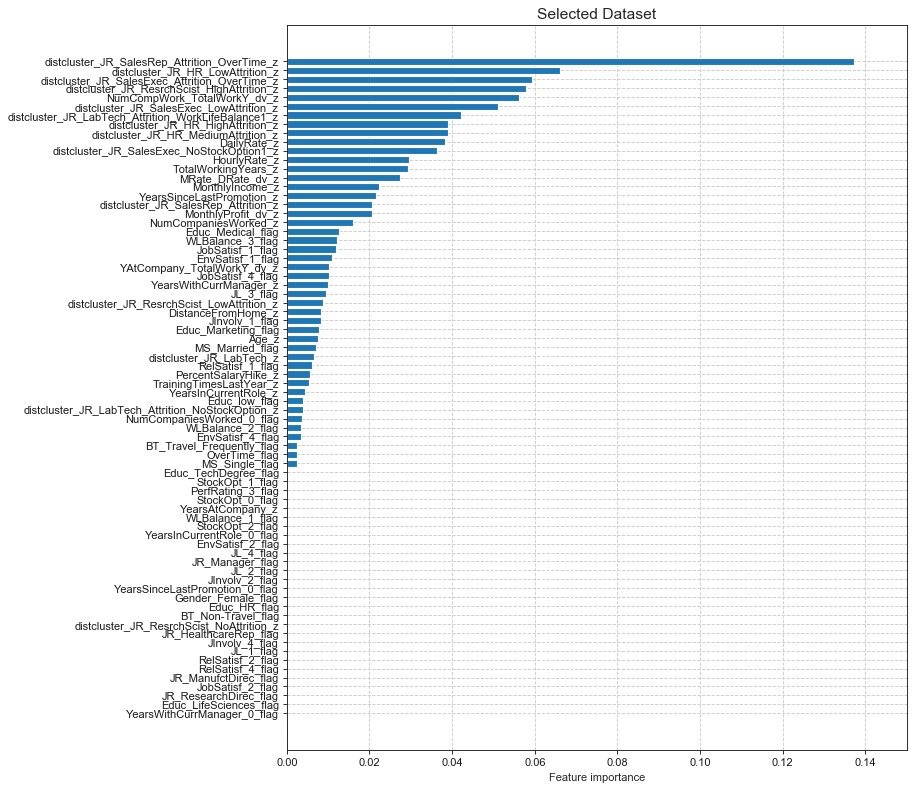

In [21]:
figure_FeatureImp_ = fPlots.f_feature_importances(modelDT, data, dataset_str, 10, 12, .15)
plt.show(figure_FeatureImp_)

Somehow we can observe that there are 2 groups of features according to their relevance as returned by the decision tree classifier:

- <b>Group 1</b> (Inclusive Model): All variables with a feature importance greater than 0 from the simple decision tree classifier were selected (total of 54);

- <b>Group 2</b> All the variables were considered (total of 74).

In [22]:
df_features = pd.Series(modelDT.feature_importances_, index = data.columns)

In [23]:
# build some list to append the model metrics (for model comparison afterwards)
model_cmp = []
model_cmp_type = []
model_cmp_sampling = []
model_cmp_mean_pr_auc = []
model_cmp_mean_roc_auc = []
model_cmp_mean_f_score_train_0 = []
model_cmp_mean_f_score_test_0 = []
model_cmp_mean_f_score_train_1 = []
model_cmp_mean_f_score_test_1 = []
model_cmp_mean_accuracy_train = []
model_cmp_mean_accuracy_test = []
model_cmp_mean_precision_train = []
model_cmp_mean_precision_test = []
model_cmp_mean_recall_train = []
model_cmp_mean_recall_test = []
model_cmp_train_elapsedtime_ms = []

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model1"></a>
### 4.2: Inclusive Model

In [24]:
list_vars = df_features[df_features > 0].index
nvars = len(list_vars)
modelvars_str = 'IncModel'

<b>Input Variables</b>: 

In [25]:
list_vars

Index(['MonthlyIncome_z', 'Age_z', 'DistanceFromHome_z',
       'NumCompaniesWorked_z', 'PercentSalaryHike_z', 'TotalWorkingYears_z',
       'TrainingTimesLastYear_z', 'YearsInCurrentRole_z',
       'YearsSinceLastPromotion_z', 'YearsWithCurrManager_z',
       'MRate_DRate_dv_z', 'YAtCompany_TotalWorkY_dv_z',
       'NumCompWork_TotalWorkY_dv_z', 'DailyRate_z', 'HourlyRate_z',
       'MonthlyProfit_dv_z', 'distcluster_JR_SalesRep_Attrition_z',
       'distcluster_JR_SalesRep_Attrition_OverTime_z',
       'distcluster_JR_LabTech_z',
       'distcluster_JR_LabTech_Attrition_NoStockOption_z',
       'distcluster_JR_LabTech_Attrition_WorkLifeBalance1_z',
       'distcluster_JR_HR_MediumAttrition_z',
       'distcluster_JR_HR_LowAttrition_z', 'distcluster_JR_HR_HighAttrition_z',
       'distcluster_JR_SalesExec_NoStockOption1_z',
       'distcluster_JR_SalesExec_LowAttrition_z',
       'distcluster_JR_SalesExec_Attrition_OverTime_z',
       'distcluster_JR_ResrchScist_HighAttrition_z',
    

<a class="anchor" id="model1_sampling-kfold"></a>
#### 4.2.1: Sampling: Stratified k-Fold Cross-Validation

In [26]:
sampling_str = 'k-fold cv'

In [27]:
target_list = target.values
data = df_model[list_vars].values

skf = StratifiedKFold(n_splits = 5, shuffle = False)
skf.get_n_splits(target, data)

theoretical_thresholds = []
cv = 0
for train_index, test_index in skf.split(data, target):
    exec('X_train_' + str(cv) + ', ' + 'X_test_' + str(cv) + ' = data[train_index], data[test_index]')
    exec('y_train_' + str(cv) + ', ' + 'y_test_' + str(cv) + ' = target[train_index], target[test_index]')
    exec('theoretical_thresholds.append(np.count_nonzero(y_train_' + str(cv) + \
                                                      '== 1)/(np.count_nonzero(y_train_' + str(cv) + '== 0) + ' +\
                         'np.count_nonzero(y_train_' + str(cv) + '==1)))')
    cv = cv + 1

n_cv = cv

In [28]:
theoretical_threshold = np.mean(theoretical_thresholds)
print('theoretical threshold: ', '{:.2f}'.format(theoretical_threshold))

theoretical threshold:  0.16


[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model1_sampling-kfold-KNN"></a>
##### 4.2.1.1: K-Nearest Neighbours

In [29]:
model_cmp.append(nvars)
model_str = 'KNN_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)

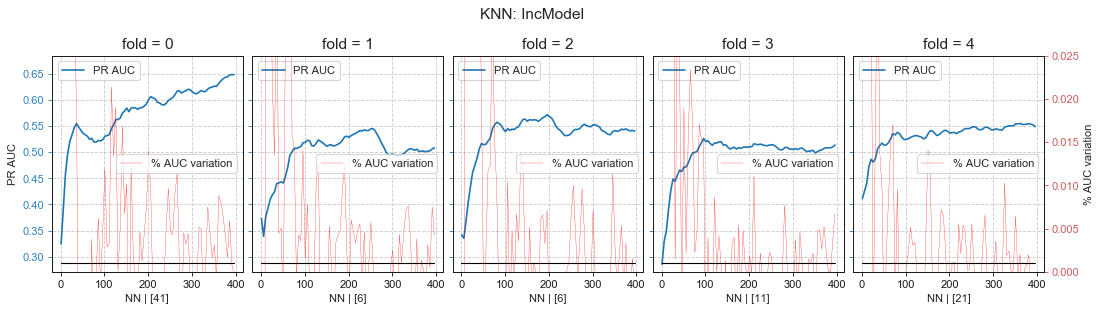

In [30]:
# test k NN (number of Nearest Neighbours)
if(test_bool):
    figmodelKNNs = f_model_KNN_test(400, 5, model_str.split('_')[0] + ': ' + modelvars_str , 0.5, model_eval_curve)
    plt.show(figmodelKNNs)

Looking at these plots let's choose K = 350.

In [31]:
k = 350

In [32]:
# build the models (only after testing for the hyperparameters)
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = KNeighborsClassifier(n_neighbors = k)')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + \
         'y_train_' + str(cv) + ')')
    
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [33]:
beta = beta_global

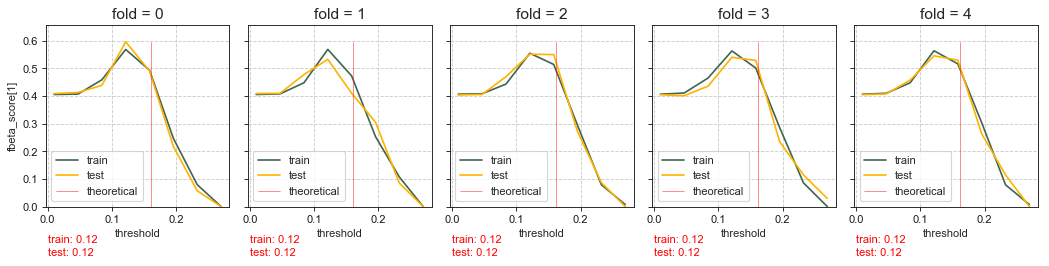

In [34]:
# select the threshold to maximize the metric
figmodelKNNs_thresholds, KNNs_best_threshold_train, KNNs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelKNNs_thresholds)

In [35]:
selected_threshold = mean(KNNs_best_threshold_train)
print('{:.2f}'.format(mean(KNNs_best_threshold_train)))

0.12


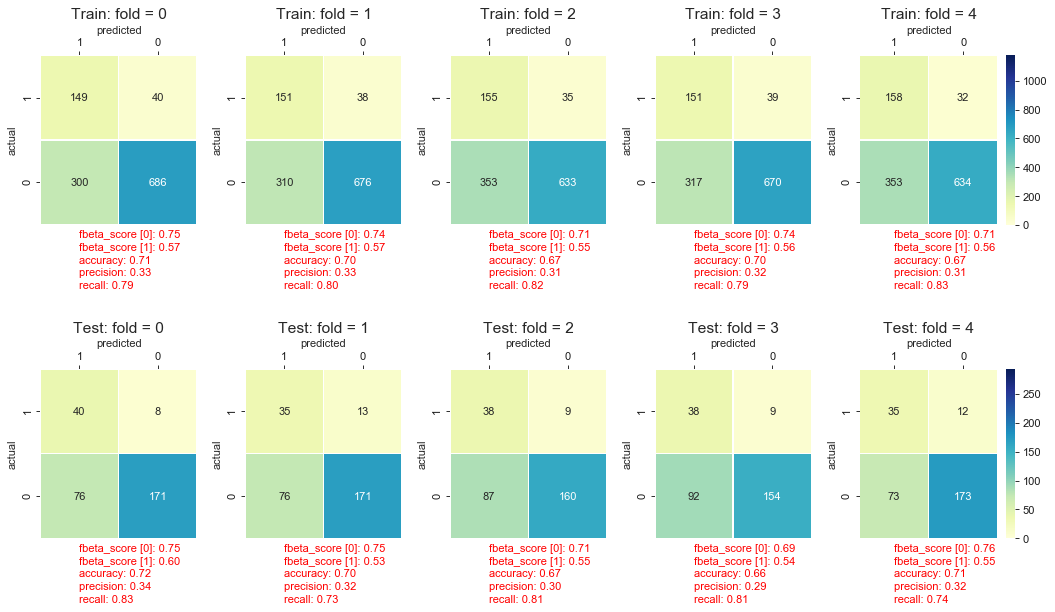

In [36]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelKNNs_CM, f_score_train_KNNs, f_score_test_KNNs, accuracy_train_KNNs, accuracy_test_KNNs, \
precision_train_KNNs, precision_test_KNNs, recall_train_KNNs, recall_test_KNNs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelKNNs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_KNNs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_KNNs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_KNNs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_KNNs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_KNNs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_KNNs))
model_cmp_mean_precision_train.append(mean(precision_train_KNNs))
model_cmp_mean_precision_test.append(mean(precision_test_KNNs))
model_cmp_mean_recall_train.append(mean(recall_train_KNNs))
model_cmp_mean_recall_test.append(mean(recall_test_KNNs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.256
recall: 0.17 | precision: 0.80 | threshold: 0.206
recall: 0.55 | precision: 0.52 | threshold: 0.155
recall: 0.88 | precision: 0.22 | threshold: 0.098


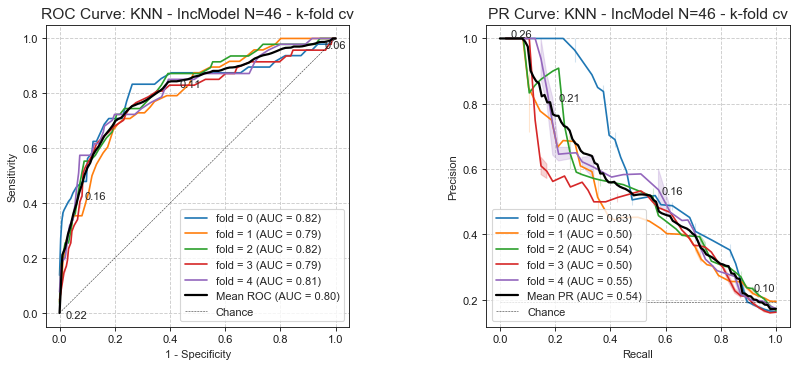

In [37]:
# plot the ROC Curve & PR Curve
figmodelKNNs_ROC, KNNs_mean_roc_auc, KNNs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars, \
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)

plt.show(figmodelKNNs_ROC)
model_cmp_mean_roc_auc.append(KNNs_mean_roc_auc)
model_cmp_mean_pr_auc.append(KNNs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model1_sampling-kfold-NN"></a>
##### 4.2.1.2: Neural Networks

In [38]:
model_cmp.append(nvars)
model_str = 'NN_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)
n_hidden = 1

<b>Test the learning rate ...</b>

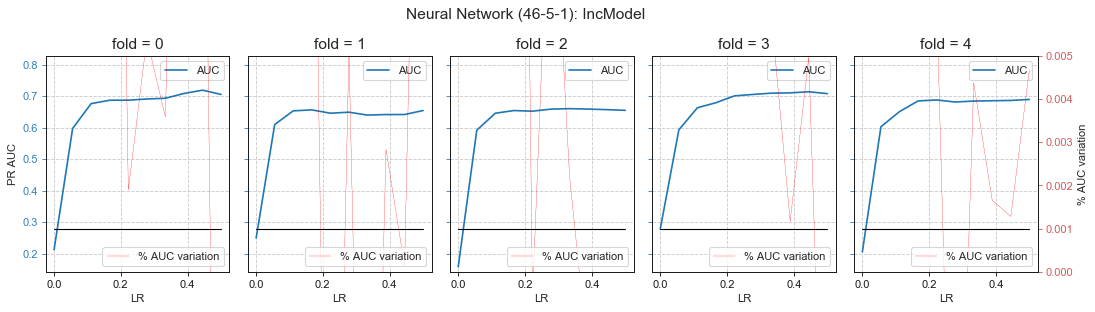

In [39]:
# test Learning Rate
if(test_bool):
    figmodelNNs_LRsk = f_model_NN_testLR(0.001, 0.5, 10, 250, 5, n_hidden, nvars, modelvars_str, 0.1, model_eval_curve)
    plt.show(figmodelNNs_LRsk)

Looking at these plots let's choose learning_rate_init = 0.15.

In [40]:
LR = .15

<b>Test the network architecture ...</b>

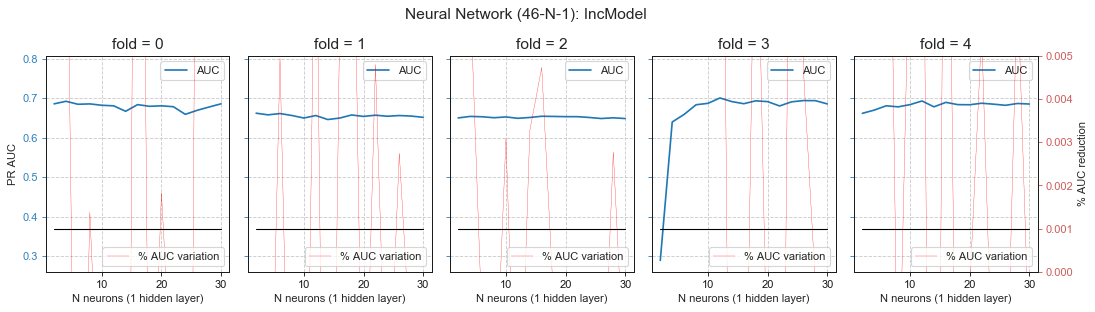

In [41]:
# test Network Architecture
if(test_bool):
    figmodelNNs_N = f_model_NN_testNeurons(LR, 2, 32, 2, 250, n_hidden, nvars, modelvars_str, 0.1, model_eval_curve)
    plt.show(figmodelNNs_N)

Looking at these plots let's choose 8 for the number of neurons on a single hidden layer.

In [42]:
n_neurons = 8

In [43]:
# build the models
start_time = time.time()
for cv in range(n_cv):
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '= MLPClassifier(solver = ' + '\'' + 'sgd' + '\'' +\
         ', activation = ' + '\'' + 'logistic' + '\'' + ', max_iter = 350,' +\
         'learning_rate = ' + '\'' + 'adaptive' + '\'' + ', learning_rate_init = LR,\
         random_state = None, shuffle = True, momentum = .9,\
         hidden_layer_sizes = tuple([n_neurons for h in range(n_hidden)]),\
         n_iter_no_change = 3, tol = 1e-3)')
    
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + \
         'y_train_' + str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [44]:
beta = beta_global

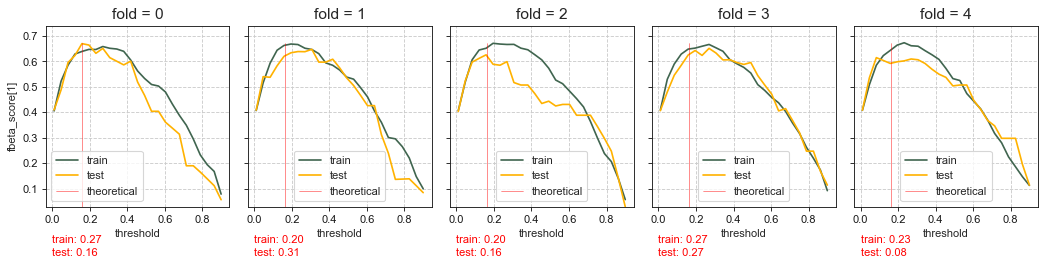

In [45]:
# select the threshold to maximize the metric
figmodelNNs_thresholds, NNs_best_threshold_train, NNs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelNNs_thresholds)

In [46]:
selected_threshold = mean(NNs_best_threshold_train)
print('{:.2f}'.format(mean(NNs_best_threshold_train)))

0.23


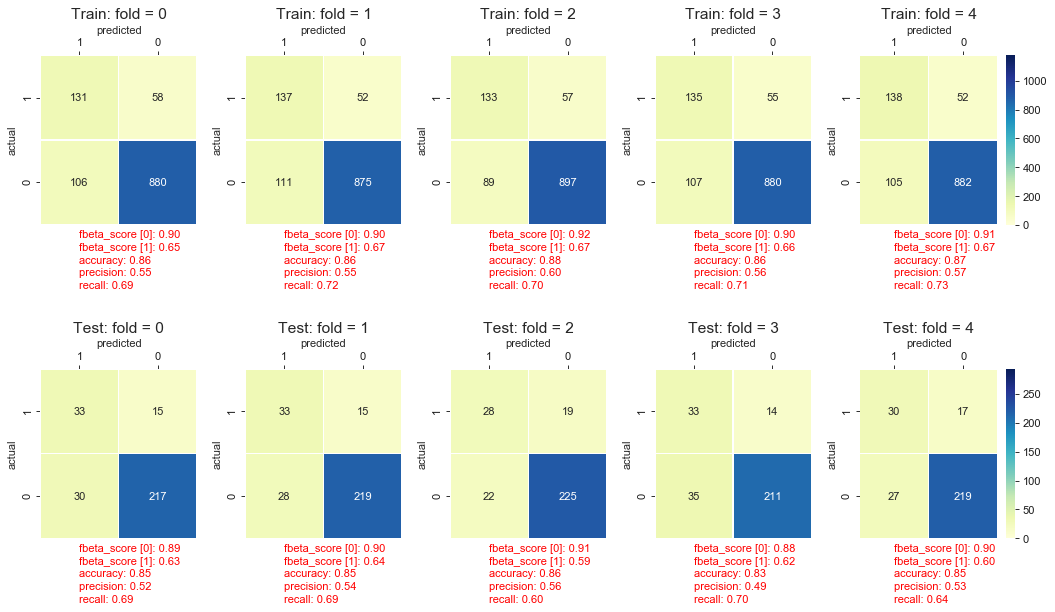

In [47]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelNNs_CM, f_score_train_NNs, f_score_test_NNs, accuracy_train_NNs, accuracy_test_NNs, \
precision_train_NNs, precision_test_NNs, recall_train_NNs, recall_test_NNs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelNNs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_NNs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_NNs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_NNs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_NNs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_NNs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_NNs))
model_cmp_mean_precision_train.append(mean(precision_train_NNs))
model_cmp_mean_precision_test.append(mean(precision_test_NNs))
model_cmp_mean_recall_train.append(mean(recall_train_NNs))
model_cmp_mean_recall_test.append(mean(recall_test_NNs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.944
recall: 0.08 | precision: 1.00 | threshold: 0.891
recall: 0.13 | precision: 0.92 | threshold: 0.830
recall: 0.20 | precision: 0.95 | threshold: 0.775
recall: 0.26 | precision: 0.93 | threshold: 0.720
recall: 0.31 | precision: 0.90 | threshold: 0.670
recall: 0.34 | precision: 0.86 | threshold: 0.617
recall: 0.38 | precision: 0.81 | threshold: 0.547
recall: 0.45 | precision: 0.74 | threshold: 0.476
recall: 0.54 | precision: 0.71 | threshold: 0.416
recall: 0.57 | precision: 0.65 | threshold: 0.356
recall: 0.61 | precision: 0.63 | threshold: 0.303
recall: 0.67 | precision: 0.53 | threshold: 0.236
recall: 0.73 | precision: 0.48 | threshold: 0.181
recall: 0.79 | precision: 0.40 | threshold: 0.129
recall: 0.86 | precision: 0.29 | threshold: 0.069
recall: 1.00 | precision: 0.18 | threshold: 0.019


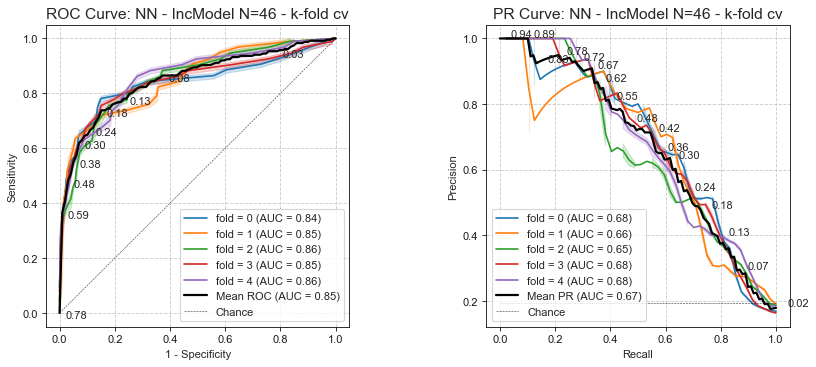

In [48]:
# plot the ROC Curve & PR Curve
figmodelNNs_ROC, NNs_mean_roc_auc, NNs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelNNs_ROC)
model_cmp_mean_roc_auc.append(NNs_mean_roc_auc)
model_cmp_mean_pr_auc.append(NNs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model1_sampling-kfold-DL"></a>
##### 4.2.1.3: Deep Learning (KERAS)

In [49]:
model_cmp.append(nvars)
model_str = 'DL_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)

In [50]:
n_hidden = [32,16]
epochs_max = 20

<b>Test the optimizer, including the learning rate (for a given network architecture) ...</b>

fold 0 | LR = 0.00100 | val loss:
['0.372', '0.357', '0.338', '0.332', '0.345', '0.327', '0.331', '0.329', '0.327']
fold 0 | LR = 0.00271 | val loss:
['0.322', '0.419', '0.314', '0.306', '0.322', '0.305', '0.308']
fold 0 | LR = 0.00443 | val loss:
['0.323', '0.321', '0.383', '0.320']
fold 0 | LR = 0.00614 | val loss:
['0.302', '0.311', '0.363', '0.327']

fold 1 | LR = 0.00100 | val loss:
['0.399', '0.377', '0.338', '0.317', '0.319', '0.307', '0.316']
fold 1 | LR = 0.00271 | val loss:
['0.344', '0.315', '0.321', '0.295', '0.296', '0.298', '0.313']
fold 1 | LR = 0.00443 | val loss:
['0.298', '0.327', '0.331', '0.302']
fold 1 | LR = 0.00614 | val loss:
['0.313', '0.319', '0.318', '0.324']

fold 2 | LR = 0.00100 | val loss:
['0.412', '0.371', '0.346', '0.332', '0.337', '0.327', '0.321', '0.322', '0.318', '0.316']
fold 2 | LR = 0.00271 | val loss:
['0.340', '0.330', '0.407', '0.320', '0.315', '0.315', '0.308', '0.309', '0.307', '0.308']
fold 2 | LR = 0.00443 | val loss:
['0.308', '0.338', '

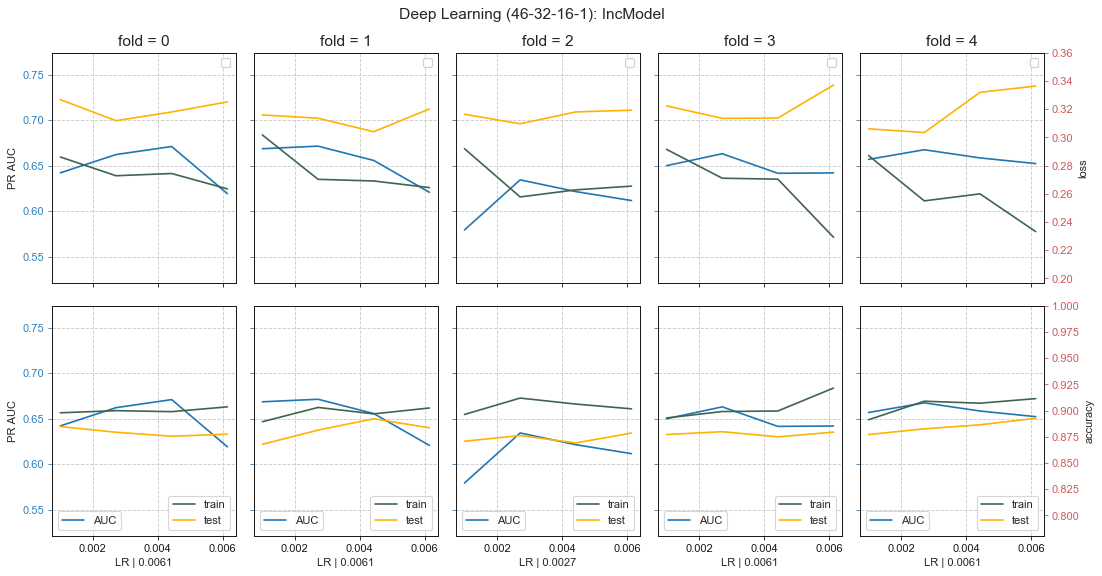

In [51]:
# test the LR
if(test_bool):
    figmodelDL_LR = f_model_DL_LR(0.001, 0.025, 15, epochs_max, n_hidden, nvars, modelvars_str, 0.2, model_eval_curve)
    plt.show(figmodelDL_LR)

Looking at these values let's choose Learning Rate = 0.0044

In [52]:
LR = .0044

<b>Test the epochs (for a given network architecture) ...</b>

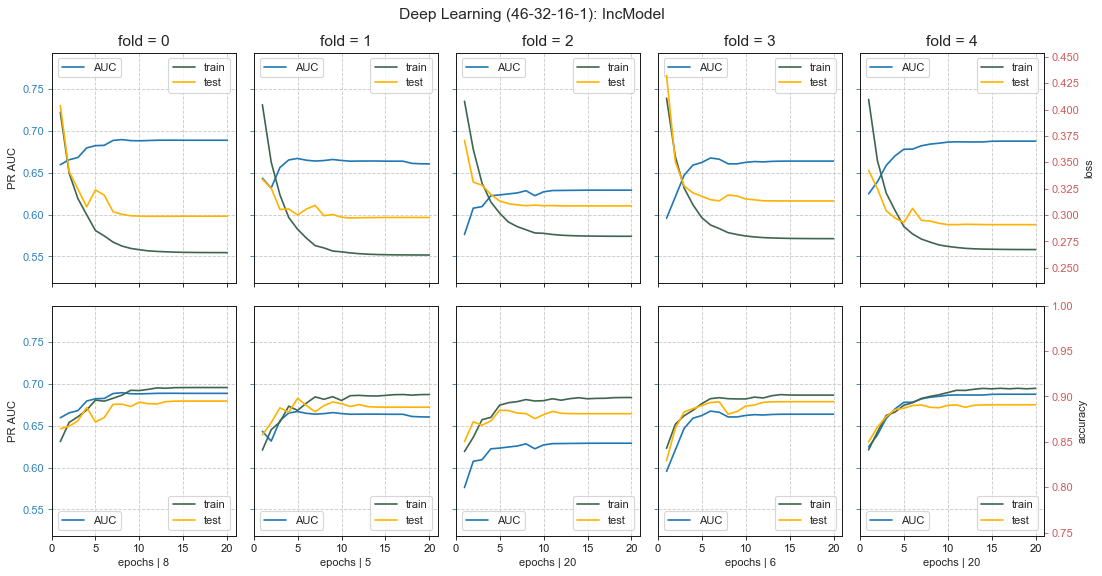

In [53]:
# test the epochs
if(test_bool):
    figmodelDL_epochs = f_model_DL_epochs(epochs_max, n_hidden, nvars, LR, modelvars_str, .2, model_eval_curve)
    plt.show(figmodelDL_epochs)

Looking at these plots let's choose epochs = 8

In [54]:
epochs = 8

In [55]:
# build the models
start_time = time.time()
# define the Learning Rate (inside the optimizer) 
def lr_scheduler(epoch, lr):
    return lr*10**(np.log10(0.01)/(epochs_max/2)) # reduce initial LR 100 times when the epochs = epochs_max / 2

# build the models (only after testing for the hyperparameters)
for cv in range(n_cv): 
    print('cv: ' + str(cv) + ' | LR = ' + '{:.5f}'.format(LR))
    # define the architecture of the network
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = models.Sequential()')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.add(layers.Dense(n_hidden[0], activation = ' + 
         '\'' + 'relu' + '\'' + ', input_dim = nvars))') # add the first hidden layer
    for h in range(1, len(n_hidden)): # add the remaining hidden layers
        exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.add(layers.Dense(n_hidden[h], activation = ' + \
             '\'' + 'relu' +  '\'' + '))')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.add(layers.Dense(1, activation = '+ '\'' + \
         'sigmoid' + '\'' + '))') # add the output layer
    
    optm = optimizers.SGD(learning_rate = LR, momentum = .9, nesterov = False)
    lr_decay = callbacks.LearningRateScheduler(lr_scheduler, verbose = 0)
    
    # compile the model
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.compile(optimizer = optm, loss = ' + '\'' + \
         'binary_crossentropy' + '\'' + ', metrics = [' + '\'' + 'accuracy' + '\'' + '])')

    # train the model
    exec('output_history_' + str(cv) + '_' + str(nvars) + ' = OutputObserver(X_test_' + str(cv) + ')')
    exec('historymodelDL_' + str(cv) + '_' + str(nvars) + ' = model' + model_str + '_' + str(cv) + '_' + str(nvars) + \
         '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ', validation_data = (X_test_' + str(cv) + \
         ',' + ' y_test_' + str(cv) + ')' + ', epochs = ' + str(epochs) + \
         ', batch_size = 1, verbose = 1, shuffle = True, callbacks = [output_history_' + \
         str(cv) + '_' + str(nvars) + ', lr_decay])')
    print('')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

cv: 0 | LR = 0.00440
Train on 1175 samples, validate on 295 samples
Epoch 1/8
1175/1175 [==============================] - 1s 1ms/step - loss: 0.4130 - accuracy: 0.8409 - val_loss: 0.3838 - val_accuracy: 0.8712
Epoch 2/8
1175/1175 [==============================] - 1s 1ms/step - loss: 0.3413 - accuracy: 0.8638 - val_loss: 0.3274 - val_accuracy: 0.8746
Epoch 3/8
1175/1175 [==============================] - 1s 1ms/step - loss: 0.3064 - accuracy: 0.8877 - val_loss: 0.3161 - val_accuracy: 0.8915
Epoch 4/8
1175/1175 [==============================] - 1s 1ms/step - loss: 0.2988 - accuracy: 0.8817 - val_loss: 0.3259 - val_accuracy: 0.8678
Epoch 5/8
1175/1175 [==============================] - 1s 1ms/step - loss: 0.2878 - accuracy: 0.8987 - val_loss: 0.3059 - val_accuracy: 0.8915
Epoch 6/8
1175/1175 [==============================] - 1s 1ms/step - loss: 0.2812 - accuracy: 0.8987 - val_loss: 0.3148 - val_accuracy: 0.8814
Epoch 7/8
1175/1175 [==============================] - 1s 1ms/step - loss:

In [56]:
beta = beta_global

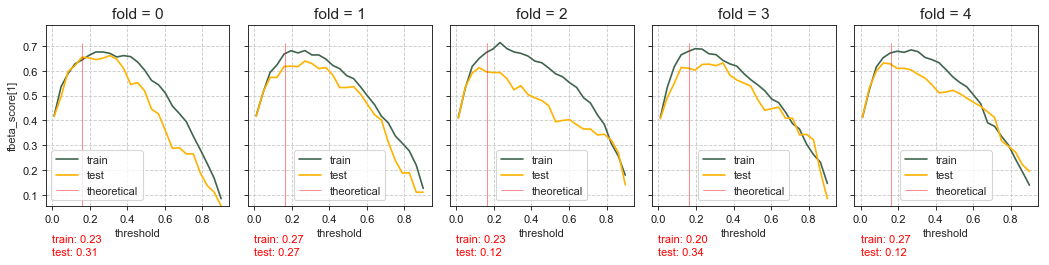

In [57]:
# select the threshold to maximize the metric
figmodelDL_thresholds, DL_best_threshold_train, DL_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelDL_thresholds)

In [58]:
selected_threshold = mean(DL_best_threshold_train)
print('{:.2f}'.format(mean(DL_best_threshold_train)))

0.24


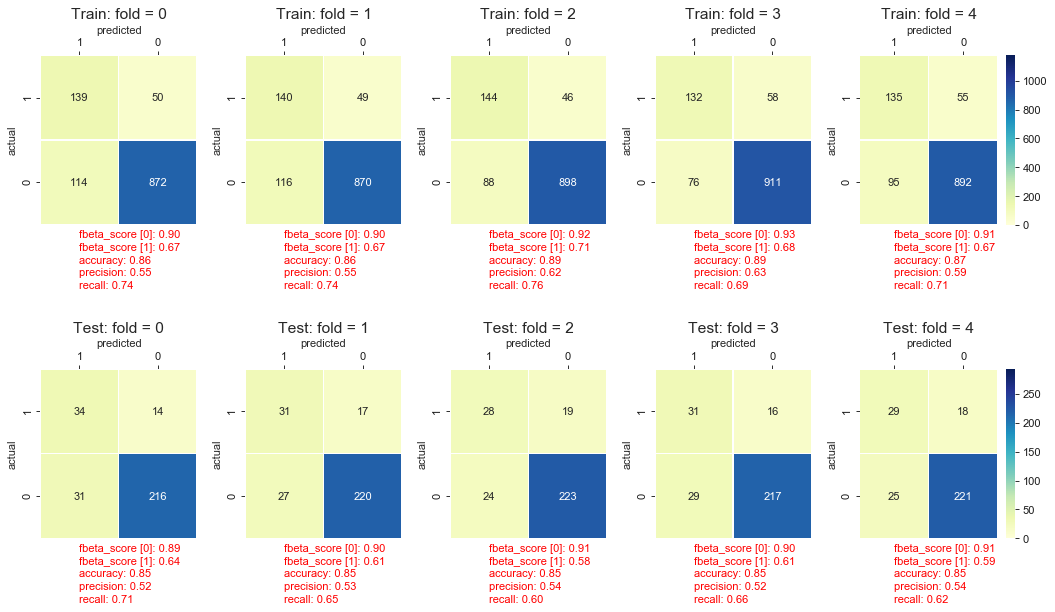

In [59]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelDLs_CM, f_score_train_DLs, f_score_test_DLs, accuracy_train_DLs, accuracy_test_DLs, \
precision_train_DLs, precision_test_DLs, recall_train_DLs, recall_test_DLs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelDLs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_DLs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_DLs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_DLs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_DLs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_DLs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_DLs))
model_cmp_mean_precision_train.append(mean(precision_train_DLs))
model_cmp_mean_precision_test.append(mean(precision_test_DLs))
model_cmp_mean_recall_train.append(mean(recall_train_DLs))
model_cmp_mean_recall_test.append(mean(recall_test_DLs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.961
recall: 0.07 | precision: 1.00 | threshold: 0.910
recall: 0.13 | precision: 0.95 | threshold: 0.859
recall: 0.22 | precision: 0.93 | threshold: 0.800
recall: 0.27 | precision: 0.91 | threshold: 0.747
recall: 0.30 | precision: 0.87 | threshold: 0.690
recall: 0.35 | precision: 0.83 | threshold: 0.629
recall: 0.38 | precision: 0.78 | threshold: 0.573
recall: 0.43 | precision: 0.77 | threshold: 0.523
recall: 0.47 | precision: 0.73 | threshold: 0.464
recall: 0.52 | precision: 0.65 | threshold: 0.393
recall: 0.59 | precision: 0.61 | threshold: 0.327
recall: 0.65 | precision: 0.54 | threshold: 0.259
recall: 0.70 | precision: 0.48 | threshold: 0.198
recall: 0.77 | precision: 0.41 | threshold: 0.144
recall: 0.86 | precision: 0.28 | threshold: 0.065


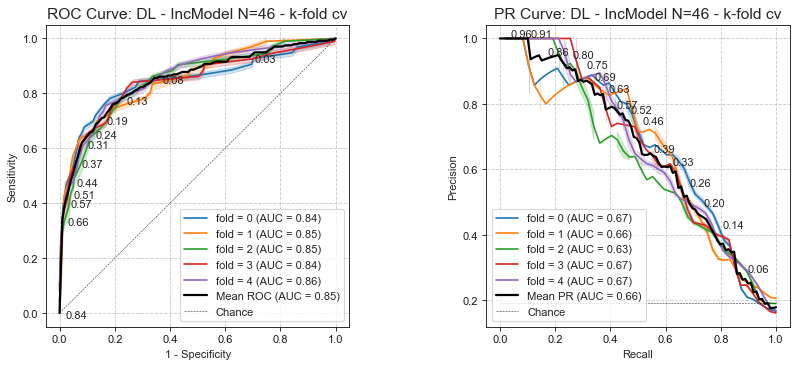

In [60]:
# plot the ROC Curve & PR Curve
figmodelDLs_ROC, DLs_mean_roc_auc, DLs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelDLs_ROC)
model_cmp_mean_roc_auc.append(DLs_mean_roc_auc)
model_cmp_mean_pr_auc.append(DLs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model1_sampling-kfold-LogReg"></a>
##### 4.2.1.4: Logistic Regression

In [61]:
model_cmp.append(nvars)
model_str = 'LogReg_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)
nmax_iter = 300

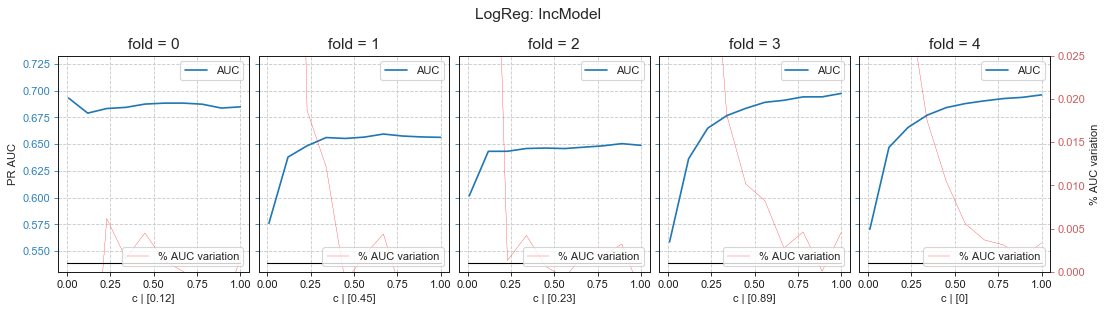

In [62]:
# test c (Inverse of regularization strength)
if(test_bool):
    figmodelLogRegs = f_model_LogReg_test(nmax_iter, 10, model_str.split('_')[0] + ': ' + modelvars_str,\
                                          0.1, model_eval_curve)
    plt.show(figmodelLogRegs)

Looking at these plots let's choose c = 0.75.

In [63]:
c = 0.75

In [64]:
# build the models (only after testing for the hyperparameters)
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = LogisticRegression(penalty = ' + '\'' + 'l2' + \
         '\'' + ', dual = False, tol = 1e-4, C = '+ '{:.2f}'.format(c) + \
         ', fit_intercept = True, intercept_scaling = 1,' + \
         'class_weight = None, random_state = None, solver = ' + '\'' + 'liblinear' + '\'' +', max_iter = ' + \
         str(nmax_iter) + ', verbose = 0, warm_start = True)')

    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + \
         'y_train_' + \
         str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [65]:
beta = beta_global

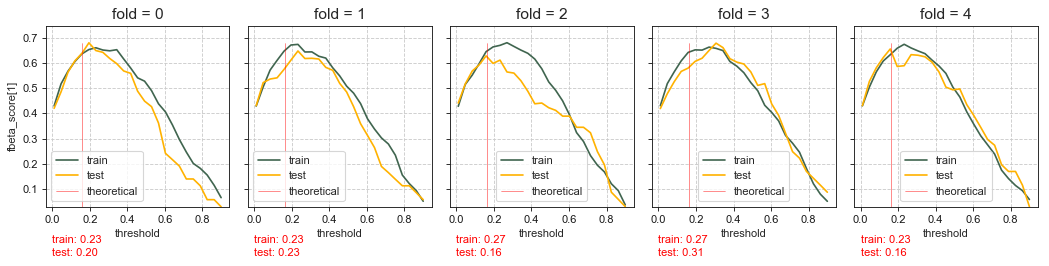

In [66]:
# select the threshold to maximize the metric
figmodelLogRegs_thresholds, LogRegs_best_threshold_train, LogRegs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelLogRegs_thresholds)

In [67]:
selected_threshold = mean(LogRegs_best_threshold_train)
print('{:.2f}'.format(mean(LogRegs_best_threshold_train)))

0.25


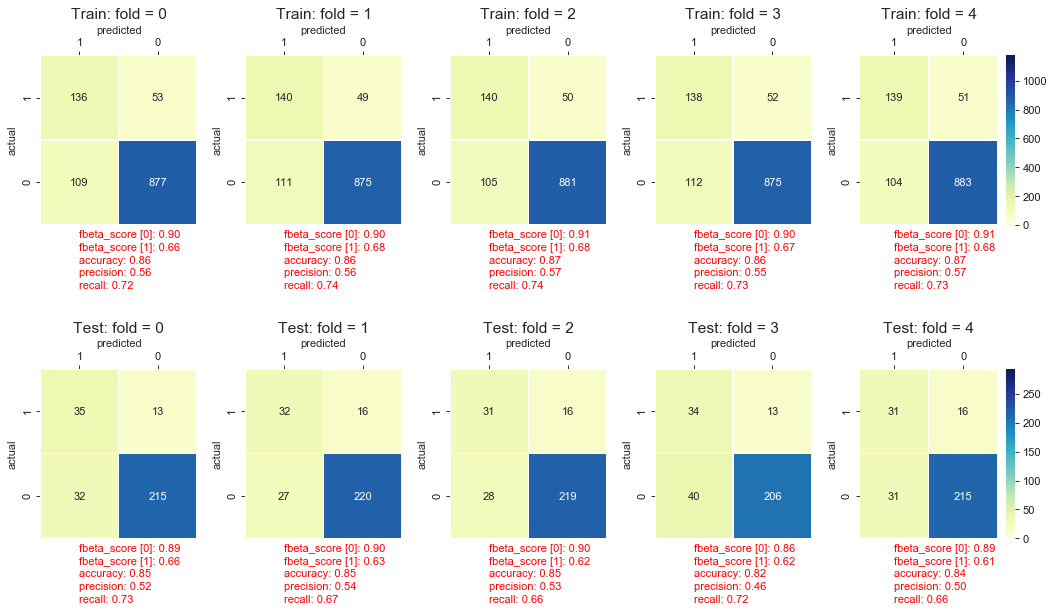

In [68]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelLogRegs_CM, f_score_train_LogRegs, f_score_test_LogRegs, accuracy_train_LogRegs, accuracy_test_LogRegs, \
precision_train_LogRegs, precision_test_LogRegs, recall_train_LogRegs, recall_test_LogRegs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelLogRegs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_LogRegs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_LogRegs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_LogRegs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_LogRegs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_LogRegs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_LogRegs))
model_cmp_mean_precision_train.append(mean(precision_train_LogRegs))
model_cmp_mean_precision_test.append(mean(precision_test_LogRegs))
model_cmp_mean_recall_train.append(mean(recall_train_LogRegs))
model_cmp_mean_recall_test.append(mean(recall_test_LogRegs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.942
recall: 0.05 | precision: 1.00 | threshold: 0.888
recall: 0.09 | precision: 1.00 | threshold: 0.833
recall: 0.12 | precision: 0.97 | threshold: 0.782
recall: 0.17 | precision: 0.94 | threshold: 0.726
recall: 0.22 | precision: 0.92 | threshold: 0.675
recall: 0.28 | precision: 0.91 | threshold: 0.622
recall: 0.34 | precision: 0.91 | threshold: 0.571
recall: 0.38 | precision: 0.84 | threshold: 0.520
recall: 0.44 | precision: 0.78 | threshold: 0.468
recall: 0.52 | precision: 0.73 | threshold: 0.413
recall: 0.58 | precision: 0.65 | threshold: 0.355
recall: 0.63 | precision: 0.59 | threshold: 0.304
recall: 0.70 | precision: 0.52 | threshold: 0.251
recall: 0.74 | precision: 0.44 | threshold: 0.194
recall: 0.82 | precision: 0.36 | threshold: 0.132
recall: 0.88 | precision: 0.27 | threshold: 0.074
recall: 0.96 | precision: 0.19 | threshold: 0.021


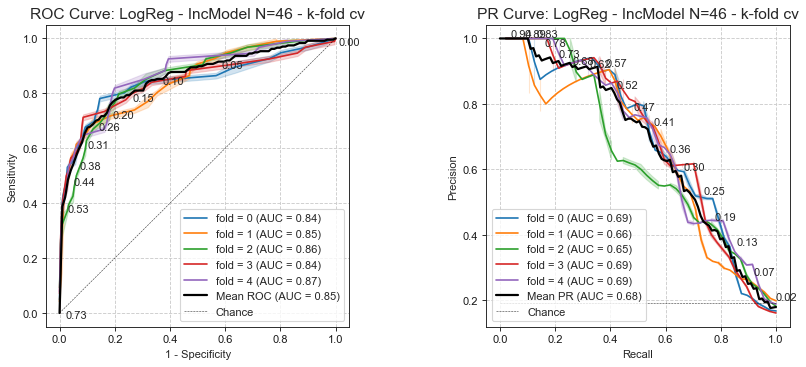

In [69]:
# plot the ROC Curve & PR Curve
figmodelLogRegs_ROC, LogRegs_mean_roc_auc, LogRegs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelLogRegs_ROC)
model_cmp_mean_roc_auc.append(LogRegs_mean_roc_auc)
model_cmp_mean_pr_auc.append(LogRegs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model1_sampling-kfold-NBayes"></a>
##### 4.2.1.5: Naive Bayes

In [70]:
model_cmp.append(nvars)
model_str = 'NBayes_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)

In [71]:
# build the models 
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = GaussianNB()')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + \
         'y_train_' + \
         str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [72]:
beta = beta_global

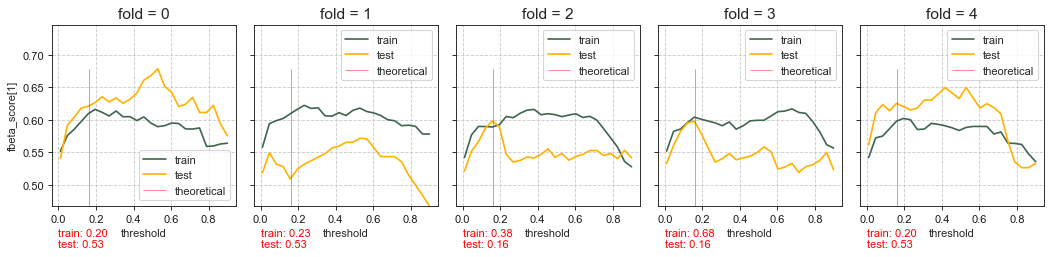

In [73]:
# select the threshold to maximize the metric
figmodelNBayes_thresholds, NBayes_best_threshold_train, NBayes_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelNBayes_thresholds)

In [74]:
selected_threshold = mean(NBayes_best_threshold_train)
print('{:.2f}'.format(mean(NBayes_best_threshold_train)))

0.34


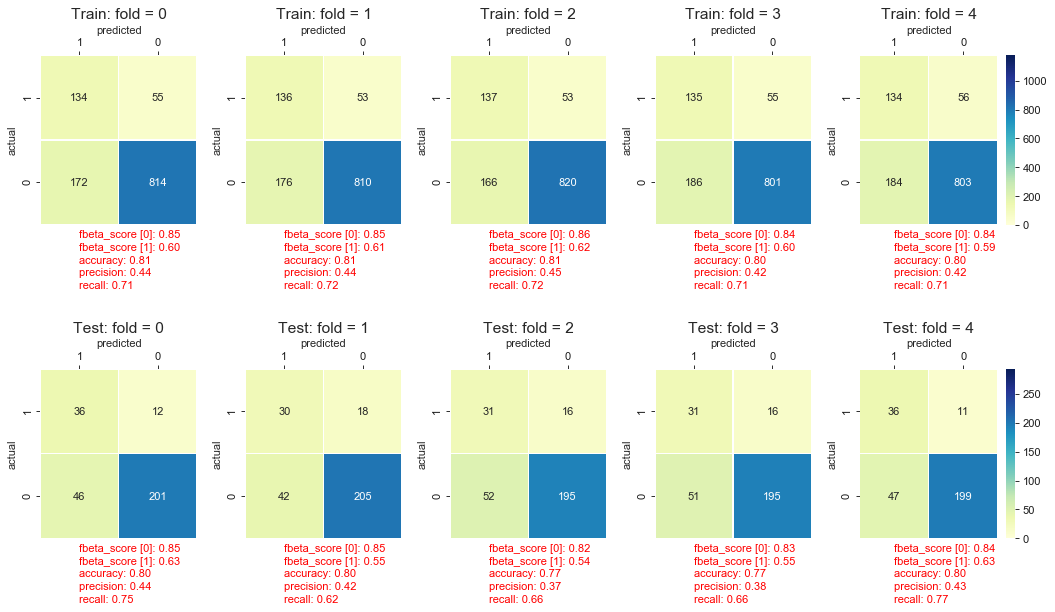

In [75]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelNBayes_CM, f_score_train_NBayes, f_score_test_NBayes, accuracy_train_NBayes, accuracy_test_NBayes, \
precision_train_NBayes, precision_test_NBayes, recall_train_NBayes, recall_test_NBayes = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelNBayes_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_NBayes[0])
model_cmp_mean_f_score_train_1.append(f_score_train_NBayes[1])
model_cmp_mean_f_score_test_0.append(f_score_test_NBayes[0])
model_cmp_mean_f_score_test_1.append(f_score_test_NBayes[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_NBayes))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_NBayes))
model_cmp_mean_precision_train.append(mean(precision_train_NBayes))
model_cmp_mean_precision_test.append(mean(precision_test_NBayes))
model_cmp_mean_recall_train.append(mean(recall_train_NBayes))
model_cmp_mean_recall_test.append(mean(recall_test_NBayes))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 1.000
recall: 0.46 | precision: 0.65 | threshold: 0.948
recall: 0.51 | precision: 0.59 | threshold: 0.897
recall: 0.54 | precision: 0.57 | threshold: 0.847
recall: 0.56 | precision: 0.54 | threshold: 0.790
recall: 0.58 | precision: 0.53 | threshold: 0.723
recall: 0.60 | precision: 0.52 | threshold: 0.667
recall: 0.63 | precision: 0.47 | threshold: 0.522
recall: 0.65 | precision: 0.44 | threshold: 0.447
recall: 0.67 | precision: 0.42 | threshold: 0.377
recall: 0.72 | precision: 0.43 | threshold: 0.325
recall: 0.75 | precision: 0.41 | threshold: 0.271
recall: 0.77 | precision: 0.36 | threshold: 0.167
recall: 0.80 | precision: 0.34 | threshold: 0.084
recall: 0.86 | precision: 0.26 | threshold: 0.013


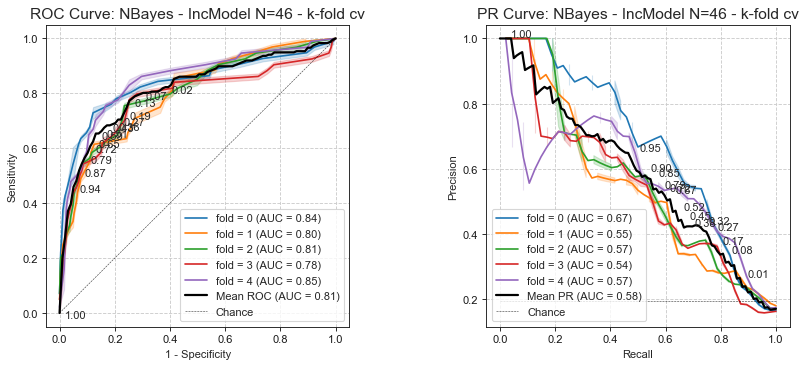

In [76]:
# plot the ROC Curve & PR Curve
figmodelNBayes_ROC, NBayes_mean_roc_auc, NBayes_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelNBayes_ROC)
model_cmp_mean_roc_auc.append(NBayes_mean_roc_auc)
model_cmp_mean_pr_auc.append(NBayes_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model1_sampling-SMOTENC_1"></a>
#### 4.2.2: Stratified k-Fold Cross-Validation + Oversampling: SMOTENC (R=0.3)

In [77]:
sampling_str = 'SMOTENC (R=0.3)'
sampling_strategy = 0.3

In [78]:
target_list = target.values
data = df_model[list_vars].values

categorical_idx = []
idx = 0
for var in df_model[list_vars].columns:
    if('_flag' in var):
        categorical_idx.append(idx)
    idx = idx + 1
categorical_idx

skf = StratifiedKFold(n_splits = 5, shuffle = False)
skf.get_n_splits(target, data)

cv = 0
theoretical_thresholds = []
for train_index, test_index in skf.split(data, target):
    print('k-fold: ' + str(cv))
    # standard k-fold cross validation
    exec('X_train_' + str(cv) + ', ' + 'X_test_' + str(cv) + ' = data[train_index], data[test_index]')
    exec('y_train_' + str(cv) + ', ' + 'y_test_' + str(cv) + ' = target[train_index], target[test_index]')
    
    print('original unbalance ratio: ' + '{:.2f}'.format(eval('np.count_nonzero(y_train_' + str(cv) + \
                                                          '==1)/np.count_nonzero(y_train_' + str(cv) + '==0)')))
    print('train samples = ' + str(eval('len(y_train_' + str(cv) + ')')))
    
    # apply the oversampling technique (only on the training data ... for each fold)
    sampler = SMOTENC(sampling_strategy = sampling_strategy, categorical_features = categorical_idx, \
                  k_neighbors = oversampling_k)
    exec('X_train_' + str(cv) +', ' + 'y_train_' + str(cv) + ' = sampler.fit_resample(' + 'X_train_' + str(cv) + \
         ', ' + 'y_train_' + str(cv) + ')')
    print('oversampling unbalance ratio: ' + '{:.2f}'.format(eval('np.count_nonzero(y_train_' + str(cv) + \
                                                          '==1)/np.count_nonzero(y_train_' + str(cv) + '==0)')))
    
    exec('theoretical_thresholds.append(np.count_nonzero(y_train_' + str(cv) + \
                                                          '== 1)/(np.count_nonzero(y_train_' + str(cv) + '== 0) + ' +\
                             'np.count_nonzero(y_train_' + str(cv) + '==1)))')

    print('train samples = ' + str(eval('len(y_train_' + str(cv) + ')')))
    print('')

    cv = cv + 1

n_cv = cv

k-fold: 0
original unbalance ratio: 0.19
train samples = 1175
oversampling unbalance ratio: 0.30
train samples = 1281

k-fold: 1
original unbalance ratio: 0.19
train samples = 1175
oversampling unbalance ratio: 0.30
train samples = 1281

k-fold: 2
original unbalance ratio: 0.19
train samples = 1176
oversampling unbalance ratio: 0.30
train samples = 1281

k-fold: 3
original unbalance ratio: 0.19
train samples = 1177
oversampling unbalance ratio: 0.30
train samples = 1283

k-fold: 4
original unbalance ratio: 0.19
train samples = 1177
oversampling unbalance ratio: 0.30
train samples = 1283



In [79]:
theoretical_threshold = np.mean(theoretical_thresholds)
print('theoretical threshold: ', '{:.2f}'.format(theoretical_threshold))

theoretical threshold:  0.23


[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model1_sampling-SMOTENC_1-KNN"></a>
##### 4.2.2.1: K-Nearest Neighbours

In [80]:
model_cmp.append(nvars)
model_str = 'KNN_SMOTENC_R1'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)

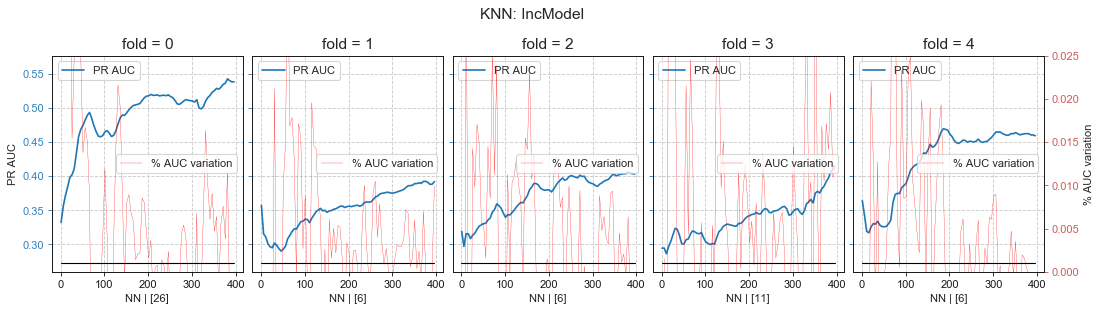

In [81]:
# test k NN (number of Nearest Neighbours)
if(test_bool):
    figmodelKNNs = f_model_KNN_test(400, 5, model_str.split('_')[0] + ': ' + modelvars_str, 0.5, model_eval_curve)
    plt.show(figmodelKNNs)

Looking at these plots let's choose K = 300.

In [82]:
k = 300

In [83]:
# build the models (only after testing for the hyperparameters)
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = KNeighborsClassifier(n_neighbors = k)')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [84]:
beta = beta_global

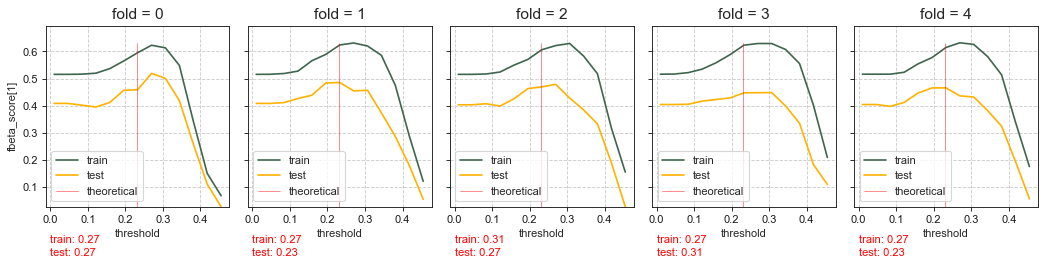

In [85]:
# select the threshold to maximize the metric
figmodelKNNs_thresholds, KNNs_best_threshold_train, KNNs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelKNNs_thresholds)

In [86]:
selected_threshold = mean(KNNs_best_threshold_train)
print('{:.2f}'.format(mean(KNNs_best_threshold_train)))

0.28


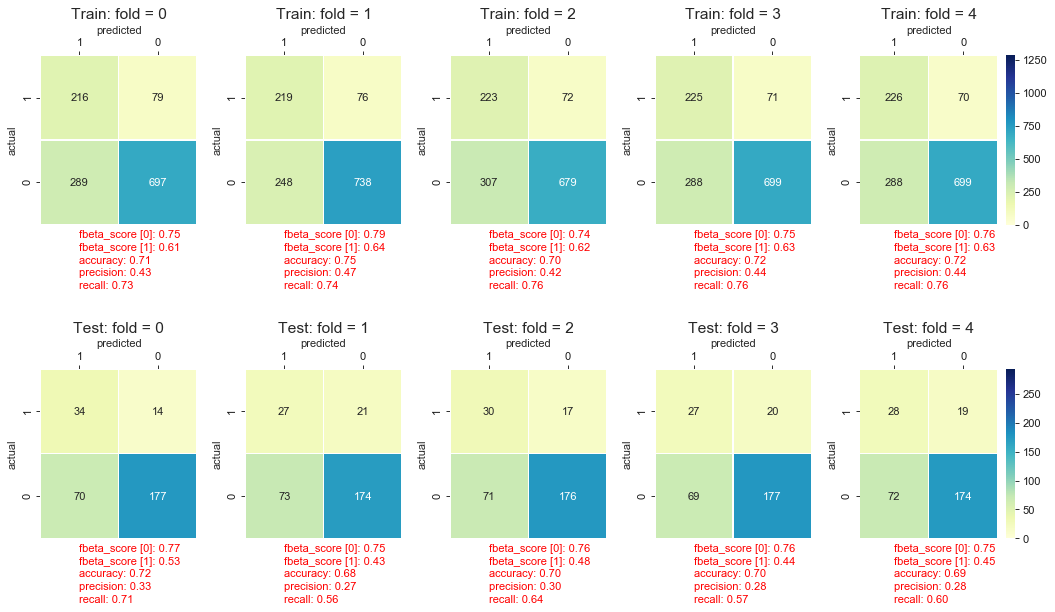

In [87]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelKNNs_CM, f_score_train_KNNs, f_score_test_KNNs, accuracy_train_KNNs, accuracy_test_KNNs, \
precision_train_KNNs, precision_test_KNNs, recall_train_KNNs, recall_test_KNNs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelKNNs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_KNNs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_KNNs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_KNNs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_KNNs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_KNNs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_KNNs))
model_cmp_mean_precision_train.append(mean(precision_train_KNNs))
model_cmp_mean_precision_test.append(mean(precision_test_KNNs))
model_cmp_mean_recall_train.append(mean(recall_train_KNNs))
model_cmp_mean_recall_test.append(mean(recall_test_KNNs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.498
recall: 0.07 | precision: 0.73 | threshold: 0.448
recall: 0.23 | precision: 0.57 | threshold: 0.394
recall: 0.38 | precision: 0.43 | threshold: 0.343
recall: 0.57 | precision: 0.31 | threshold: 0.292
recall: 0.74 | precision: 0.25 | threshold: 0.241
recall: 0.88 | precision: 0.21 | threshold: 0.188
recall: 0.94 | precision: 0.17 | threshold: 0.128


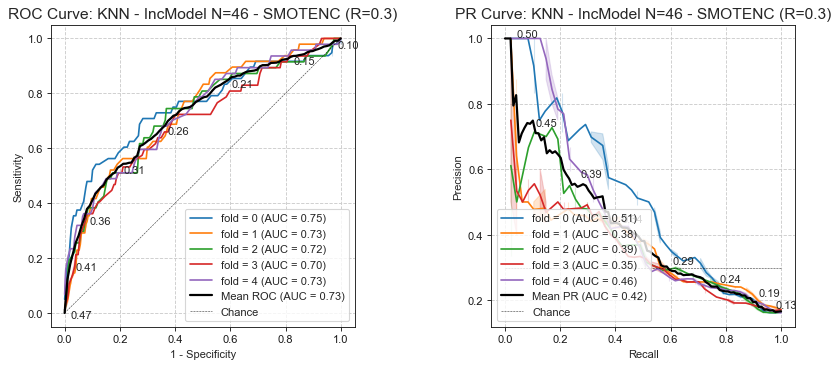

In [88]:
# plot the ROC Curve & PR Curve
figmodelKNNs_ROC, KNNs_mean_roc_auc, KNNs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars, \
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)

plt.show(figmodelKNNs_ROC)
model_cmp_mean_roc_auc.append(KNNs_mean_roc_auc)
model_cmp_mean_pr_auc.append(KNNs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model1_sampling-SMOTENC_1-NN"></a>
##### 4.2.2.2: Neural Networks

In [89]:
model_cmp.append(nvars)
model_str = 'NN_SMOTENC_R1'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)
n_hidden = 1

<b>Test the learning rate ...</b>

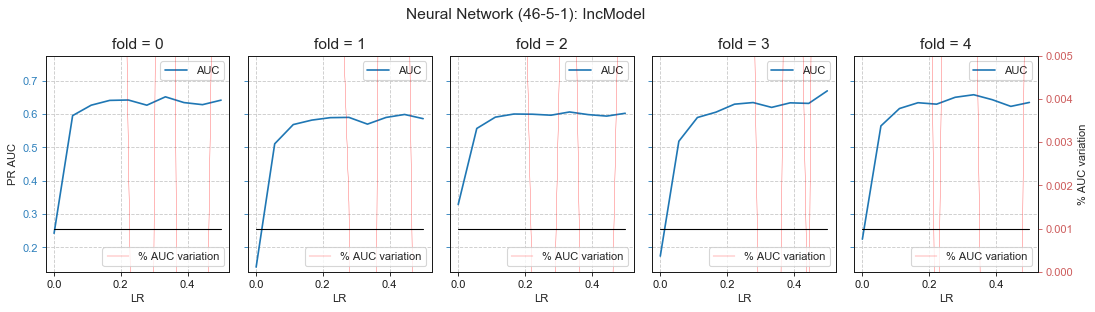

In [90]:
# test Learning Rate
if(test_bool):
    figmodelNNs_LRsk = f_model_NN_testLR(0.001, 0.5, 10, 350, 5, n_hidden, nvars, modelvars_str, 0.1, model_eval_curve)
    plt.show(figmodelNNs_LRsk)

Looking at these plots let's choose learning_rate_init = 0.2.

In [91]:
LR = .2

<b>Test the network architecture ...</b>

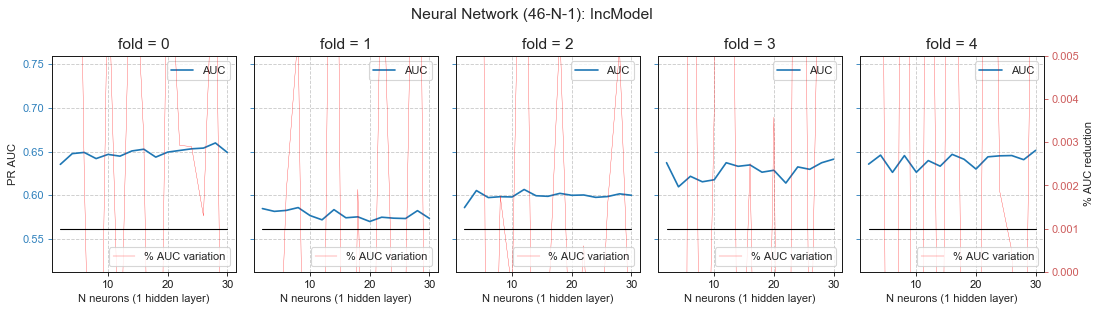

In [92]:
# test Network Architecture
if(test_bool):
    figmodelNNs_N = f_model_NN_testNeurons(LR, 2, 32, 2, 350, n_hidden, nvars, modelvars_str, 0.1, model_eval_curve)
    plt.show(figmodelNNs_N)

Looking at these plots let's choose 8 for the number of neurons on a single hidden layer.

In [93]:
n_neurons = 8

In [94]:
# build the models
start_time = time.time()
for cv in range(n_cv):
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '= MLPClassifier(solver = ' + '\'' + 'sgd' + '\'' +\
         ', activation = ' + '\'' + 'logistic' + '\'' + ', max_iter = 350,' +\
         'learning_rate = ' + '\'' + 'adaptive' + '\'' + ', learning_rate_init = LR,\
         random_state = None, shuffle = True, momentum = .9,\
         hidden_layer_sizes = tuple([n_neurons for h in range(n_hidden)]),\
         n_iter_no_change = 3, tol = 1e-3)')
    
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [95]:
beta = beta_global

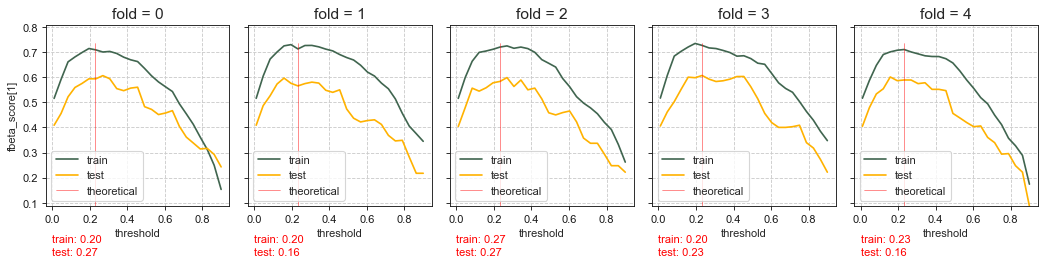

In [96]:
# select the threshold to maximize the metric
figmodelNNs_thresholds, NNs_best_threshold_train, NNs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelNNs_thresholds)

In [97]:
selected_threshold = mean(NNs_best_threshold_train)
print('{:.2f}'.format(mean(NNs_best_threshold_train)))

0.22


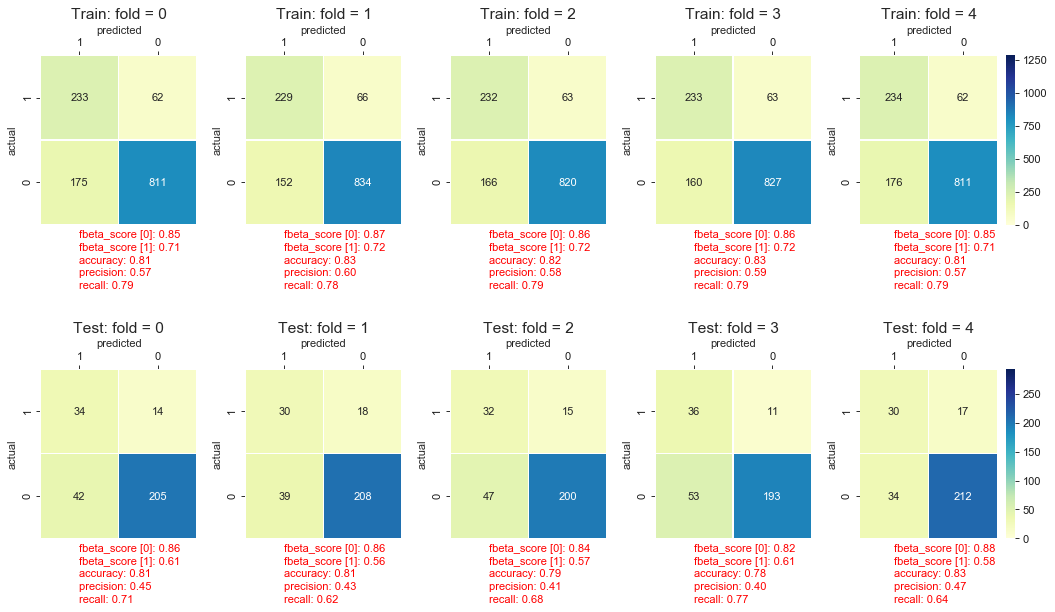

In [98]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelNNs_CM, f_score_train_NNs, f_score_test_NNs, accuracy_train_NNs, accuracy_test_NNs, \
precision_train_NNs, precision_test_NNs, recall_train_NNs, recall_test_NNs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelNNs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_NNs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_NNs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_NNs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_NNs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_NNs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_NNs))
model_cmp_mean_precision_train.append(mean(precision_train_NNs))
model_cmp_mean_precision_test.append(mean(precision_test_NNs))
model_cmp_mean_recall_train.append(mean(recall_train_NNs))
model_cmp_mean_recall_test.append(mean(recall_test_NNs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.969
recall: 0.13 | precision: 1.00 | threshold: 0.916
recall: 0.19 | precision: 0.94 | threshold: 0.859
recall: 0.25 | precision: 0.83 | threshold: 0.794
recall: 0.29 | precision: 0.79 | threshold: 0.734
recall: 0.34 | precision: 0.74 | threshold: 0.647
recall: 0.38 | precision: 0.73 | threshold: 0.586
recall: 0.41 | precision: 0.63 | threshold: 0.518
recall: 0.52 | precision: 0.64 | threshold: 0.467
recall: 0.55 | precision: 0.59 | threshold: 0.399
recall: 0.60 | precision: 0.56 | threshold: 0.349
recall: 0.63 | precision: 0.49 | threshold: 0.292
recall: 0.69 | precision: 0.43 | threshold: 0.219
recall: 0.75 | precision: 0.37 | threshold: 0.162
recall: 0.82 | precision: 0.30 | threshold: 0.108
recall: 0.90 | precision: 0.22 | threshold: 0.053


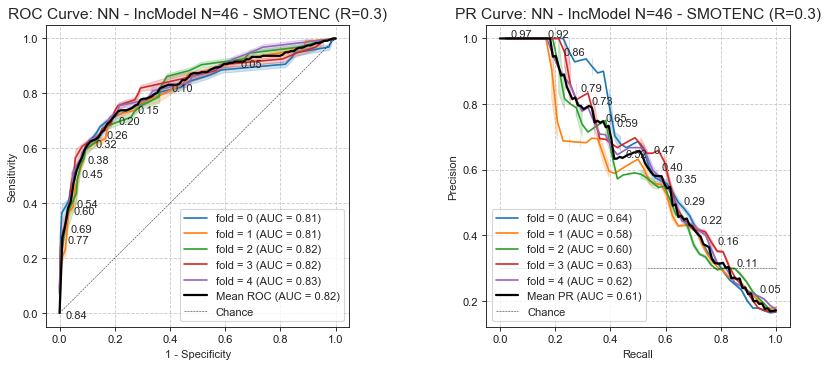

In [99]:
# plot the ROC Curve & PR Curve
figmodelNNs_ROC, NNs_mean_roc_auc, NNs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelNNs_ROC)
model_cmp_mean_roc_auc.append(NNs_mean_roc_auc)
model_cmp_mean_pr_auc.append(NNs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model1_sampling-SMOTENC_1-LogReg"></a>
##### 4.2.2.3: Logistic Regression

In [100]:
model_cmp.append(nvars)
model_str = 'LogReg_SMOTENC_R1'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)
nmax_iter = 300

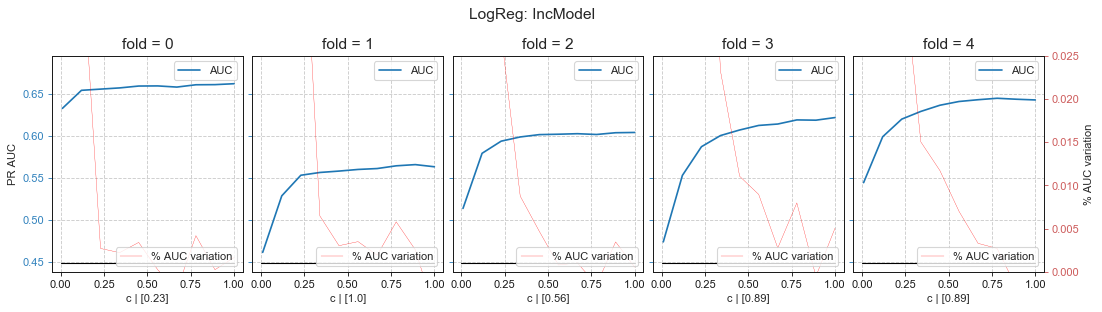

In [101]:
# test c (Inverse of regularization strength)
if(test_bool):
    figmodelLogRegs = f_model_LogReg_test(nmax_iter, 10, model_str.split('_')[0] + ': ' + modelvars_str,\
                                          0.1, model_eval_curve)
    plt.show(figmodelLogRegs)

Looking at these plots let's choose c = 1.0.

In [102]:
c = 1.0

In [103]:
# build the models (only after testing for the hyperparameters)
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = LogisticRegression(penalty = ' + '\'' + 'l2' + '\'' + \
         ', dual = False, tol = 1e-4, C = '+ '{:.2f}'.format(c) + ', fit_intercept = True, intercept_scaling = 1,' + \
         'class_weight = None, random_state = None, solver = ' + '\'' + 'liblinear' + '\'' +', max_iter = ' + \
         str(nmax_iter) + ', verbose = 0, warm_start = True)')

    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + \
         str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [104]:
beta = beta_global

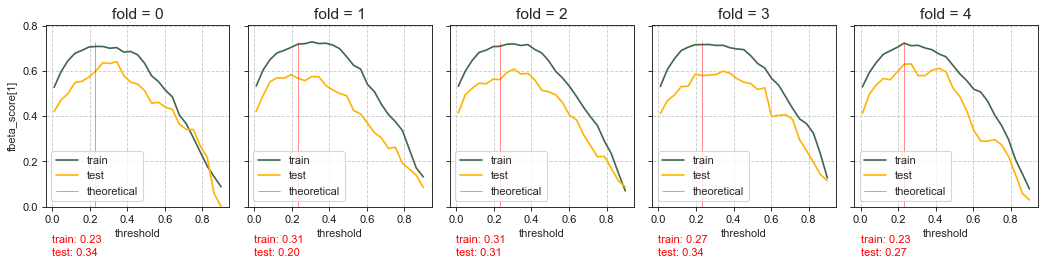

In [105]:
# select the threshold to maximize the metric
figmodelLogRegs_thresholds, LogRegs_best_threshold_train, LogRegs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelLogRegs_thresholds)

In [106]:
selected_threshold = mean(LogRegs_best_threshold_train)
print('{:.2f}'.format(mean(LogRegs_best_threshold_train)))

0.27


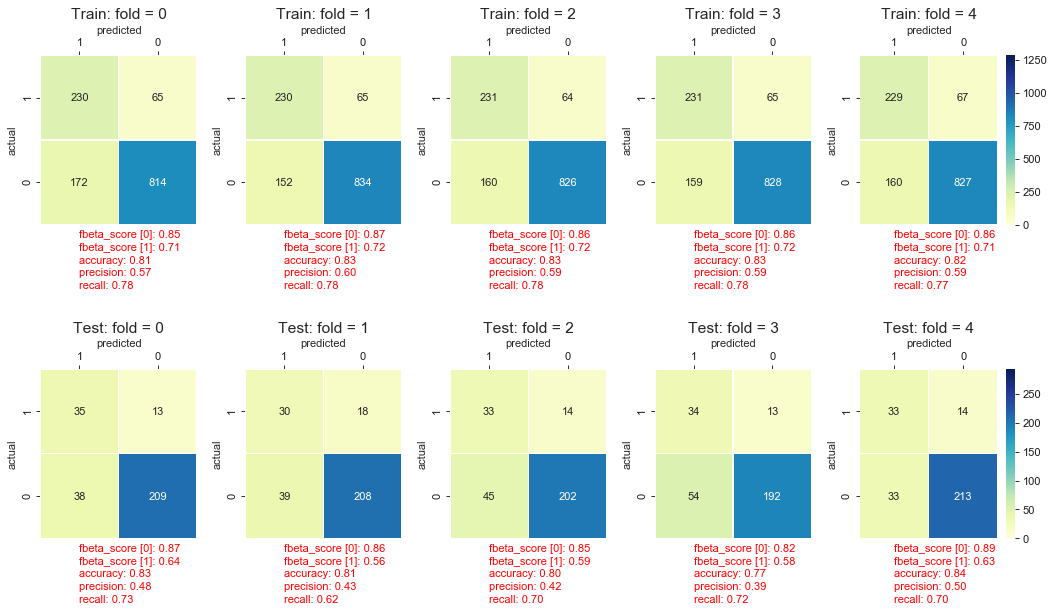

In [107]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelLogRegs_CM, f_score_train_LogRegs, f_score_test_LogRegs, accuracy_train_LogRegs, accuracy_test_LogRegs, \
precision_train_LogRegs, precision_test_LogRegs, recall_train_LogRegs, recall_test_LogRegs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelLogRegs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_LogRegs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_LogRegs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_LogRegs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_LogRegs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_LogRegs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_LogRegs))
model_cmp_mean_precision_train.append(mean(precision_train_LogRegs))
model_cmp_mean_precision_test.append(mean(precision_test_LogRegs))
model_cmp_mean_recall_train.append(mean(recall_train_LogRegs))
model_cmp_mean_recall_test.append(mean(recall_test_LogRegs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.945
recall: 0.06 | precision: 1.00 | threshold: 0.892
recall: 0.13 | precision: 1.00 | threshold: 0.837
recall: 0.19 | precision: 0.91 | threshold: 0.771
recall: 0.24 | precision: 0.83 | threshold: 0.720
recall: 0.29 | precision: 0.82 | threshold: 0.657
recall: 0.35 | precision: 0.78 | threshold: 0.606
recall: 0.40 | precision: 0.70 | threshold: 0.550
recall: 0.47 | precision: 0.67 | threshold: 0.492
recall: 0.53 | precision: 0.62 | threshold: 0.439
recall: 0.60 | precision: 0.54 | threshold: 0.369
recall: 0.66 | precision: 0.49 | threshold: 0.318
recall: 0.71 | precision: 0.43 | threshold: 0.252
recall: 0.74 | precision: 0.36 | threshold: 0.199
recall: 0.80 | precision: 0.32 | threshold: 0.145
recall: 0.88 | precision: 0.24 | threshold: 0.070
recall: 0.96 | precision: 0.18 | threshold: 0.016


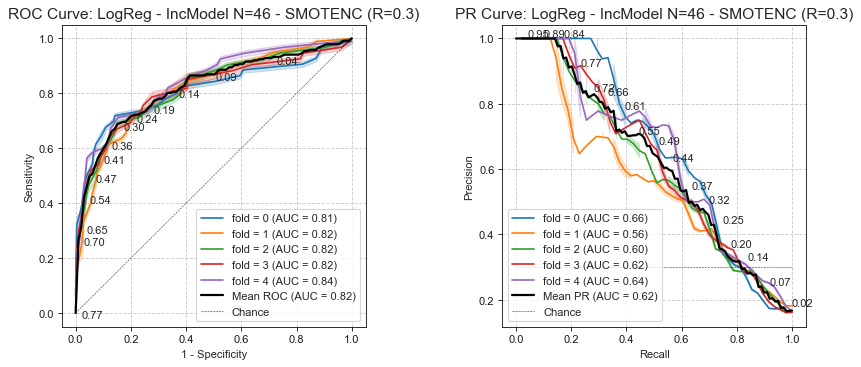

In [108]:
# plot the ROC Curve & PR Curve
figmodelLogRegs_ROC, LogRegs_mean_roc_auc, LogRegs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelLogRegs_ROC)
model_cmp_mean_roc_auc.append(LogRegs_mean_roc_auc)
model_cmp_mean_pr_auc.append(LogRegs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model1_sampling-SMOTENC_1-NBayes"></a>
##### 4.2.2.4: Naive Bayes

In [109]:
model_cmp.append(nvars)
model_str = 'NBayes_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)

In [110]:
# build the models 
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = GaussianNB()')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + \
         'y_train_' + \
         str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [111]:
beta = beta_global

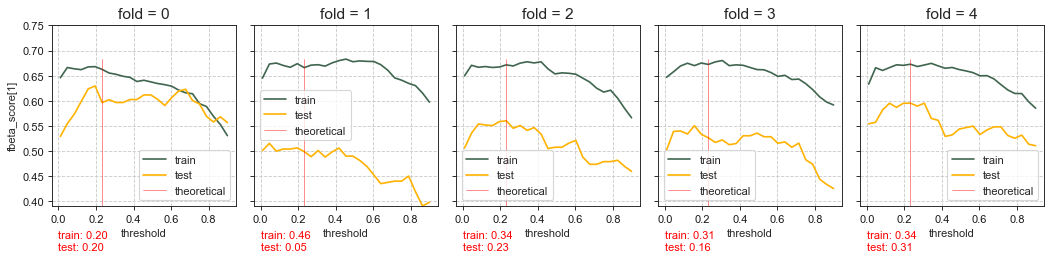

In [112]:
# select the threshold to maximize the metric
figmodelNBayes_thresholds, NBayes_best_threshold_train, NBayes_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelNBayes_thresholds)

In [113]:
selected_threshold = mean(NBayes_best_threshold_train)
print('{:.2f}'.format(mean(NBayes_best_threshold_train)))

0.33


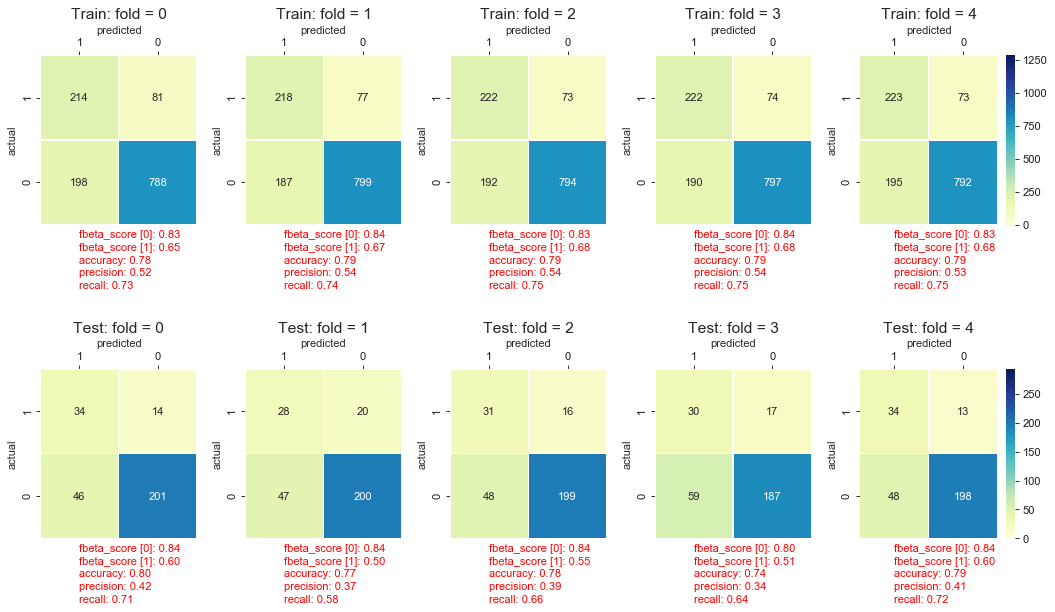

In [114]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelNBayes_CM, f_score_train_NBayes, f_score_test_NBayes, accuracy_train_NBayes, accuracy_test_NBayes, \
precision_train_NBayes, precision_test_NBayes, recall_train_NBayes, recall_test_NBayes = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelNBayes_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_NBayes[0])
model_cmp_mean_f_score_train_1.append(f_score_train_NBayes[1])
model_cmp_mean_f_score_test_0.append(f_score_test_NBayes[0])
model_cmp_mean_f_score_test_1.append(f_score_test_NBayes[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_NBayes))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_NBayes))
model_cmp_mean_precision_train.append(mean(precision_train_NBayes))
model_cmp_mean_precision_test.append(mean(precision_test_NBayes))
model_cmp_mean_recall_train.append(mean(recall_train_NBayes))
model_cmp_mean_recall_test.append(mean(recall_test_NBayes))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 1.000
recall: 0.39 | precision: 0.60 | threshold: 0.949
recall: 0.46 | precision: 0.53 | threshold: 0.868
recall: 0.51 | precision: 0.50 | threshold: 0.809
recall: 0.53 | precision: 0.48 | threshold: 0.746
recall: 0.55 | precision: 0.46 | threshold: 0.688
recall: 0.58 | precision: 0.44 | threshold: 0.567
recall: 0.60 | precision: 0.42 | threshold: 0.496
recall: 0.63 | precision: 0.41 | threshold: 0.440
recall: 0.65 | precision: 0.39 | threshold: 0.361
recall: 0.67 | precision: 0.38 | threshold: 0.305
recall: 0.72 | precision: 0.37 | threshold: 0.201
recall: 0.75 | precision: 0.34 | threshold: 0.137
recall: 0.79 | precision: 0.31 | threshold: 0.058
recall: 0.84 | precision: 0.24 | threshold: 0.006


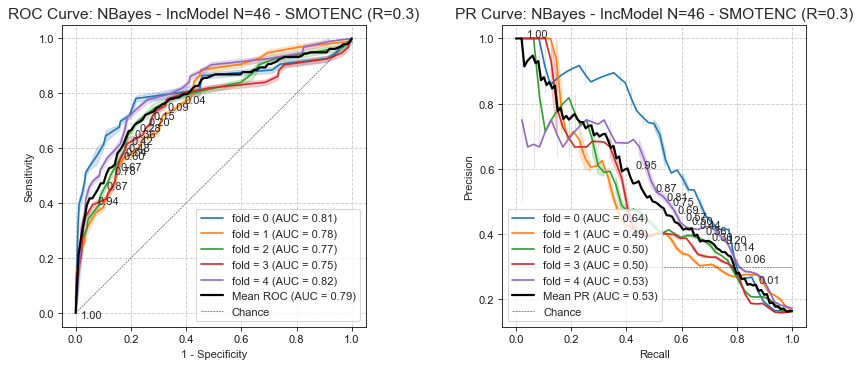

In [115]:
# plot the ROC Curve & PR Curve
figmodelNBayes_ROC, NBayes_mean_roc_auc, NBayes_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelNBayes_ROC)
model_cmp_mean_roc_auc.append(NBayes_mean_roc_auc)
model_cmp_mean_pr_auc.append(NBayes_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model2"></a>
### 4.3: Full Model

In [116]:
list_vars = df_features.index
nvars = len(list_vars)
modelvars_str = 'FullModel'

<b>Input Variables</b>: 

In [117]:
list_vars

Index(['MonthlyIncome_z', 'Age_z', 'DistanceFromHome_z',
       'NumCompaniesWorked_z', 'PercentSalaryHike_z', 'TotalWorkingYears_z',
       'TrainingTimesLastYear_z', 'YearsAtCompany_z', 'YearsInCurrentRole_z',
       'YearsSinceLastPromotion_z', 'YearsWithCurrManager_z',
       'MRate_DRate_dv_z', 'YAtCompany_TotalWorkY_dv_z',
       'NumCompWork_TotalWorkY_dv_z', 'DailyRate_z', 'HourlyRate_z',
       'MonthlyProfit_dv_z', 'distcluster_JR_SalesRep_Attrition_z',
       'distcluster_JR_SalesRep_Attrition_OverTime_z',
       'distcluster_JR_LabTech_z',
       'distcluster_JR_LabTech_Attrition_NoStockOption_z',
       'distcluster_JR_LabTech_Attrition_WorkLifeBalance1_z',
       'distcluster_JR_HR_MediumAttrition_z',
       'distcluster_JR_HR_LowAttrition_z', 'distcluster_JR_HR_HighAttrition_z',
       'distcluster_JR_SalesExec_NoStockOption1_z',
       'distcluster_JR_SalesExec_LowAttrition_z',
       'distcluster_JR_SalesExec_Attrition_OverTime_z',
       'distcluster_JR_ResrchScist_Hi

<a class="anchor" id="model2_sampling-kfold"></a>
#### 4.3.1: Sampling: Stratified k-Fold Cross-Validation

In [118]:
sampling_str = 'k-fold cv'

In [119]:
target_list = target.values
data = df_model[list_vars].values

skf = StratifiedKFold(n_splits = 5, shuffle = False)
skf.get_n_splits(target, data)

cv = 0
theoretical_thresholds = []
for train_index, test_index in skf.split(data, target):
    exec('X_train_' + str(cv) + ', ' + 'X_test_' + str(cv) + ' = data[train_index], data[test_index]')
    exec('y_train_' + str(cv) + ', ' + 'y_test_' + str(cv) + ' = target[train_index], target[test_index]')
    
    exec('theoretical_thresholds.append(np.count_nonzero(y_train_' + str(cv) + \
                                                      '== 1)/(np.count_nonzero(y_train_' + str(cv) + '== 0) + ' +\
                         'np.count_nonzero(y_train_' + str(cv) + '==1)))')
    cv = cv + 1

n_cv = cv

In [120]:
theoretical_threshold = np.mean(theoretical_thresholds)
print('theoretical threshold: ', '{:.2f}'.format(theoretical_threshold))

theoretical threshold:  0.16


[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model2_sampling-kfold-KNN"></a>
##### 4.3.1.1: K-Nearest Neighbours

In [121]:
model_cmp.append(nvars)
model_str = 'KNN_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)

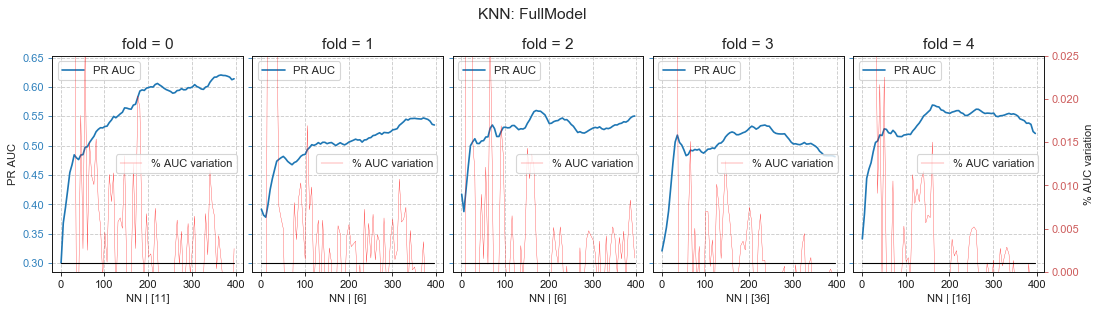

In [122]:
# test k NN (number of Nearest Neighbours)
if(test_bool):
    figmodelKNNs = f_model_KNN_test(400, 5, model_str.split('_')[0] + ': ' + modelvars_str , 0.5, model_eval_curve)
    plt.show(figmodelKNNs)

Looking at these plots let's choose K = 250.

In [123]:
k = 250

In [124]:
# build the models (only after testing for the hyperparameters)
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = KNeighborsClassifier(n_neighbors = k)')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + \
         'y_train_' + str(cv) + ')')
    
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [125]:
beta = beta_global

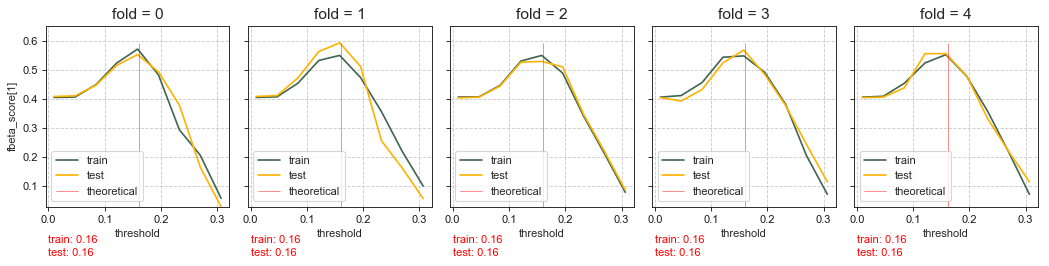

In [126]:
# select the threshold to maximize the metric
figmodelKNNs_thresholds, KNNs_best_threshold_train, KNNs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelKNNs_thresholds)

In [127]:
selected_threshold = mean(KNNs_best_threshold_train)
print('{:.2f}'.format(mean(KNNs_best_threshold_train)))

0.16


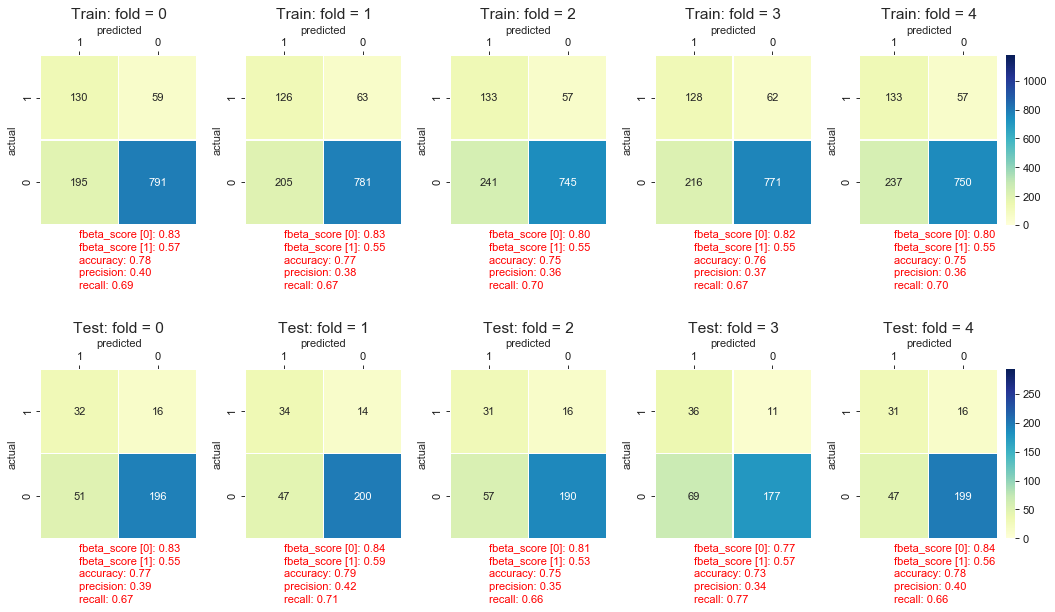

In [128]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelKNNs_CM, f_score_train_KNNs, f_score_test_KNNs, accuracy_train_KNNs, accuracy_test_KNNs, \
precision_train_KNNs, precision_test_KNNs, recall_train_KNNs, recall_test_KNNs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelKNNs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_KNNs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_KNNs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_KNNs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_KNNs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_KNNs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_KNNs))
model_cmp_mean_precision_train.append(mean(precision_train_KNNs))
model_cmp_mean_precision_test.append(mean(precision_test_KNNs))
model_cmp_mean_recall_train.append(mean(recall_train_KNNs))
model_cmp_mean_recall_test.append(mean(recall_test_KNNs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.341
recall: 0.12 | precision: 1.00 | threshold: 0.289
recall: 0.28 | precision: 0.69 | threshold: 0.234
recall: 0.54 | precision: 0.45 | threshold: 0.184
recall: 0.84 | precision: 0.29 | threshold: 0.127
recall: 0.97 | precision: 0.18 | threshold: 0.075


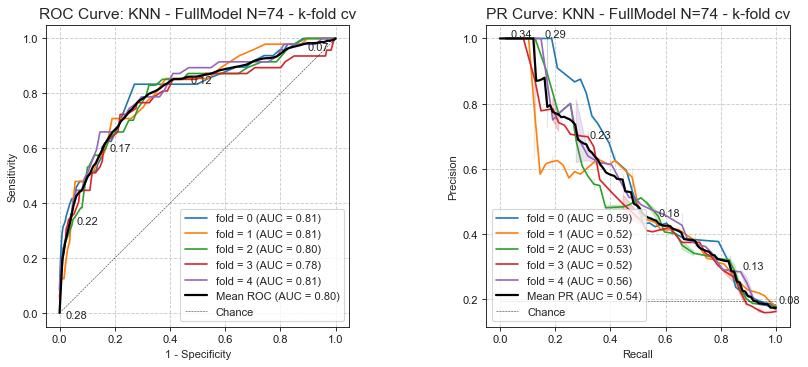

In [129]:
# plot the ROC Curve & PR Curve
figmodelKNNs_ROC, KNNs_mean_roc_auc, KNNs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars, \
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)

plt.show(figmodelKNNs_ROC)
model_cmp_mean_roc_auc.append(KNNs_mean_roc_auc)
model_cmp_mean_pr_auc.append(KNNs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model2_sampling-kfold-NN"></a>
##### 4.3.1.2: Neural Networks

In [130]:
model_cmp.append(nvars)
model_str = 'NN_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)
n_hidden = 1

<b>Test the learning rate ...</b>

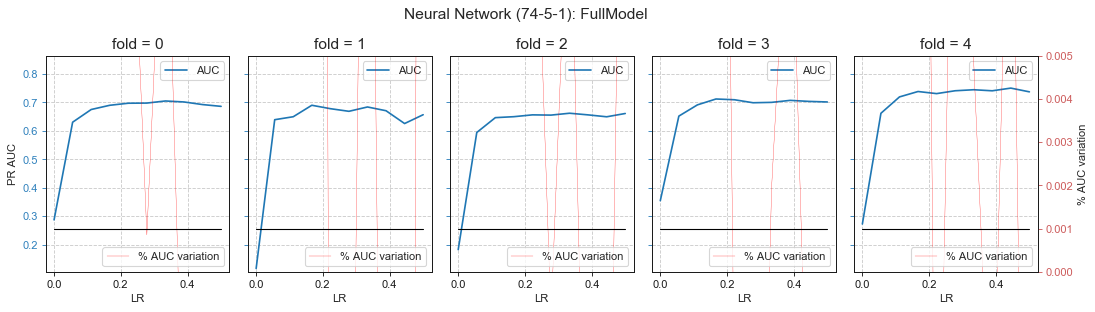

In [131]:
# test Learning Rate
if(test_bool):
    figmodelNNs_LRsk = f_model_NN_testLR(0.001, 0.5, 10, 250, 5, n_hidden, nvars, modelvars_str, 0.1, model_eval_curve)
    plt.show(figmodelNNs_LRsk)

Looking at these plots let's choose learning_rate_init = 0.2.

In [132]:
LR = .2

<b>Test the network architecture ...</b>

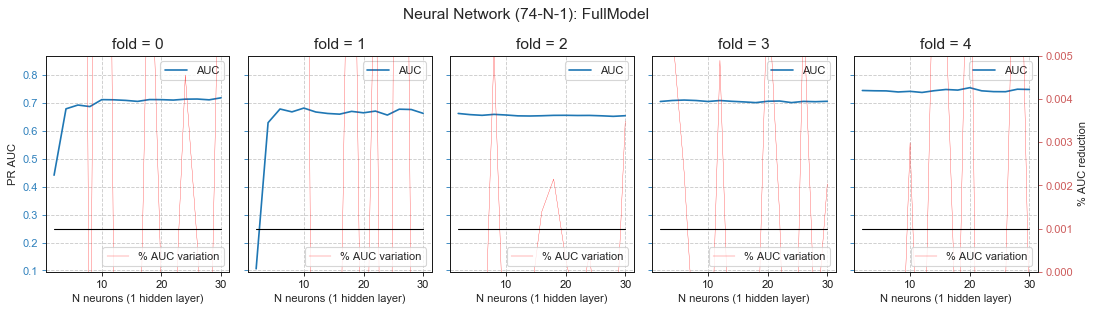

In [133]:
# test Network Architecture
if(test_bool):
    figmodelNNs_N = f_model_NN_testNeurons(LR, 2, 32, 2, 250, n_hidden, nvars, modelvars_str, 0.1, model_eval_curve)
    plt.show(figmodelNNs_N)

Looking at these plots let's choose 8 for the number of neurons on a single hidden layer.

In [134]:
n_neurons = 8

In [135]:
# build the models
start_time = time.time()
for cv in range(n_cv):
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '= MLPClassifier(solver = ' + '\'' + 'sgd' + '\'' +\
         ', activation = ' + '\'' + 'logistic' + '\'' + ', max_iter = 350,' +\
         'learning_rate = ' + '\'' + 'adaptive' + '\'' + ', learning_rate_init = LR,\
         random_state = None, shuffle = True, momentum = .9,\
         hidden_layer_sizes = tuple([n_neurons for h in range(n_hidden)]),\
         n_iter_no_change = 3, tol = 1e-3)')
    
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + \
         'y_train_' + str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [136]:
beta = 1.6

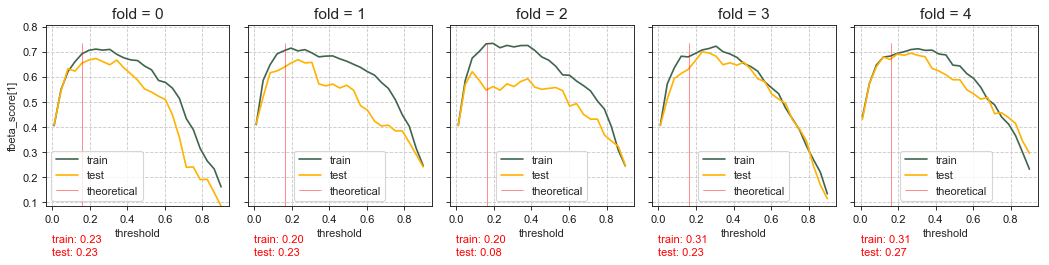

In [137]:
# select the threshold to maximize the metric
figmodelNNs_thresholds, NNs_best_threshold_train, NNs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelNNs_thresholds)

In [138]:
selected_threshold = mean(NNs_best_threshold_train)
print('{:.2f}'.format(mean(NNs_best_threshold_train)))

0.25


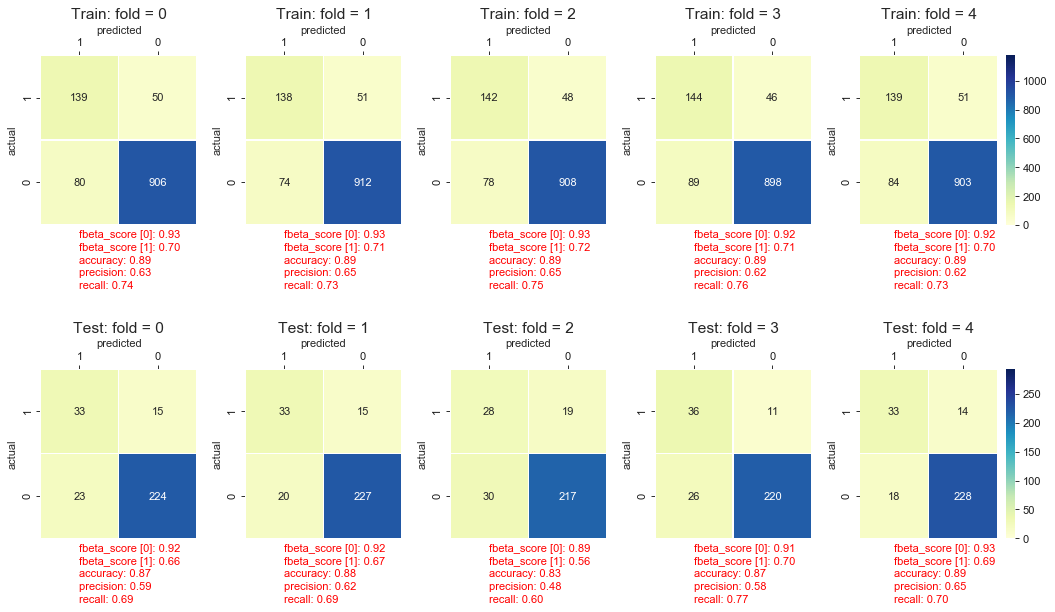

In [139]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelNNs_CM, f_score_train_NNs, f_score_test_NNs, accuracy_train_NNs, accuracy_test_NNs, \
precision_train_NNs, precision_test_NNs, recall_train_NNs, recall_test_NNs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelNNs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_NNs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_NNs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_NNs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_NNs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_NNs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_NNs))
model_cmp_mean_precision_train.append(mean(precision_train_NNs))
model_cmp_mean_precision_test.append(mean(precision_test_NNs))
model_cmp_mean_recall_train.append(mean(recall_train_NNs))
model_cmp_mean_recall_test.append(mean(recall_test_NNs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.965
recall: 0.13 | precision: 0.97 | threshold: 0.911
recall: 0.20 | precision: 0.93 | threshold: 0.854
recall: 0.28 | precision: 0.92 | threshold: 0.798
recall: 0.33 | precision: 0.89 | threshold: 0.740
recall: 0.38 | precision: 0.85 | threshold: 0.676
recall: 0.44 | precision: 0.82 | threshold: 0.618
recall: 0.48 | precision: 0.80 | threshold: 0.562
recall: 0.52 | precision: 0.75 | threshold: 0.502
recall: 0.56 | precision: 0.72 | threshold: 0.441
recall: 0.60 | precision: 0.66 | threshold: 0.372
recall: 0.65 | precision: 0.62 | threshold: 0.312
recall: 0.70 | precision: 0.58 | threshold: 0.244
recall: 0.73 | precision: 0.52 | threshold: 0.184
recall: 0.77 | precision: 0.44 | threshold: 0.122
recall: 0.86 | precision: 0.32 | threshold: 0.063


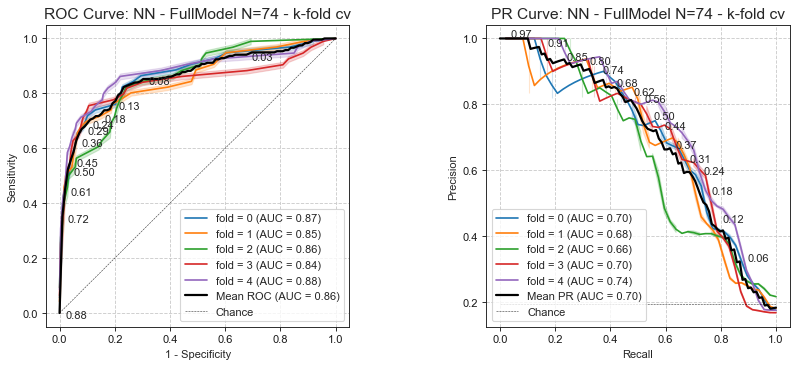

In [140]:
# plot the ROC Curve & PR Curve
figmodelNNs_ROC, NNs_mean_roc_auc, NNs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelNNs_ROC)
model_cmp_mean_roc_auc.append(NNs_mean_roc_auc)
model_cmp_mean_pr_auc.append(NNs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model2_sampling-kfold-DL"></a>
##### 4.3.1.3: Deep Learning (KERAS)

In [141]:
model_cmp.append(nvars)
model_str = 'DL_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)

In [142]:
n_hidden = [64,32,8]
epochs_max = 20

<b>Test the optimizer, including the learning rate (for a given network architecture) ...</b>

fold 0 | LR = 0.00010 | val loss:
['0.440', '0.421', '0.415', '0.410', '0.408', '0.405', '0.403']
fold 0 | LR = 0.00188 | val loss:
['0.340', '0.313', '0.314', '0.300', '0.297', '0.286', '0.280', '0.297', '0.280']
fold 0 | LR = 0.00366 | val loss:
['0.334', '0.312', '0.296', '0.329', '0.322', '0.323']
fold 0 | LR = 0.00544 | val loss:
['0.317', '0.306', '0.301', '0.427', '0.339']
fold 0 | LR = 0.00721 | val loss:
['0.352', '0.311', '0.339', '0.402', '0.385']
fold 0 | LR = 0.00899 | val loss:
['0.358', '0.416', '0.372', '0.355']
fold 0 | LR = 0.01077 | val loss:
['0.539', '0.389', '0.379', '0.380', '0.515']

fold 1 | LR = 0.00010 | val loss:
['0.468', '0.432', '0.421', '0.414', '0.410', '0.407', '0.404', '0.402']
fold 1 | LR = 0.00188 | val loss:
['0.322', '0.354', '0.309', '0.291', '0.304', '0.310', '0.307']
fold 1 | LR = 0.00366 | val loss:
['0.317', '0.374', '0.312', '0.327']
fold 1 | LR = 0.00544 | val loss:
['0.319', '0.358', '0.344', '0.308', '0.380', '0.372', '0.354']
fold 1 | LR

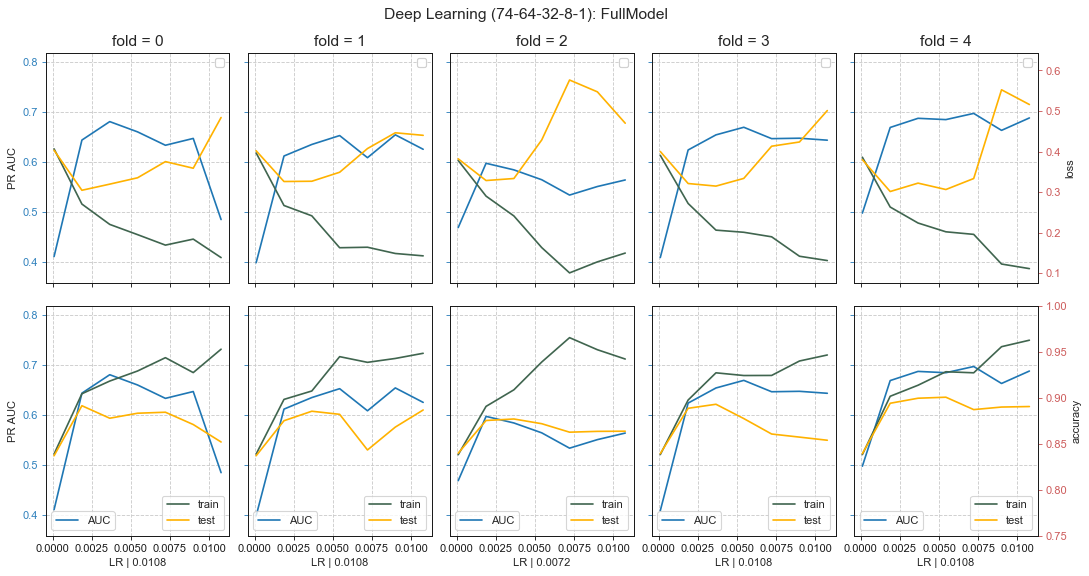

In [143]:
# test the LR
if(test_bool):
    figmodelDL_LR = f_model_DL_LR(0.0001, 0.025, 15, epochs_max, n_hidden, nvars, modelvars_str, 0.2, model_eval_curve)
    plt.show(figmodelDL_LR)

Looking at these values let's choose Learning Rate = 0.0036

In [144]:
LR = .00366

<b>Test the epochs (for a given network architecture) ...</b>

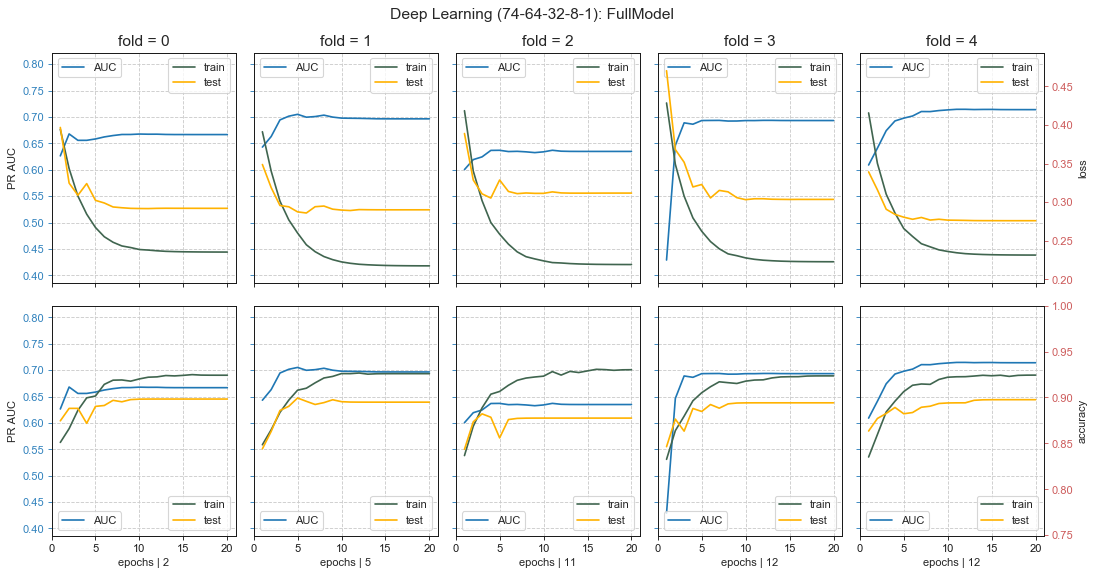

In [145]:
# test the epochs
if(test_bool):
    figmodelDL_epochs = f_model_DL_epochs(epochs_max, n_hidden, nvars, LR, modelvars_str, .2, model_eval_curve)
    plt.show(figmodelDL_epochs)

Looking at these plots let's choose epochs = 10

In [146]:
epochs = 10

In [147]:
# build the models
start_time = time.time()
# define the Learning Rate (inside the optimizer) 
def lr_scheduler(epoch, lr):
    return lr*10**(np.log10(0.01)/(epochs_max/2)) # reduce initial LR 100 times when the epochs = epochs_max / 2

# build the models (only after testing for the hyperparameters)
for cv in range(n_cv): 
    print('cv: ' + str(cv) + ' | LR = ' + '{:.5f}'.format(LR))
    # define the architecture of the network
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = models.Sequential()')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.add(layers.Dense(n_hidden[0], activation = ' + 
         '\'' + 'relu' + '\'' + ', input_dim = nvars))') # add the first hidden layer
    for h in range(1, len(n_hidden)): # add the remaining hidden layers
        exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.add(layers.Dense(n_hidden[h], activation = ' + \
             '\'' + 'relu' +  '\'' + '))')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.add(layers.Dense(1, activation = '+ '\'' + \
         'sigmoid' + '\'' + '))') # add the output layer
    
    optm = optimizers.SGD(learning_rate = LR, momentum = .9, nesterov = False)
    lr_decay = callbacks.LearningRateScheduler(lr_scheduler, verbose = 0)
    
    # compile the model
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.compile(optimizer = optm, loss = ' + '\'' + \
         'binary_crossentropy' + '\'' + ', metrics = [' + '\'' + 'accuracy' + '\'' + '])')

    # train the model
    exec('output_history_' + str(cv) + '_' + str(nvars) + ' = OutputObserver(X_test_' + str(cv) + ')')
    exec('historymodelDL_' + str(cv) + '_' + str(nvars) + ' = model' + model_str + '_' + str(cv) + '_' + str(nvars) + \
         '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ', validation_data = (X_test_' + str(cv) + \
         ',' + ' y_test_' + str(cv) + ')' + ', epochs = ' + str(epochs) + \
         ', batch_size = 1, verbose = 1, shuffle = True, callbacks = [output_history_' + \
         str(cv) + '_' + str(nvars) + ', lr_decay])')
    print('')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

cv: 0 | LR = 0.00366
Train on 1175 samples, validate on 295 samples
Epoch 1/10
1175/1175 [==============================] - 2s 1ms/step - loss: 0.4126 - accuracy: 0.8383 - val_loss: 0.3524 - val_accuracy: 0.8373
Epoch 2/10
1175/1175 [==============================] - 1s 1ms/step - loss: 0.3265 - accuracy: 0.8485 - val_loss: 0.3314 - val_accuracy: 0.8780
Epoch 3/10
1175/1175 [==============================] - 1s 1ms/step - loss: 0.3086 - accuracy: 0.8885 - val_loss: 0.3156 - val_accuracy: 0.8881
Epoch 4/10
1175/1175 [==============================] - 1s 1ms/step - loss: 0.2851 - accuracy: 0.8936 - val_loss: 0.3103 - val_accuracy: 0.8847
Epoch 5/10
1175/1175 [==============================] - 1s 1ms/step - loss: 0.2723 - accuracy: 0.9047 - val_loss: 0.2993 - val_accuracy: 0.8915
Epoch 6/10
1175/1175 [==============================] - 2s 1ms/step - loss: 0.2614 - accuracy: 0.9098 - val_loss: 0.2970 - val_accuracy: 0.8915
Epoch 7/10
1175/1175 [==============================] - 1s 1ms/step 

In [148]:
beta = 1.6

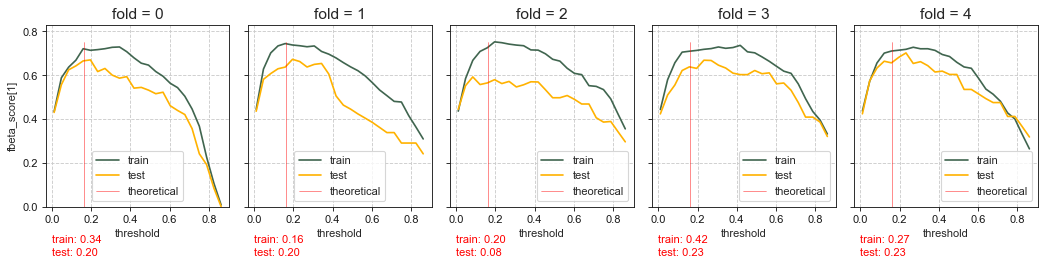

In [149]:
# select the threshold to maximize the metric
figmodelDL_thresholds, DL_best_threshold_train, DL_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelDL_thresholds)

In [150]:
selected_threshold = mean(DL_best_threshold_train)
print('{:.2f}'.format(mean(DL_best_threshold_train)))

0.28


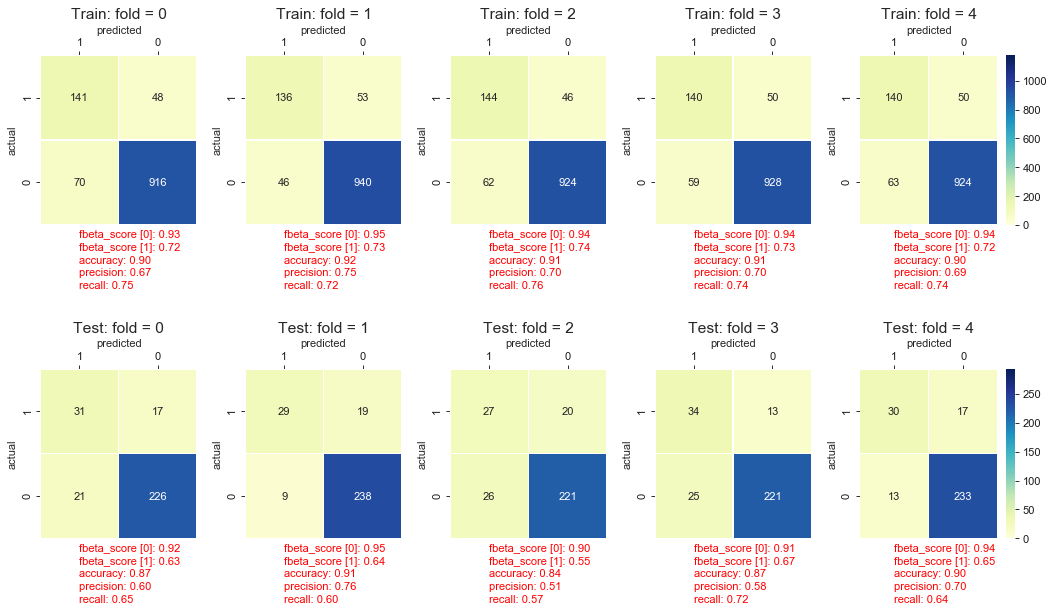

In [151]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelDLs_CM, f_score_train_DLs, f_score_test_DLs, accuracy_train_DLs, accuracy_test_DLs, \
precision_train_DLs, precision_test_DLs, recall_train_DLs, recall_test_DLs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelDLs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_DLs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_DLs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_DLs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_DLs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_DLs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_DLs))
model_cmp_mean_precision_train.append(mean(precision_train_DLs))
model_cmp_mean_precision_test.append(mean(precision_test_DLs))
model_cmp_mean_recall_train.append(mean(recall_train_DLs))
model_cmp_mean_recall_test.append(mean(recall_test_DLs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.944
recall: 0.14 | precision: 0.97 | threshold: 0.892
recall: 0.24 | precision: 0.92 | threshold: 0.829
recall: 0.29 | precision: 0.88 | threshold: 0.778
recall: 0.33 | precision: 0.84 | threshold: 0.724
recall: 0.37 | precision: 0.84 | threshold: 0.669
recall: 0.41 | precision: 0.81 | threshold: 0.610
recall: 0.46 | precision: 0.80 | threshold: 0.539
recall: 0.51 | precision: 0.76 | threshold: 0.485
recall: 0.56 | precision: 0.70 | threshold: 0.418
recall: 0.60 | precision: 0.65 | threshold: 0.336
recall: 0.65 | precision: 0.59 | threshold: 0.269
recall: 0.71 | precision: 0.54 | threshold: 0.199
recall: 0.76 | precision: 0.46 | threshold: 0.139
recall: 0.83 | precision: 0.38 | threshold: 0.088
recall: 0.90 | precision: 0.23 | threshold: 0.030


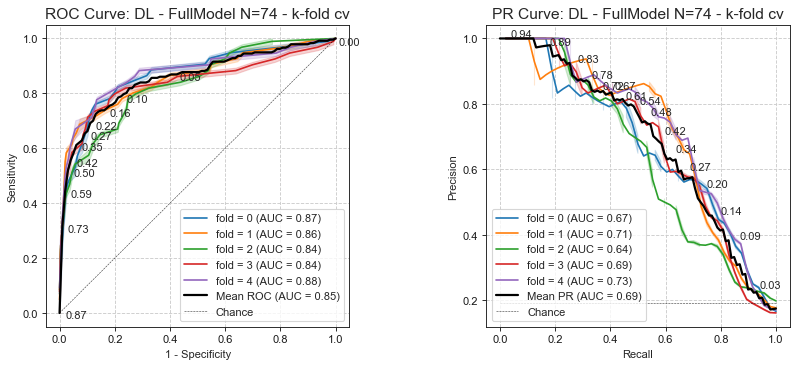

In [152]:
# plot the ROC Curve & PR Curve
figmodelDLs_ROC, DLs_mean_roc_auc, DLs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelDLs_ROC)
model_cmp_mean_roc_auc.append(DLs_mean_roc_auc)
model_cmp_mean_pr_auc.append(DLs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model2_sampling-kfold-LogReg"></a>
##### 4.3.1.4: Logistic Regression

In [153]:
model_cmp.append(nvars)
model_str = 'LogReg_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)
nmax_iter = 300

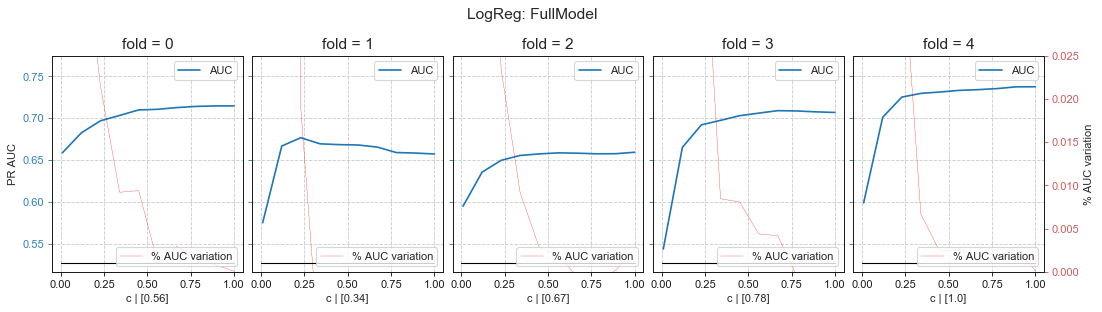

In [154]:
# test c (Inverse of regularization strength)
if(test_bool):
    figmodelLogRegs = f_model_LogReg_test(nmax_iter, 10, model_str.split('_')[0] + ': ' + modelvars_str,\
                                          0.1, model_eval_curve)
    plt.show(figmodelLogRegs)

Looking at these plots let's choose c = 0.75.

In [155]:
c = 0.75

In [156]:
# build the models (only after testing for the hyperparameters)
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = LogisticRegression(penalty = ' + '\'' + 'l2' + \
         '\'' + ', dual = False, tol = 1e-4, C = '+ '{:.2f}'.format(c) + \
         ', fit_intercept = True, intercept_scaling = 1,' + \
         'class_weight = None, random_state = None, solver = ' + '\'' + 'liblinear' + '\'' +', max_iter = ' + \
         str(nmax_iter) + ', verbose = 0, warm_start = True)')

    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + \
         'y_train_' + \
         str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [157]:
beta = 1.6

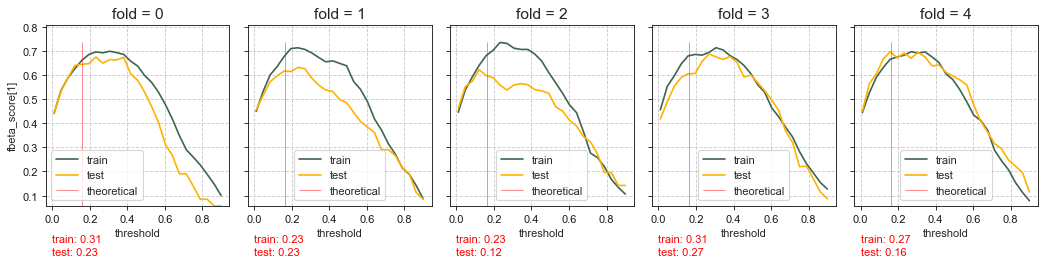

In [158]:
# select the threshold to maximize the metric
figmodelLogRegs_thresholds, LogRegs_best_threshold_train, LogRegs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelLogRegs_thresholds)

In [159]:
selected_threshold = mean(LogRegs_best_threshold_train)
print('{:.2f}'.format(mean(LogRegs_best_threshold_train)))

0.27


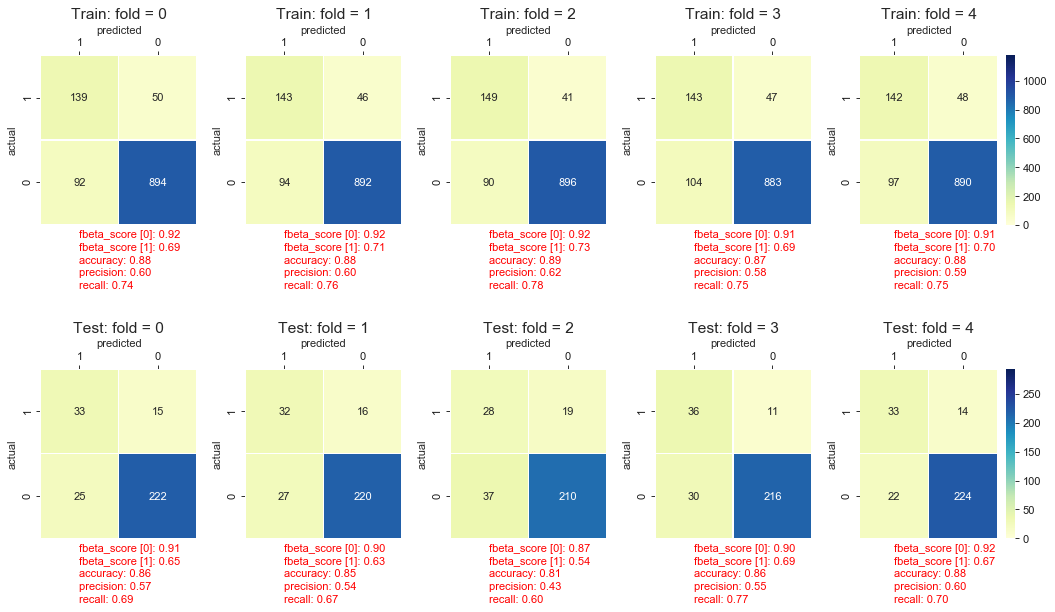

In [160]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelLogRegs_CM, f_score_train_LogRegs, f_score_test_LogRegs, accuracy_train_LogRegs, accuracy_test_LogRegs, \
precision_train_LogRegs, precision_test_LogRegs, recall_train_LogRegs, recall_test_LogRegs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelLogRegs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_LogRegs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_LogRegs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_LogRegs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_LogRegs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_LogRegs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_LogRegs))
model_cmp_mean_precision_train.append(mean(precision_train_LogRegs))
model_cmp_mean_precision_test.append(mean(precision_test_LogRegs))
model_cmp_mean_recall_train.append(mean(recall_train_LogRegs))
model_cmp_mean_recall_test.append(mean(recall_test_LogRegs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.966
recall: 0.07 | precision: 1.00 | threshold: 0.902
recall: 0.11 | precision: 1.00 | threshold: 0.847
recall: 0.16 | precision: 0.95 | threshold: 0.788
recall: 0.21 | precision: 0.91 | threshold: 0.735
recall: 0.25 | precision: 0.91 | threshold: 0.685
recall: 0.32 | precision: 0.90 | threshold: 0.630
recall: 0.38 | precision: 0.85 | threshold: 0.579
recall: 0.45 | precision: 0.83 | threshold: 0.528
recall: 0.52 | precision: 0.74 | threshold: 0.452
recall: 0.58 | precision: 0.67 | threshold: 0.389
recall: 0.65 | precision: 0.62 | threshold: 0.330
recall: 0.70 | precision: 0.56 | threshold: 0.276
recall: 0.76 | precision: 0.48 | threshold: 0.207
recall: 0.80 | precision: 0.41 | threshold: 0.155
recall: 0.86 | precision: 0.34 | threshold: 0.098
recall: 0.90 | precision: 0.25 | threshold: 0.043


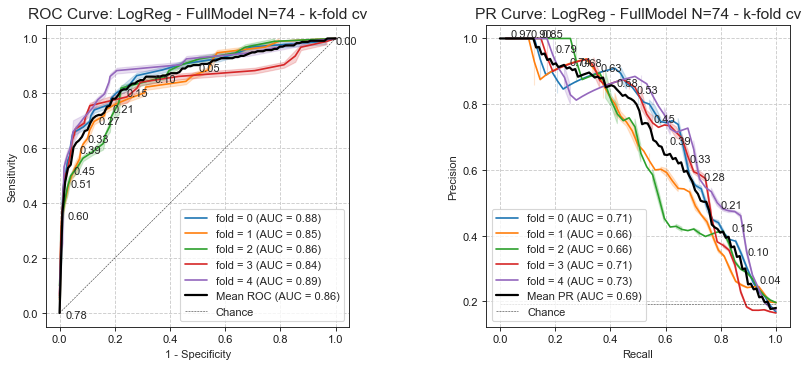

In [161]:
# plot the ROC Curve & PR Curve
figmodelLogRegs_ROC, LogRegs_mean_roc_auc, LogRegs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelLogRegs_ROC)
model_cmp_mean_roc_auc.append(LogRegs_mean_roc_auc)
model_cmp_mean_pr_auc.append(LogRegs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model2_sampling-kfold-NBayes"></a>
##### 4.3.1.5: Naive Bayes

In [162]:
model_cmp.append(nvars)
model_str = 'NBayes_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)

In [163]:
# build the models 
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = GaussianNB()')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + \
         'y_train_' + \
         str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [164]:
beta = beta_global

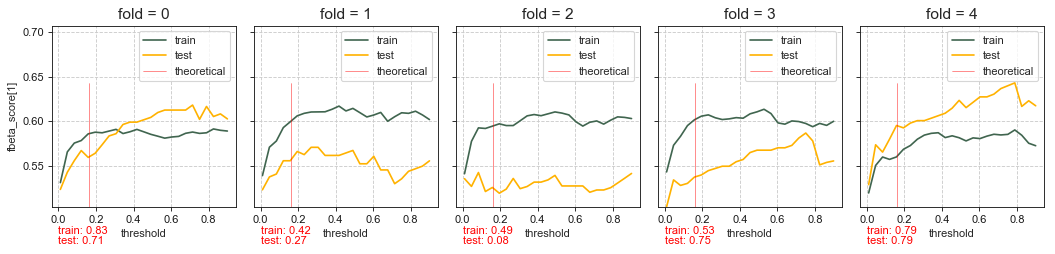

In [165]:
# select the threshold to maximize the metric
figmodelNBayes_thresholds, NBayes_best_threshold_train, NBayes_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelNBayes_thresholds)

In [166]:
selected_threshold = mean(NBayes_best_threshold_train)
print('{:.2f}'.format(mean(NBayes_best_threshold_train)))

0.61


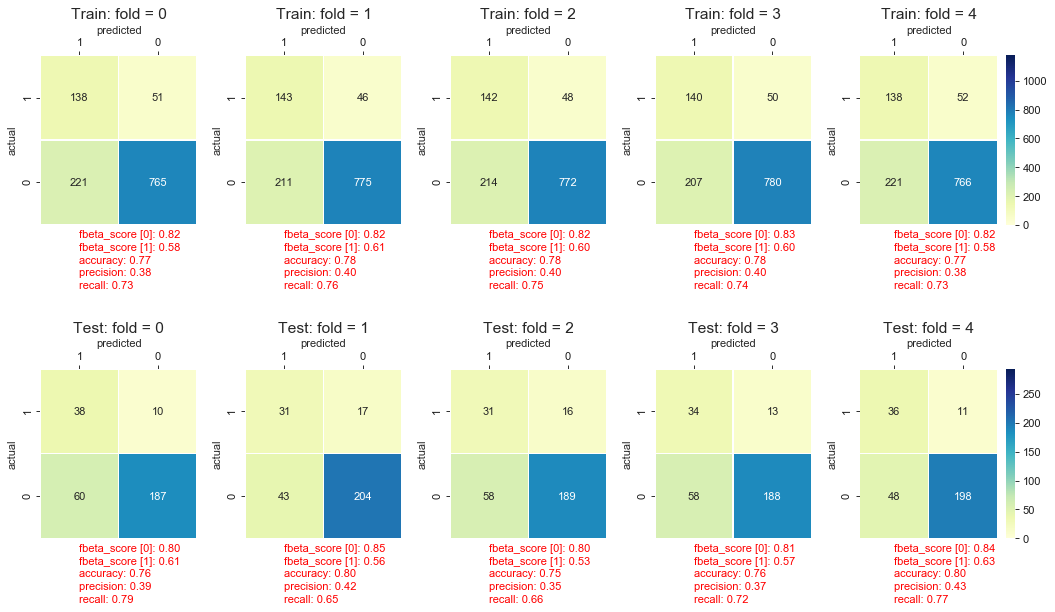

In [167]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelNBayes_CM, f_score_train_NBayes, f_score_test_NBayes, accuracy_train_NBayes, accuracy_test_NBayes, \
precision_train_NBayes, precision_test_NBayes, recall_train_NBayes, recall_test_NBayes = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelNBayes_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_NBayes[0])
model_cmp_mean_f_score_train_1.append(f_score_train_NBayes[1])
model_cmp_mean_f_score_test_0.append(f_score_test_NBayes[0])
model_cmp_mean_f_score_test_1.append(f_score_test_NBayes[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_NBayes))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_NBayes))
model_cmp_mean_precision_train.append(mean(precision_train_NBayes))
model_cmp_mean_precision_test.append(mean(precision_test_NBayes))
model_cmp_mean_recall_train.append(mean(recall_train_NBayes))
model_cmp_mean_recall_test.append(mean(recall_test_NBayes))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 1.000
recall: 0.61 | precision: 0.44 | threshold: 0.931
recall: 0.65 | precision: 0.42 | threshold: 0.810
recall: 0.67 | precision: 0.42 | threshold: 0.725
recall: 0.70 | precision: 0.41 | threshold: 0.644
recall: 0.72 | precision: 0.39 | threshold: 0.557
recall: 0.73 | precision: 0.36 | threshold: 0.404
recall: 0.76 | precision: 0.34 | threshold: 0.339
recall: 0.77 | precision: 0.32 | threshold: 0.261
recall: 0.79 | precision: 0.30 | threshold: 0.186
recall: 0.80 | precision: 0.28 | threshold: 0.071
recall: 0.84 | precision: 0.26 | threshold: 0.018


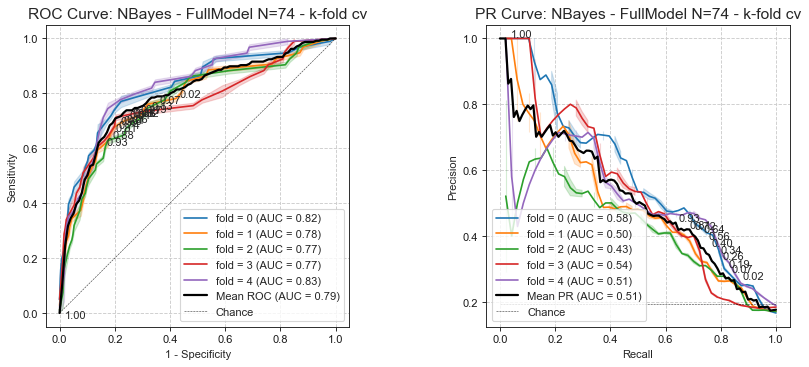

In [168]:
# plot the ROC Curve & PR Curve
figmodelNBayes_ROC, NBayes_mean_roc_auc, NBayes_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelNBayes_ROC)
model_cmp_mean_roc_auc.append(NBayes_mean_roc_auc)
model_cmp_mean_pr_auc.append(NBayes_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model2_sampling-SMOTENC_1"></a>
#### 4.3.2: Stratified k-Fold Cross-Validation + Oversampling: SMOTENC (R=0.3)

In [169]:
sampling_str = 'SMOTENC (R=0.3)'
sampling_strategy = 0.3

In [170]:
target_list = target.values
data = df_model[list_vars].values

categorical_idx = []
idx = 0
for var in df_model[list_vars].columns:
    if('_flag' in var):
        categorical_idx.append(idx)
    idx = idx + 1
categorical_idx

skf = StratifiedKFold(n_splits = 5, shuffle = False)
skf.get_n_splits(target, data)

cv = 0
theoretical_thresholds = []
for train_index, test_index in skf.split(data, target):
    print('k-fold: ' + str(cv))
    # standard k-fold cross validation
    exec('X_train_' + str(cv) + ', ' + 'X_test_' + str(cv) + ' = data[train_index], data[test_index]')
    exec('y_train_' + str(cv) + ', ' + 'y_test_' + str(cv) + ' = target[train_index], target[test_index]')
    
    print('original unbalance ratio: ' + '{:.2f}'.format(eval('np.count_nonzero(y_train_' + str(cv) + \
                                                          '==1)/np.count_nonzero(y_train_' + str(cv) + '==0)')))
    print('train samples = ' + str(eval('len(y_train_' + str(cv) + ')')))
    
    # apply the oversampling technique (only on the training data ... for each fold)
    sampler = SMOTENC(sampling_strategy = sampling_strategy, categorical_features = categorical_idx, \
                  k_neighbors = oversampling_k)
    exec('X_train_' + str(cv) +', ' + 'y_train_' + str(cv) + ' = sampler.fit_resample(' + 'X_train_' + str(cv) + \
         ', ' + 'y_train_' + str(cv) + ')')
    print('oversampling unbalance ratio: ' + '{:.2f}'.format(eval('np.count_nonzero(y_train_' + str(cv) + \
                                                          '==1)/np.count_nonzero(y_train_' + str(cv) + '==0)')))
    
    exec('theoretical_thresholds.append(np.count_nonzero(y_train_' + str(cv) + \
                                                          '== 1)/(np.count_nonzero(y_train_' + str(cv) + '== 0) + ' +\
                             'np.count_nonzero(y_train_' + str(cv) + '==1)))')

    print('train samples = ' + str(eval('len(y_train_' + str(cv) + ')')))
    print('')

    cv = cv + 1

n_cv = cv

k-fold: 0
original unbalance ratio: 0.19
train samples = 1175
oversampling unbalance ratio: 0.30
train samples = 1281

k-fold: 1
original unbalance ratio: 0.19
train samples = 1175
oversampling unbalance ratio: 0.30
train samples = 1281

k-fold: 2
original unbalance ratio: 0.19
train samples = 1176
oversampling unbalance ratio: 0.30
train samples = 1281

k-fold: 3
original unbalance ratio: 0.19
train samples = 1177
oversampling unbalance ratio: 0.30
train samples = 1283

k-fold: 4
original unbalance ratio: 0.19
train samples = 1177
oversampling unbalance ratio: 0.30
train samples = 1283



In [171]:
theoretical_threshold = np.mean(theoretical_thresholds)
print('theoretical threshold: ', '{:.2f}'.format(theoretical_threshold))

theoretical threshold:  0.23


[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model2_sampling-SMOTENC_1-KNN"></a>
##### 4.3.2.1: K-Nearest Neighbours

In [172]:
model_cmp.append(nvars)
model_str = 'KNN_SMOTENC_R1'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)

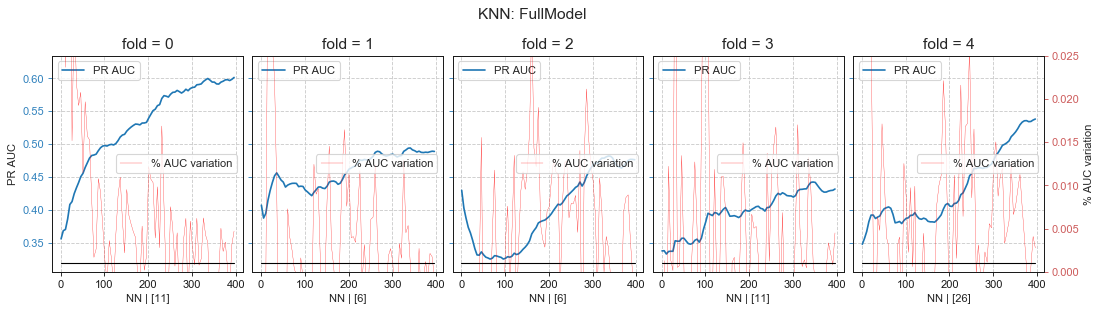

In [173]:
# test k NN (number of Nearest Neighbours)
if(test_bool):
    figmodelKNNs = f_model_KNN_test(400, 5, model_str.split('_')[0] + ': ' + modelvars_str, 0.5, model_eval_curve)
    plt.show(figmodelKNNs)

Looking at these plots let's choose K = 300.

In [174]:
k = 300

In [175]:
# build the models (only after testing for the hyperparameters)
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = KNeighborsClassifier(n_neighbors = k)')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [176]:
beta = beta_global

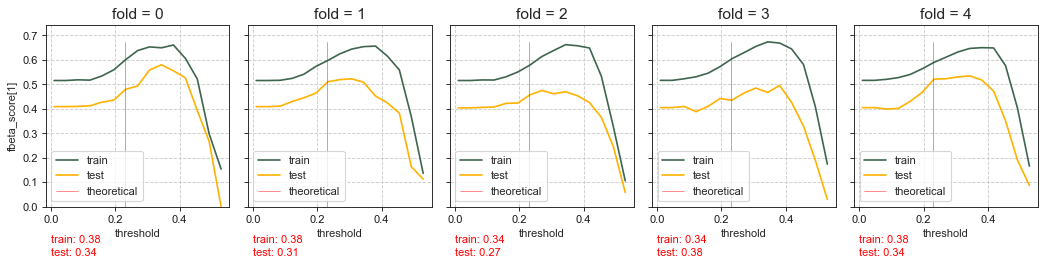

In [177]:
# select the threshold to maximize the metric
figmodelKNNs_thresholds, KNNs_best_threshold_train, KNNs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelKNNs_thresholds)

In [178]:
selected_threshold = mean(KNNs_best_threshold_train)
print('{:.2f}'.format(mean(KNNs_best_threshold_train)))

0.37


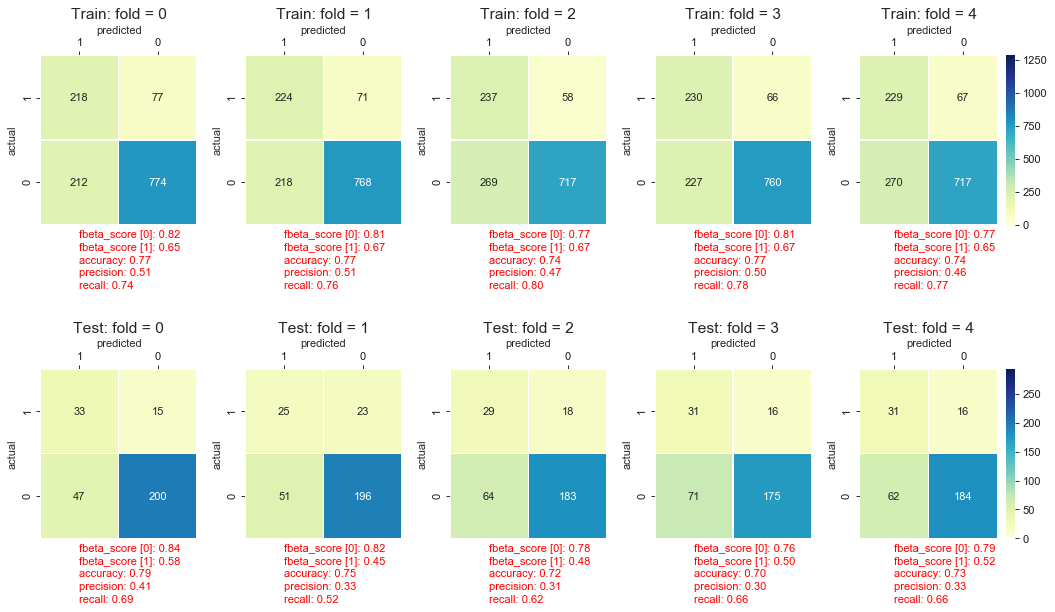

In [179]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelKNNs_CM, f_score_train_KNNs, f_score_test_KNNs, accuracy_train_KNNs, accuracy_test_KNNs, \
precision_train_KNNs, precision_test_KNNs, recall_train_KNNs, recall_test_KNNs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelKNNs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_KNNs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_KNNs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_KNNs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_KNNs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_KNNs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_KNNs))
model_cmp_mean_precision_train.append(mean(precision_train_KNNs))
model_cmp_mean_precision_test.append(mean(precision_test_KNNs))
model_cmp_mean_recall_train.append(mean(recall_train_KNNs))
model_cmp_mean_recall_test.append(mean(recall_test_KNNs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.563
recall: 0.10 | precision: 0.84 | threshold: 0.512
recall: 0.30 | precision: 0.60 | threshold: 0.461
recall: 0.49 | precision: 0.44 | threshold: 0.410
recall: 0.67 | precision: 0.32 | threshold: 0.350
recall: 0.82 | precision: 0.27 | threshold: 0.293
recall: 0.90 | precision: 0.21 | threshold: 0.234
recall: 0.95 | precision: 0.20 | threshold: 0.183
recall: 0.98 | precision: 0.17 | threshold: 0.112


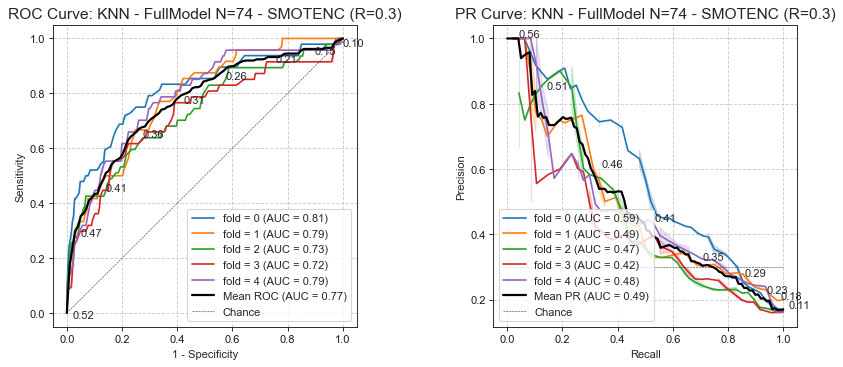

In [180]:
# plot the ROC Curve & PR Curve
figmodelKNNs_ROC, KNNs_mean_roc_auc, KNNs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars, \
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)

plt.show(figmodelKNNs_ROC)
model_cmp_mean_roc_auc.append(KNNs_mean_roc_auc)
model_cmp_mean_pr_auc.append(KNNs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model2_sampling-SMOTENC_1-NN"></a>
##### 4.3.2.2: Neural Networks

In [181]:
model_cmp.append(nvars)
model_str = 'NN_SMOTENC_R1'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)
n_hidden = 1

<b>Test the learning rate ...</b>

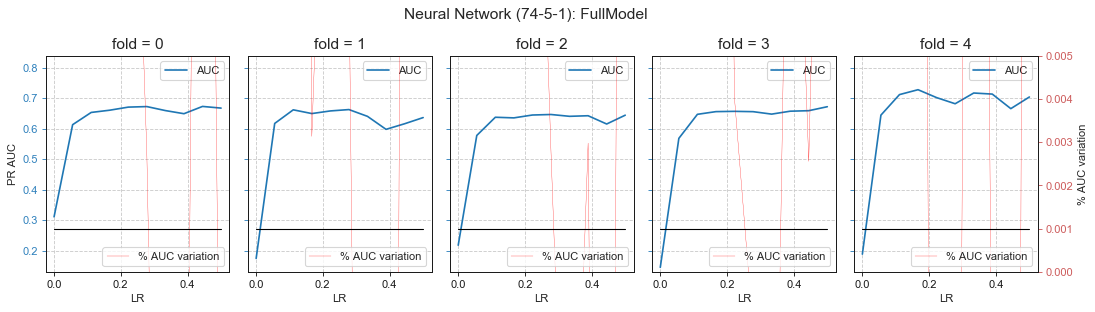

In [182]:
# test Learning Rate
if(test_bool):
    figmodelNNs_LRsk = f_model_NN_testLR(0.001, 0.5, 10, 350, 5, n_hidden, nvars, modelvars_str, 0.1, model_eval_curve)
    plt.show(figmodelNNs_LRsk)

Looking at these plots let's choose learning_rate_init = 0.2.

In [183]:
LR = .2

<b>Test the network architecture ...</b>

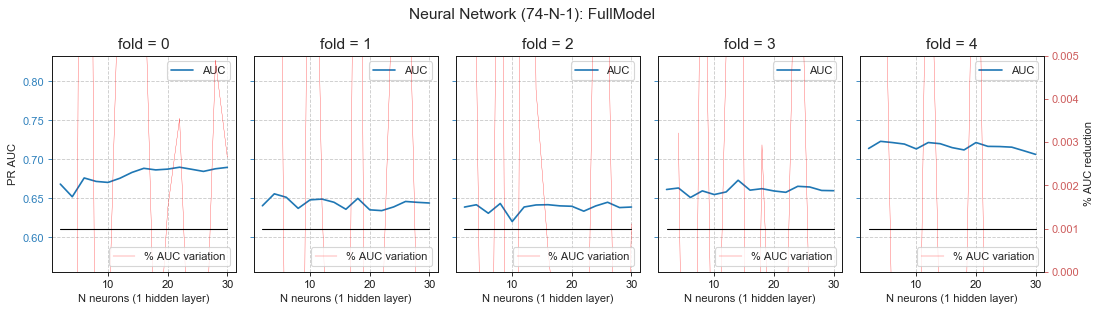

In [184]:
# test Network Architecture
if(test_bool):
    figmodelNNs_N = f_model_NN_testNeurons(LR, 2, 32, 2, 350, n_hidden, nvars, modelvars_str, 0.1, model_eval_curve)
    plt.show(figmodelNNs_N)

Looking at these plots let's choose 8 for the number of neurons on a single hidden layer.

In [185]:
n_neurons = 8

In [186]:
# build the models
start_time = time.time()
for cv in range(n_cv):
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '= MLPClassifier(solver = ' + '\'' + 'sgd' + '\'' +\
         ', activation = ' + '\'' + 'logistic' + '\'' + ', max_iter = 350,' +\
         'learning_rate = ' + '\'' + 'adaptive' + '\'' + ', learning_rate_init = LR,\
         random_state = None, shuffle = True, momentum = .9,\
         hidden_layer_sizes = tuple([n_neurons for h in range(n_hidden)]),\
         n_iter_no_change = 3, tol = 1e-3)')
    
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [187]:
beta = beta_global

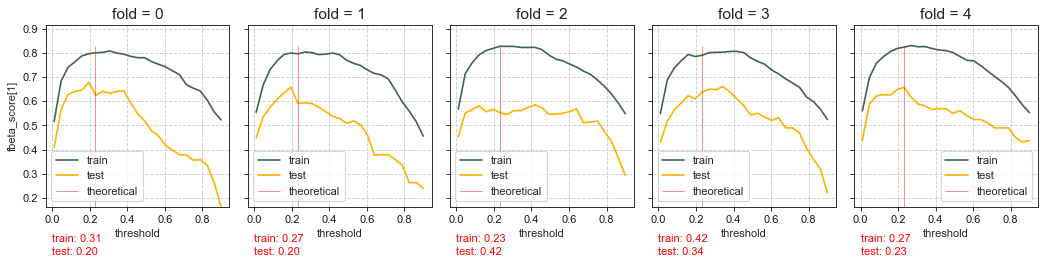

In [188]:
# select the threshold to maximize the metric
figmodelNNs_thresholds, NNs_best_threshold_train, NNs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelNNs_thresholds)

In [189]:
selected_threshold = mean(NNs_best_threshold_train)
print('{:.2f}'.format(mean(NNs_best_threshold_train)))

0.30


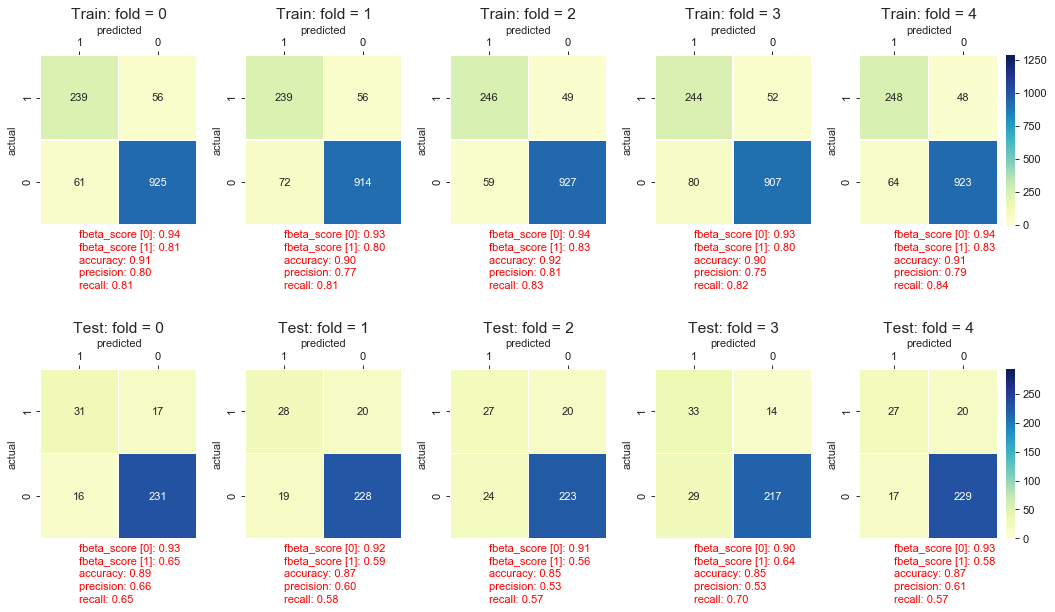

In [190]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelNNs_CM, f_score_train_NNs, f_score_test_NNs, accuracy_train_NNs, accuracy_test_NNs, \
precision_train_NNs, precision_test_NNs, recall_train_NNs, recall_test_NNs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelNNs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_NNs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_NNs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_NNs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_NNs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_NNs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_NNs))
model_cmp_mean_precision_train.append(mean(precision_train_NNs))
model_cmp_mean_precision_test.append(mean(precision_test_NNs))
model_cmp_mean_recall_train.append(mean(recall_train_NNs))
model_cmp_mean_recall_test.append(mean(recall_test_NNs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.997
recall: 0.13 | precision: 0.95 | threshold: 0.944
recall: 0.22 | precision: 0.89 | threshold: 0.889
recall: 0.29 | precision: 0.86 | threshold: 0.836
recall: 0.32 | precision: 0.85 | threshold: 0.784
recall: 0.38 | precision: 0.80 | threshold: 0.717
recall: 0.44 | precision: 0.81 | threshold: 0.642
recall: 0.47 | precision: 0.76 | threshold: 0.573
recall: 0.52 | precision: 0.68 | threshold: 0.462
recall: 0.56 | precision: 0.66 | threshold: 0.403
recall: 0.58 | precision: 0.62 | threshold: 0.346
recall: 0.63 | precision: 0.58 | threshold: 0.282
recall: 0.69 | precision: 0.52 | threshold: 0.224
recall: 0.75 | precision: 0.44 | threshold: 0.150
recall: 0.79 | precision: 0.37 | threshold: 0.099
recall: 0.86 | precision: 0.28 | threshold: 0.048


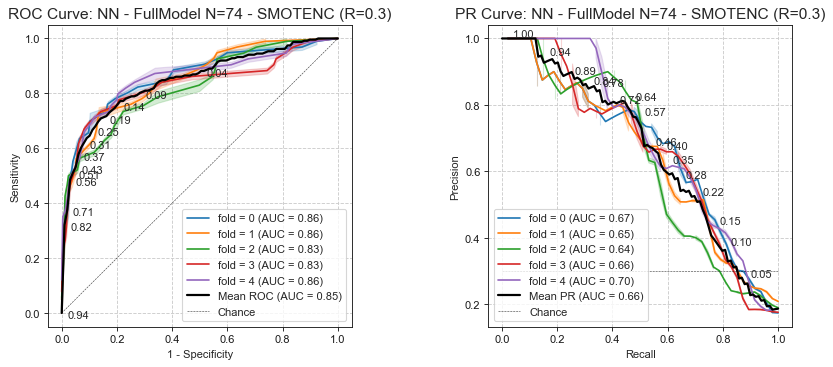

In [191]:
# plot the ROC Curve & PR Curve
figmodelNNs_ROC, NNs_mean_roc_auc, NNs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelNNs_ROC)
model_cmp_mean_roc_auc.append(NNs_mean_roc_auc)
model_cmp_mean_pr_auc.append(NNs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model2_sampling-SMOTENC_1-LogReg"></a>
##### 4.3.2.3: Logistic Regression

In [192]:
model_cmp.append(nvars)
model_str = 'LogReg_SMOTENC_R1'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)
nmax_iter = 300

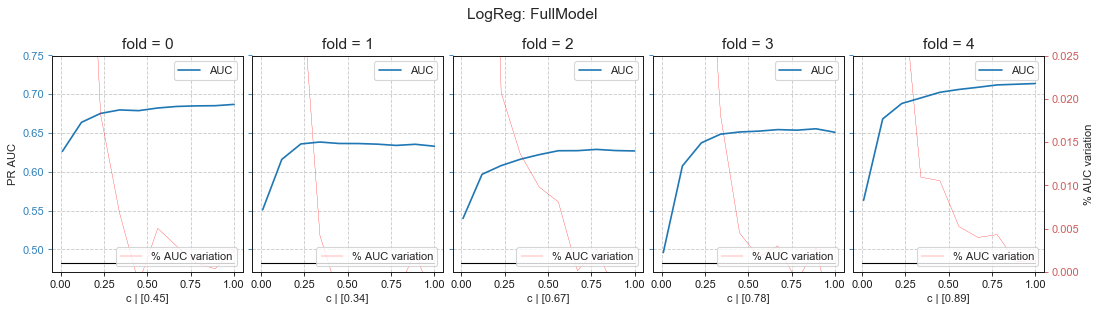

In [193]:
# test c (Inverse of regularization strength)
if(test_bool):
    figmodelLogRegs = f_model_LogReg_test(nmax_iter, 10, model_str.split('_')[0] + ': ' + modelvars_str,\
                                          0.1, model_eval_curve)
    plt.show(figmodelLogRegs)

Looking at these plots let's choose c = 1.0.

In [194]:
c = 1.0

In [195]:
# build the models (only after testing for the hyperparameters)
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = LogisticRegression(penalty = ' + '\'' + 'l2' + '\'' + \
         ', dual = False, tol = 1e-4, C = '+ '{:.2f}'.format(c) + ', fit_intercept = True, intercept_scaling = 1,' + \
         'class_weight = None, random_state = None, solver = ' + '\'' + 'liblinear' + '\'' +', max_iter = ' + \
         str(nmax_iter) + ', verbose = 0, warm_start = True)')

    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + \
         str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [196]:
beta = beta_global

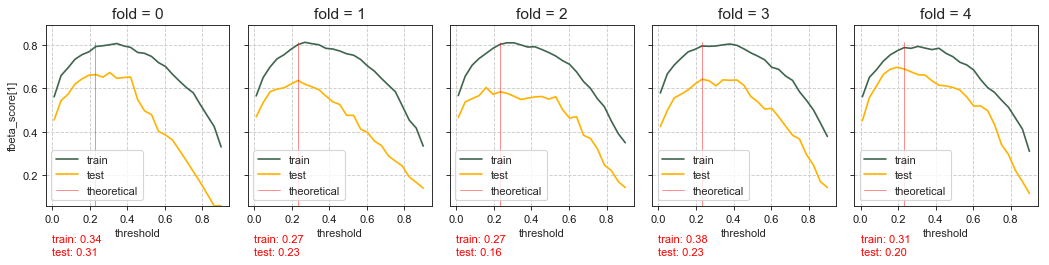

In [197]:
# select the threshold to maximize the metric
figmodelLogRegs_thresholds, LogRegs_best_threshold_train, LogRegs_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelLogRegs_thresholds)

In [198]:
selected_threshold = mean(LogRegs_best_threshold_train)
print('{:.2f}'.format(mean(LogRegs_best_threshold_train)))

0.31


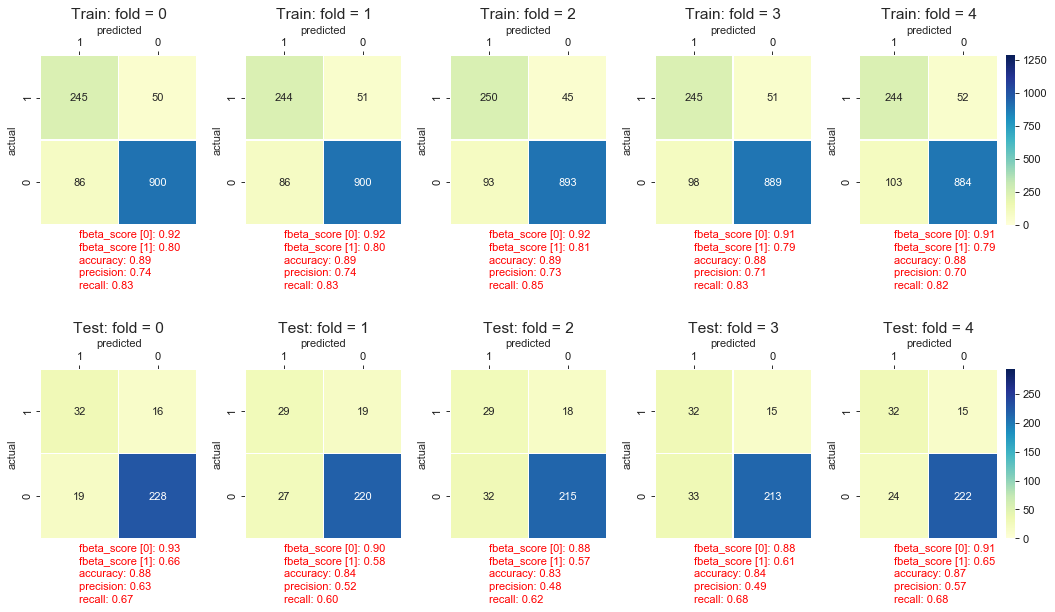

In [199]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelLogRegs_CM, f_score_train_LogRegs, f_score_test_LogRegs, accuracy_train_LogRegs, accuracy_test_LogRegs, \
precision_train_LogRegs, precision_test_LogRegs, recall_train_LogRegs, recall_test_LogRegs = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelLogRegs_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_LogRegs[0])
model_cmp_mean_f_score_train_1.append(f_score_train_LogRegs[1])
model_cmp_mean_f_score_test_0.append(f_score_test_LogRegs[0])
model_cmp_mean_f_score_test_1.append(f_score_test_LogRegs[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_LogRegs))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_LogRegs))
model_cmp_mean_precision_train.append(mean(precision_train_LogRegs))
model_cmp_mean_precision_test.append(mean(precision_test_LogRegs))
model_cmp_mean_recall_train.append(mean(recall_train_LogRegs))
model_cmp_mean_recall_test.append(mean(recall_test_LogRegs))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 0.979
recall: 0.07 | precision: 1.00 | threshold: 0.923
recall: 0.12 | precision: 1.00 | threshold: 0.869
recall: 0.17 | precision: 0.89 | threshold: 0.816
recall: 0.22 | precision: 0.88 | threshold: 0.764
recall: 0.29 | precision: 0.86 | threshold: 0.703
recall: 0.33 | precision: 0.79 | threshold: 0.652
recall: 0.42 | precision: 0.77 | threshold: 0.582
recall: 0.46 | precision: 0.75 | threshold: 0.529
recall: 0.53 | precision: 0.71 | threshold: 0.478
recall: 0.56 | precision: 0.65 | threshold: 0.427
recall: 0.63 | precision: 0.59 | threshold: 0.370
recall: 0.67 | precision: 0.55 | threshold: 0.320
recall: 0.72 | precision: 0.50 | threshold: 0.263
recall: 0.77 | precision: 0.44 | threshold: 0.197
recall: 0.82 | precision: 0.39 | threshold: 0.147
recall: 0.86 | precision: 0.33 | threshold: 0.096
recall: 0.90 | precision: 0.23 | threshold: 0.033


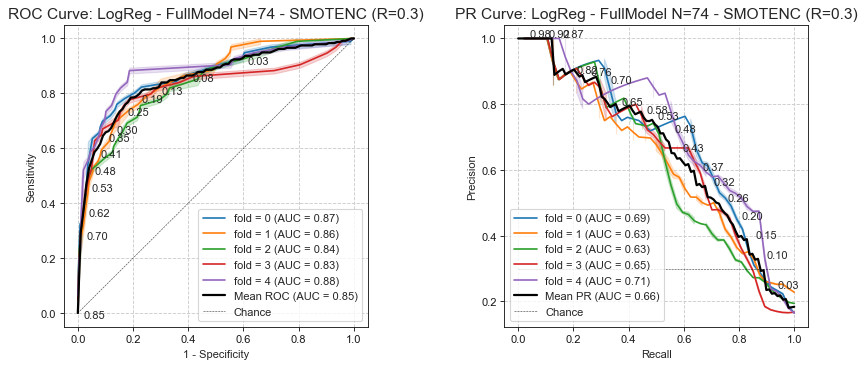

In [200]:
# plot the ROC Curve & PR Curve
figmodelLogRegs_ROC, LogRegs_mean_roc_auc, LogRegs_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelLogRegs_ROC)
model_cmp_mean_roc_auc.append(LogRegs_mean_roc_auc)
model_cmp_mean_pr_auc.append(LogRegs_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model2_sampling-SMOTENC_1-NBayes"></a>
##### 4.3.2.4: Naive Bayes

In [201]:
model_cmp.append(nvars)
model_str = 'NBayes_kfold'
model_cmp_type.append(model_str.split('_')[0])
model_cmp_sampling.append(sampling_str)

In [202]:
# build the models 
start_time = time.time()
for cv in range(n_cv): 
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + ' = GaussianNB()')
    exec('model' + model_str + '_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + \
         'y_train_' + \
         str(cv) + ')')
elapsed_time = time.time() - start_time
model_cmp_train_elapsedtime_ms.append(elapsed_time*1000)

In [203]:
beta = beta_global

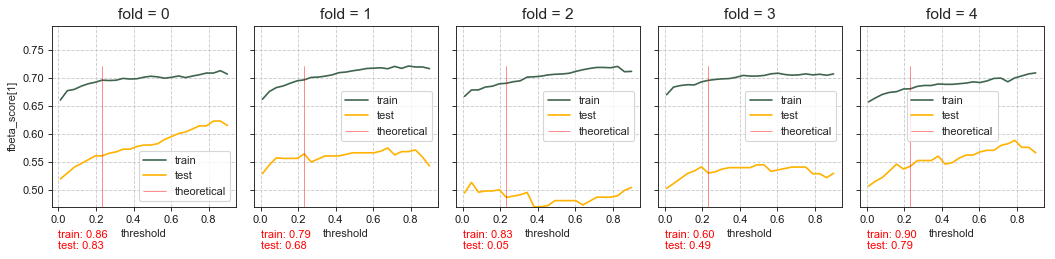

In [204]:
# select the threshold to maximize the metric
figmodelNBayes_thresholds, NBayes_best_threshold_train, NBayes_best_threshold_test = \
f_threshold(model_str, nvars, theoretical_threshold, metric, True, beta)
plt.show(figmodelNBayes_thresholds)

In [205]:
selected_threshold = mean(NBayes_best_threshold_train)
print('{:.2f}'.format(mean(NBayes_best_threshold_train)))

0.80


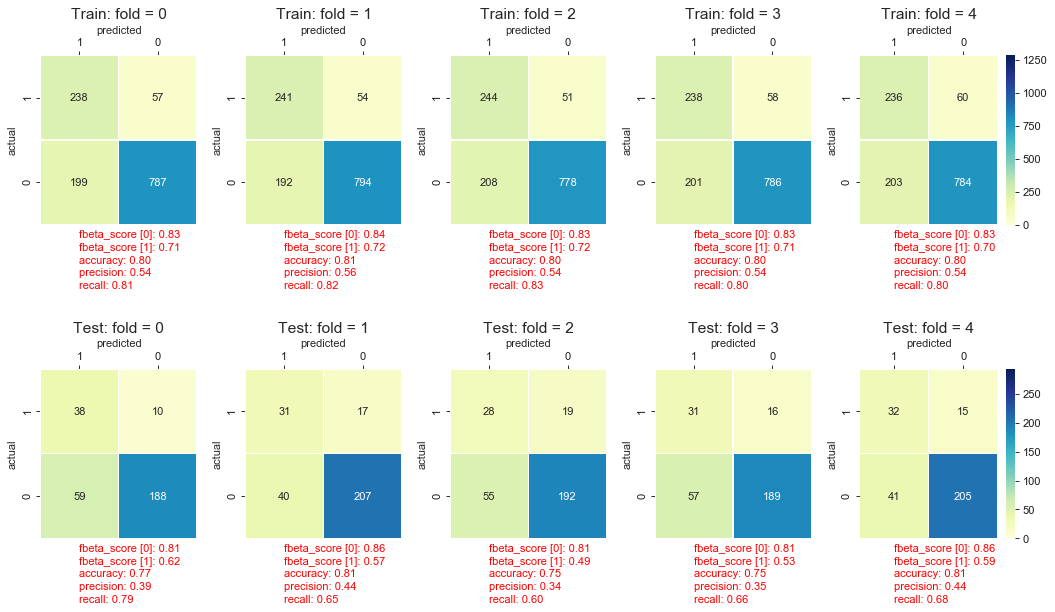

In [206]:
# plot the Confusion Matrix (CM): adjusted with the selected threshold
figmodelNBayes_CM, f_score_train_NBayes, f_score_test_NBayes, accuracy_train_NBayes, accuracy_test_NBayes, \
precision_train_NBayes, precision_test_NBayes, recall_train_NBayes, recall_test_NBayes = \
f_CM_heatmap(model_str, nvars, selected_threshold, False, beta)
plt.show(figmodelNBayes_CM)
model_cmp_mean_f_score_train_0.append(f_score_train_NBayes[0])
model_cmp_mean_f_score_train_1.append(f_score_train_NBayes[1])
model_cmp_mean_f_score_test_0.append(f_score_test_NBayes[0])
model_cmp_mean_f_score_test_1.append(f_score_test_NBayes[1])
model_cmp_mean_accuracy_train.append(mean(accuracy_train_NBayes))
model_cmp_mean_accuracy_test.append(mean(accuracy_test_NBayes))
model_cmp_mean_precision_train.append(mean(precision_train_NBayes))
model_cmp_mean_precision_test.append(mean(precision_test_NBayes))
model_cmp_mean_recall_train.append(mean(recall_train_NBayes))
model_cmp_mean_recall_test.append(mean(recall_test_NBayes))

PR Curve:
recall: 0.00 | precision: 1.00 | threshold: 1.000
recall: 0.60 | precision: 0.43 | threshold: 0.912
recall: 0.63 | precision: 0.40 | threshold: 0.827
recall: 0.65 | precision: 0.38 | threshold: 0.755
recall: 0.67 | precision: 0.37 | threshold: 0.632
recall: 0.69 | precision: 0.36 | threshold: 0.458
recall: 0.71 | precision: 0.35 | threshold: 0.305
recall: 0.73 | precision: 0.31 | threshold: 0.205
recall: 0.80 | precision: 0.25 | threshold: 0.000


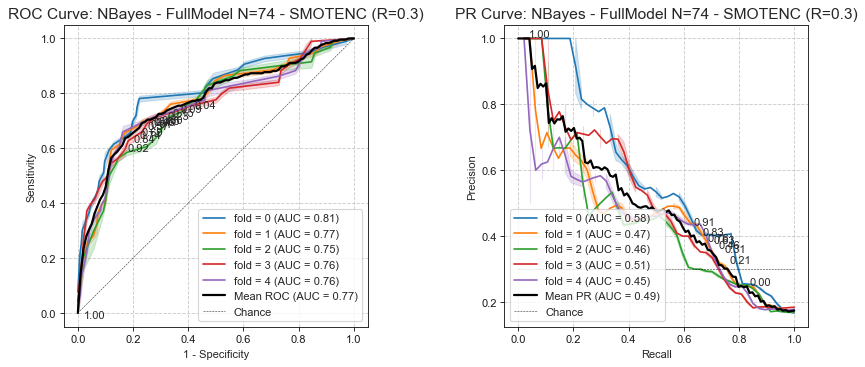

In [207]:
# plot the ROC Curve & PR Curve
figmodelNBayes_ROC, NBayes_mean_roc_auc, NBayes_mean_pr_auc = f_ModelEval_Curves(model_str, nvars,\
                                       model_str.split('_')[0] + ' - ' + modelvars_str + ' N=' +\
                                            str(nvars) + ' - ' + sampling_str)
plt.show(figmodelNBayes_ROC)
model_cmp_mean_roc_auc.append(NBayes_mean_roc_auc)
model_cmp_mean_pr_auc.append(NBayes_mean_pr_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model_comp"></a>
### 4.4: Model Comparison

In [208]:
pd.set_option('precision', 3)
df_model_cmp = pd.DataFrame(
    {'Sampling': model_cmp_sampling,
     'ModelVars': model_cmp,
     'ModelType': model_cmp_type,
     'mean_pr_auc': model_cmp_mean_pr_auc,
     'mean_roc_auc': model_cmp_mean_roc_auc,
     'mean_fbeta_score_train_0': model_cmp_mean_f_score_train_0,
     'mean_fbeta_score_train_1': model_cmp_mean_f_score_train_1,
     'mean_accuracy_train': model_cmp_mean_accuracy_train, 
     'mean_precision_train': model_cmp_mean_precision_train,
     'mean_recall_train': model_cmp_mean_recall_train,
     'mean_fbeta_score_test_0': model_cmp_mean_f_score_test_0,
     'mean_fbeta_score_test_1': model_cmp_mean_f_score_test_1,
     'mean_accuracy_test': model_cmp_mean_accuracy_test, 
     'mean_precision_test': model_cmp_mean_precision_test,
     'mean_recall_test': model_cmp_mean_recall_test,
     'total_training_time_ms': model_cmp_train_elapsedtime_ms
    })
df_model_cmp.to_csv('df_Models.csv', sep = '\t', index = False)
df_model_cmp.sort_values(by = ['mean_pr_auc'], ascending = False).T

10         12         11         3   \
Sampling                  k-fold cv  k-fold cv  k-fold cv  k-fold cv   
ModelVars                        74         74         74         46   
ModelType                        NN     LogReg         DL     LogReg   
mean_pr_auc                   0.696      0.694      0.686      0.676   
mean_roc_auc                  0.859      0.862      0.855      0.853   
mean_fbeta_score_train_0      0.926      0.916      0.942      0.905   
mean_fbeta_score_train_1      0.707      0.704      0.728      0.674   
mean_accuracy_train           0.889      0.879      0.907      0.865   
mean_precision_train          0.634        0.6      0.702      0.562   
mean_recall_train              0.74      0.755      0.739      0.731   
mean_fbeta_score_test_0       0.926      0.916      0.942      0.905   
mean_fbeta_score_test_1       0.707      0.704      0.728      0.674   
mean_accuracy_test             0.87      0.853      0.878      0.842   
mean_precision_test           0.584      0.538      0.629       0.51   
mean_recall_test              0.688      0.684      0.637      0.688   
total_training_time_ms          935       57.7   7.99e+04       46.2   

                                 1                15               16  \
Sampling                  k-fold cv  SMOTENC (R=0.3)  SMOTENC (R=0.3)   
ModelVars                        46               74               74   
ModelType                        NN               NN           LogReg   
mean_pr_auc                   0.672            0.662            0.662   
mean_roc_auc                   0.85            0.846            0.854   
mean_fbeta_score_train_0      0.908            0.936            0.917   
mean_fbeta_score_train_1      0.663            0.812            0.798   
mean_accuracy_train           0.865            0.907            0.888   
mean_precision_train          0.566            0.784            0.725   
mean_recall_train             0.711            0.823            0.831   
mean_fbeta_score_test_0       0.908            0.936            0.917   
mean_fbeta_score_test_1       0.663            0.812            0.798   
mean_accuracy_test            0.849            0.867            0.852   
mean_precision_test           0.527            0.586            0.537   
mean_recall_test              0.662            0.616             0.65   
total_training_time_ms        1e+03         1.12e+03             58.2   

                                 2                7                6   \
Sampling                  k-fold cv  SMOTENC (R=0.3)  SMOTENC (R=0.3)   
ModelVars                        46               46               46   
ModelType                        DL           LogReg               NN   
mean_pr_auc                   0.659            0.619            0.615   
mean_roc_auc                  0.848            0.821            0.818   
mean_fbeta_score_train_0      0.913            0.861            0.857   
mean_fbeta_score_train_1      0.681            0.714            0.716   
mean_accuracy_train           0.873            0.824            0.821   
mean_precision_train          0.588            0.589            0.584   
mean_recall_train             0.728            0.779            0.786   
mean_fbeta_score_test_0       0.913            0.861            0.857   
mean_fbeta_score_test_1       0.681            0.714            0.716   
mean_accuracy_test             0.85            0.809            0.803   
mean_precision_test            0.53            0.445            0.432   
mean_recall_test              0.645            0.696            0.684   
total_training_time_ms     6.05e+04             51.2              990   

                                 4          0          9                8   \
Sampling                  k-fold cv  k-fold cv  k-fold cv  SMOTENC (R=0.3)   
ModelVars                        46         46         74               46   
ModelType                    NBayes        KNN        KNN           NBayes   
mean_pr_auc 

From this table it is possible to observe that even with a slight increase on the unbalance ratio from 0.19 to 0.3 using the oversampling technique, the AUC of the different models did not improve, so we did not continue the oversampling process.

Three models clearly stand out with higher AUC on both ROC and PR curves as well as better compromise between the precision and recall which are the Neural Network, Logistic Regression and Deep Learning models using all variables (full model).

In the end, we choose the Neural Network model (with only 1 hidden layer) considering as the best predictive model considering the performance metrics as well as the total training time relevant for the model deployment.


Store the model predictions for the best models ...

In [210]:
# choose the models trained with the fold that is closer to the mean line
# model 1:
predclass_modelNN_kfold = f_model_pred_cost(modelNN_kfold_1_74, data, 0.25)
predprob_modelNN_kfold = modelNN_kfold_1_74.predict_proba(data)[:,1].tolist()

# model 2:
predclass_modelLogReg_kfold = f_model_pred_cost(modelLogReg_kfold_3_74, data, 0.27)
predprob_modelLogReg_kfold = modelLogReg_kfold_3_74.predict_proba(data)[:,1].tolist()

# model 3:
predclass_modelDL_kfold = f_model_pred_cost(modelDL_kfold_3_74, data, 0.27, 1)
predprob_modelDL_kfold = modelDL_kfold_3_74.predict(data, batch_size = 1)[:,0].tolist()

In [211]:
df = pd.read_csv('HR_DS.csv')

In [212]:
df_model_pred = pd.DataFrame(
    {'EmployeeNumber': df['EmployeeNumber'],
     'predclass_modelLogReg_kfold': predclass_modelLogReg_kfold,
     'predprob_modelLogReg_kfold': predprob_modelLogReg_kfold,
     'predclass_modelNN_kfold': predclass_modelNN_kfold,
     'predprob_modelNN_kfold': predprob_modelNN_kfold,
     'predclass_modelDL_kfold': predclass_modelDL_kfold,
     'predprob_modelDL_kfold': predprob_modelDL_kfold
     })
df_model_pred.to_csv('df_ModelPred.csv', sep = '\t', index = False)

[Return to Table of Contents](#Table_Contents)